# init

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import os, sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# import seaborn as sns
# print(os.getcwd())
os.chdir('/gpfs/data/healthcare-allocate/mimic-repos/CLIF-MIMIC/src')
# print(os.getcwd())

proj_root = "/gpfs/data/healthcare-allocate/CLIF-MIMIC"
if proj_root not in sys.path:
    sys.path.append(proj_root)

# from code.custom_utils import *
import logging

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s',
    handlers=[logging.StreamHandler()]
)

## load tables

In [3]:
def load_mimic_table(
    module: {"icu", "hosp"}, table, file_type: {"csv", "parquet", "pq"} = None,
    mimic_version = "3.1"
    ):
    # check if parquest exists under in the corresponding module folder
    parquet_path = f'../data/mimic-data/mimic-iv-{mimic_version}/{module}/{table}.parquet'
    csv_path = f'../data/mimic-data/mimic-iv-{mimic_version}/{module}/{table}.csv.gz'
    
    if file_type is not None:
        if file_type in ["pq", "parquet"]:
            if os.path.exists(parquet_path):
                return pd.read_parquet(parquet_path)
            else:
                raise FileNotFoundError(f"Parquet file not found at {parquet_path}")
        elif file_type == "csv":
            if os.path.exists(csv_path):
                return pd.read_csv(csv_path, low_memory = False)
            else:
                raise FileNotFoundError(f"CSV file not found at {csv_path}")
        else:
            raise ValueError(f"Unsupported file type: {file_type}")
    else:
        if os.path.exists(parquet_path):
            logging.info(f"reading already converted parquet file for {module}/{table}")
            return pd.read_parquet(parquet_path, engine = "auto")
        else:
            logging.info(f"no parquet file exists yet for {module}/{table}, so reading from csv")
            df = pd.read_csv(csv_path, low_memory = False)
            df.to_parquet(parquet_path)
            return df

In [4]:
def load_mimic_tables(tables, cache = True):
    for module, table in tables:
        logging.info(f"Loading {table} from module {module}")
        var_name = table
        if (cache) and (var_name in globals()):
            logging.info(f"Table {table} from module {module} is already loaded in memory")
            continue
        try:
            globals()[var_name] = load_mimic_table(module, table)
            logging.info(f"Successfully loaded table {table} from module {module}")
        except Exception as e:
            logging.error(f"Error loading table: {table} from module: {module}. Error: {e}")

mimic_tables_to_load = [
    ("hosp", "patients"), # saved in pq
    ("hosp", "admissions"), # # saved in pq
    ("icu", "d_items"), # saved in pq
    ("icu", "chartevents"), # saved in pq
    ("icu", "procedureevents"), # error ---- done
    ("icu", "datetimeevents"), # saved in pq
    ("icu", "inputevents"), # error ---- done
    ("icu", "outputevents"), # error ---- done
    ("hosp", "d_labitems"), # saved in pq
    ("hosp", "labevents"), # error ----
    ("hosp", "poe"), # saved in pq
    ("hosp", "poe_detail"), # saved in pq
    ("hosp", "transfers"), # saved in pq
    ("icu", "icustays"), # saved in pq
    ("icu", "ingredientevents") # saved in pq
]

load_mimic_tables(mimic_tables_to_load)

2024-12-20 10:47:06,531:INFO:Loading patients from module hosp
2024-12-20 10:47:06,537:INFO:reading already converted parquet file for hosp/patients
2024-12-20 10:47:06,975:INFO:Successfully loaded table patients from module hosp
2024-12-20 10:47:06,977:INFO:Loading admissions from module hosp
2024-12-20 10:47:06,979:INFO:reading already converted parquet file for hosp/admissions
2024-12-20 10:47:07,800:INFO:Successfully loaded table admissions from module hosp
2024-12-20 10:47:07,802:INFO:Loading d_items from module icu
2024-12-20 10:47:07,805:INFO:reading already converted parquet file for icu/d_items
2024-12-20 10:47:07,835:INFO:Successfully loaded table d_items from module icu
2024-12-20 10:47:07,838:INFO:Loading chartevents from module icu
2024-12-20 10:47:07,841:INFO:reading already converted parquet file for icu/chartevents
2024-12-20 10:49:16,281:INFO:Successfully loaded table chartevents from module icu
2024-12-20 10:49:16,284:INFO:Loading procedureevents from module icu
2024-

## load mappings

In [4]:
def load_mapping_csv(csv_name: str, dtype = None):
    return pd.read_csv(
        f"../data/mappings/mimic-to-clif-mappings - {csv_name}.csv", dtype = dtype
        )
# covert to a dict for df col renaming later

def construct_mapper_dict(
    mapping_df: pd.DataFrame, key_col: str, value_col: str, map_none_to_none = False,
    excluded_item_ids: list = None
    ):

    if not excluded_item_ids:
        excluded_item_ids = []
    
    if "itemid" in mapping_df.columns:
        mapping_df = mapping_df.loc[
            ~mapping_df["itemid"].isin(excluded_item_ids)
            , 
            ]
    
    mapper_dict = dict(zip(mapping_df[key_col], mapping_df[value_col]))
    
    # Replace "NO MAPPING" with NA
    for key, value in mapper_dict.items():
        if value == "NO MAPPING":
            mapper_dict[key] = None
    
    # to enable a None -> None mapping
    if map_none_to_none:
        mapper_dict[None] = None
        
    return mapper_dict

In [5]:
# patient table
race_ethnicity_mapping = load_mapping_csv("race_ethnicity")
race_mapper_dict = construct_mapper_dict(race_ethnicity_mapping, "mimic_race", "race")
ethnicity_mapper_dict = construct_mapper_dict(race_ethnicity_mapping, "mimic_race", "ethnicity")

# hosp table
discharge_mapping = load_mapping_csv("discharge")
discharge_mapper_dict = construct_mapper_dict(
    discharge_mapping, "discharge_location", "disposition_category"
    )

# adt 
adt_mapping = load_mapping_csv("adt")
adt_mapper_dict = construct_mapper_dict(adt_mapping, "careunit", "location_category")

# vitals table
vitals_mapping = load_mapping_csv("vitals")
vital_name_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "label = vital_name")
vital_category_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "vital_category")

# resp support table
resp_mapping = load_mapping_csv("respiratory_support")
resp_device_mapping = load_mapping_csv("device_category")
resp_mode_mapping = load_mapping_csv("mode_category")

resp_mapper_dict = construct_mapper_dict(resp_mapping, "itemid", "variable")
resp_device_mapper_dict = construct_mapper_dict(
    resp_device_mapping, "device_name", "device_category", excluded_item_ids = ["223848"]
    )
resp_mode_mapper_dict = construct_mapper_dict(resp_mode_mapping, "mode_name", "mode_category")

# utils

In [6]:
logging.basicConfig(
    level = logging.INFO,
    format = '%(asctime)s:%(levelname)s:%(message)s',
    handlers = [logging.FileHandler("mimic-to-clif.log"),
              logging.StreamHandler()])

## `CacheInfo` class

In [7]:
class CacheInfo:
    """
    CacheInfo object used to represent the current status of `lru_cache`
    """
    def __init__(self, max_size):
        self.max_size = max_size
        self.misses = 0
        self.hits = 0
        self.cur_size = 0
        # NOTE: you may add to this if you want, but do not modify the lines above
        # create an attribute in the CacheInfo class to store the cache dict
        self.cache_dict = {}
    
    def __repr__(self):
        return f"CacheInfo(hits={self.hits}, misses={self.misses}, max_size={self.max_size}, cur_size={self.cur_size})"

# first layer: a decorator factory
def lru_cache(max_size = 128):
    '''
    This function is a decorator factory that returns a decorator with a user-specified
    maximum size of the cache 

    Input:
        - max_size: the maximum size of the cache
    
    Output: 
        - a decorator
    '''
    # second layer: the decorator
    def decorator(func):
        '''
        This function is a decorator that takes in an original function and
        return a new, decorated function.

        Input: an original function

        Output: a new function
        '''
        # initialize an instance of the CacheInfo class
        cache_info = CacheInfo(max_size = max_size)
        def key_generator(*args, **kwargs):
            '''
            This helper function creates a unique key given every different 
            combination of positional and key-word arguments

            Input: 
                - *args: any position arguments
                - **kwargs: any key word arguments

            Output: 
                - a tuple that stores all the arguments and their data type
            '''
            # generates a tuple that stores the data type of each position arg
            args_type = tuple(map(lambda x: type(x), args))
            # kwargs is a dict, so we use items() to turn it into a seq of
            # key-value tuples, and add the data type of the key word arg
            # to the tuple, then use frozenset() to make it immutable and 
            # thus hashable
            kwargs_and_type = frozenset(
                       map(lambda tup: (tup, type(tup[1])), 
                           kwargs.items()))
            return (args, args_type, kwargs_and_type)
        def new_func(*args, **kwargs):
            '''
            This is the new function that replaces the original function.

            Input:
                - *args, **kwargs: any position and key word arguments

            Output:
                - the result of the new function
            '''
            key = key_generator(*args, **kwargs)        
            # if the key is already in the cache dict, i.e. the same args have
            # been provided before, there should be "memory" in the cache
            # we got a hit
            if key in cache_info.cache_dict:
                cache_info.hits += 1 
                # temporarily store the cache result first before we remove the key
                cached_result = cache_info.cache_dict[key]
                # remove the key
                cache_info.cache_dict.pop(key)
                # insert the same key to the tail of the dict
                cache_info.cache_dict[key] = cached_result
                return cached_result
            # when we have a new arg combination that is not seen before 
            # -- we have a "miss":
            else:
                cache_info.misses += 1  
                # add the output of the function to the dict
                cache_info.cache_dict[key] = func(*args, **kwargs)  
                # update cache size (length of the dict) 
                cache_info.cur_size = len(cache_info.cache_dict) 
                # if the cache exceeds the maximum size, remove the least recently used item
                if len(cache_info.cache_dict) > max_size:
                    # first covert the dict to a list so we can track the order
                    cache_list = list(cache_info.cache_dict.items())
                    # remove the first element in the list, which is the least 
                    # recently used item
                    cache_list.pop(0)
                    # convert the list back to a dict and update
                    cache_info.cache_dict = dict(cache_list)
                    # update the cache size again, which should = max_size
                    cache_info.cur_size = len(cache_info.cache_dict)  
                return cache_info.cache_dict[key]
        # update the attribute of the now-decorated new func
        new_func.cache_info = cache_info
        return new_func     
    return decorator

## helper funcs

In [8]:
def convert_and_sort_datetime(df: pd.DataFrame, additional_cols: list[str] = None):
    if not additional_cols:
        additional_cols = []
    # for procedure events
    if "starttime" in df.columns and "endtime" in df.columns:
        df["starttime"] = pd.to_datetime(df["starttime"])
        df["endtime"] = pd.to_datetime(df["endtime"])
        ordered_cols = ["hadm_id", "starttime", "endtime", "storetime"] + additional_cols
        df = df.sort_values(ordered_cols).reset_index(drop = True).reset_index()
    # for chart events
    elif "charttime" in df.columns:
        df["charttime"] = pd.to_datetime(df['charttime'])
        ordered_cols = ["hadm_id", "charttime", "storetime"] + additional_cols
        df = df.sort_values(ordered_cols).reset_index(drop = True).reset_index()
    elif "time" in df.columns:
        df["time"] = pd.to_datetime(df['time'])
        ordered_cols = ["hadm_id", "time"] + additional_cols
        df = df.sort_values(ordered_cols)
    return df

In [9]:
def save_to_rclif(df: pd.DataFrame, table_name, file_format = "pq"):
    if file_format in ["pq", "parquet"]:
        df.to_parquet(f'../rclif/clif_{table_name}.parquet')

def read_from_rclif(table_name, file_format = "pq"):
    if file_format in ["pq", "parquet"]:
        return pd.read_parquet(f'../rclif/clif_{table_name}.parquet')

In [10]:
# FIXME: delete "ALREDAY MAPPED" at some pt
EXCLUDED_LABELS_DEFAULT = ["NO MAPPING", "UNSURE", "MAPPED ELSEWHERE", "SPECIAL CASE", "ALREADY MAPPED"] 

# find all the relevant item ids for a table
def get_relevant_item_ids(mapping_df: pd.DataFrame, decision_col: str, 
                          excluded_labels: list = EXCLUDED_LABELS_DEFAULT,
                          excluded_item_ids: list = None
                          ):
    '''
    - decision_col: the col on which to apply the excluded_labels
    - excluded_item_ids: additional item ids to exclude
    '''
    if not excluded_item_ids:
        excluded_item_ids = []
    
    return mapping_df.loc[
        (~mapping_df[decision_col].isin(excluded_labels)) & 
        (~mapping_df["itemid"].isin(excluded_item_ids))
        , "itemid"
        ].unique()
    
def rename_and_reorder_cols(df, rename_mapper_dict: dict, new_col_order: list) -> pd.DataFrame:
    baseline_rename_mapper = {
        "subject_id": "patient_id", "hadm_id": "hospitalization_id",
    }
    
    return (
        df.rename(columns = baseline_rename_mapper | rename_mapper_dict)
        .reindex(columns = new_col_order)
        )

def find_duplicates(df: pd.DataFrame, cols: list[str] = ["hadm_id", "time", "itemid"]):
    '''
    Check whether there are duplicates -- more than one populated value -- for what is supposed to be 
    unique combination of columns. That is, for the same measured variable (e.g. vital_category) at
    the same time during the same encounter, there should be only one corresponding value.
    
    Use this in pre-CLIFing EDA.
    '''
    return df[df.duplicated(subset = cols, keep = False)]

def check_duplicates(df: pd.DataFrame, additional_cols: list = None):
    '''
    Check whether there are duplicates -- more than one populated value -- for what is supposed to be 
    unique combination of columns. That is, for the same measured variable (e.g. vital_category) at
    the same time during the same hospitalization, there should be only one corresponding value.
    
    Use this in post-CLIFing validation.
    '''
    if not additional_cols:
        additional_cols = []
    cols_to_check = ["hospitalization_id", "recorded_dttm"] + additional_cols
    return df[df.duplicated(subset = cols_to_check, keep = False)]

In [11]:
["hospitalization_id", "recorded_dttm"] + []

['hospitalization_id', 'recorded_dttm']

In [12]:
@lru_cache()
def item_id_to_feature_value(item_id: int, col: str = "label", df = d_items):
    '''
    Find the corresponding feature value of an item by id.
    i.e. find the label, or linksto, of item id 226732.
    '''
    row = df.loc[df["itemid"] == item_id, :]
    label = row["label"].values[0]
    if col == "label":
        logging.info(f"the {col} for item {item_id} is {label}")
        return label
    else:
        feature_value = row[col].values[0]
        logging.info(f"the {col} for item {item_id} ({label}) is {feature_value}")
        return feature_value

@lru_cache()
def item_id_to_label(item_id: int) -> str:
    '''
    Helper function that returns the "label" string of an item given its item_id. 
    '''
    return item_id_to_feature_value(item_id)

def item_id_to_events_df(item_id: int, original: bool = False) -> pd.DataFrame:
    '''
    Return in a pandas df all the events associated with an item id.
    - simplify: whether to return the original df (False), or a simplified one 
    with some columns (particulary timestamps) renamed to support integration 
    between different events df.  # FIXME - might rename this arg
    '''
    # find whether it is chartevents, or procedure events, etc.
    linksto_table_name = item_id_to_feature_value(item_id, col = "linksto")
    # turn string into a dj object
    linksto_df: pd.DataFrame = globals()[linksto_table_name]
    events_df = linksto_df.loc[linksto_df["itemid"] == item_id, :]
    # return the original columns
    if original:
        return events_df
    # else = if not original, then return the simplified version
    elif linksto_table_name == "procedureevents": # FIXME: trach is complex and need additional attention
        events_df_simplified = events_df.loc[
            :, ['subject_id', 'hadm_id', 'stay_id', 'endtime', 'itemid', 'value', 'valueuom']
        ].rename(columns = {"endtime": "time"})
        return events_df_simplified
    elif linksto_table_name == "chartevents":
        events_df_simplified = events_df.loc[
            :, ['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid', 'value', 'valueuom']
        ].rename(columns = {"charttime": "time"})
        return events_df_simplified
    # FIXME: likely an issue if data struct of different events table are different 

def item_ids_list_to_events_df(item_ids: list, original = False):
    df_list = [item_id_to_events_df(item_id, original = original) for item_id in item_ids]
    df_merged = pd.concat(df_list) #.head().assign(
        ## linksto = lambda df: df["itemid"].apply(lambda item_id: item_id_to_feature_value(item_id, col = "linksto"))
    # )
    return df_merged 
    # FIXME: automatically add the label and linksto table source columns -- create cache?

def item_finder_to_events(items: pd.DataFrame):
    items = items.dropna(subset = ["count"])
    itemids = items["itemid"].tolist()
    # itemid_to_label_mapper = dict(zip(items["itemid"], items["label"]))
    events = item_ids_list_to_events_df(itemids)
    events["label"] = events["itemid"].apply(item_id_to_label)
    return events

NameError: name 'd_items' is not defined

## `ItemFinder` class

In [14]:
class ItemFinder():
    def __init__(self, kw = None, items_df = d_items, 
                 col: str = "label", case_sensitive: bool = False, 
                 for_labs: bool = False, report_na = True
                 ) -> pd.DataFrame:
        '''
        Look up an item by keyword from the `d_items` table of the `icu` module.
        - case: whether the search is case sensitive
        - report_na: whether to print when there is no match; or simply return a 
        '''
        self.kw = kw 
        self.df = items_df
        self.col = "abbreviation" if col == "abbr" else col
        self.for_labs = for_labs

        # df of items that match the key words -- a raw output
        self.items_select_df: pd.DataFrame = items_df[
            items_df[self.col].str.contains(kw, case = case_sensitive, na = False)
        ]
        
        # first check whether there is any return in the raw output
        if len(self.items_select_df) == 0:
            if report_na:
                raise Exception(f"No matching result found in column {col} with case sensitive being {case_sensitive}")
            else:
                logging.warning(f"No matching result for {kw} in column {col} with case sensitive being {case_sensitive}")
                self.candidate_table = pd.DataFrame()
        
        # ... only proceed when the return is not of zero length
        # and enhance the simple raw output with counts and value instances
        else:
            logging.info(f"{len(self.items_select_df)} matching item(s) found for {self.kw}.")
            # list of ids for items that match the key words
            self.items_select_ids = self.items_select_df["itemid"].values
            # a np array of non-duplicated events table names, e.g. ["chartevents", "procedureevents"]
            self.linksto_table_names = self.items_select_df["linksto"].unique()
            self.item_freq = self.generate_item_freq()
            # logging.info(f"type is {type(self.item_freq)}")
            self.candidate_table = self.make_candidate_table()

    def generate_item_freq(self):
        '''
        Iterative over each events table, find the items freq therein, and combine into one df.
        # FIXME - should maybe make this map style without loop
        '''
        freq_df_ls = [] # a list of df's
        for table_name in self.linksto_table_names:
            # fetch the object by name str, i.e. chartevents, procedureevents, etc.
            events_df: pd.DataFrame = globals()[table_name]
            # filter for all the selected events in that events table
            events_select_df = events_df.loc[
                events_df["itemid"].isin(self.items_select_ids), :
            ]
            # a df of item freq for one event type  
            item_freq = events_select_df.value_counts("itemid")
            item_freq.name = "count"

            # check if the df is empty -- there shouldn't be an empty one FIXME
            # if not item_freq_df.empty:
            freq_df_ls.append(item_freq)
        
        return pd.concat(freq_df_ls)

    def make_candidate_table(self):
        '''
        merge item freq and values instances to the raw output to generate the enhanced table of the 
        candidate items.
        '''
        
        cand_table = (
            self.items_select_df
            .loc[:, ["itemid", "label", "abbreviation", "linksto", "category", "unitname", "param_type"]]
            # FIXME
            .join(self.item_freq, on = "itemid", validate = "1:1")
            .sort_values(by = "count", ascending = False) 
            .assign(
                value_instances = lambda df: df["itemid"].apply(item_id_to_value_instances)
            )
        )
        if self.for_labs:
            return cand_table.reindex(
                columns = ["itemid", "label", "abbreviation", "linksto", "category", "count", "value_instances", "unitname"]
                )
        else:
            return cand_table

@lru_cache()
def item_id_to_value_instances(item_id: int):
    '''
    Wrapper
    '''
    label = item_id_to_feature_value(item_id, "label")

    param_type = item_id_to_feature_value(item_id, "param_type")
    
    if param_type == "Numeric":
        val_instances = item_id_to_value_instances_numeric(item_id)
    elif param_type == "Text":
        val_instances = item_id_to_value_instances_categorical(item_id).to_dict()
    else:
        return param_type
    print(f"item label: {label}; value instances: {str(val_instances)}")
    return str(val_instances)

def item_id_to_value_instances_categorical(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Return all the unique categories
    '''
    assoc_events = events.loc[events["itemid"] == item_id, :]
    categories: pd.Series = assoc_events.value_counts("value") 
    return categories
    
def item_id_to_value_instances_numeric(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Find max, min, mean of a continuous, or numeric, item.
    '''
    valuenum_col = events.loc[events["itemid"] == item_id, :]["valuenum"]
    val_max, val_min, val_mean = valuenum_col.max(), valuenum_col.min(), round(valuenum_col.mean(), 2)
    return f"Max: {val_max}, Min: {val_min}, Mean: {val_mean}"

# `patient` table

## utils

In [41]:
patient_col_names = [
    "patient_id", "race_name", "race_category", "ethnicity_name", "ethnicity_category",
    "sex_name", "sex_category", "birth_date", "death_dttm", "language_name", "language_category"
]

## EDA

In [19]:
admissions.value_counts("language")

language
English                   492316
Spanish                    18303
Russian                     8143
Chinese                     7598
Kabuverdianu                4801
Portuguese                  2938
Haitian                     2518
Other                       1392
Vietnamese                  1170
Italian                     1000
Modern Greek (1453-)         880
Arabic                       676
American Sign Language       522
Persian                      454
Polish                       417
Korean                       360
Thai                         288
Khmer                        264
Amharic                      254
French                       191
Hindi                        191
Somali                       160
Japanese                     158
Bengali                      152
Armenian                     107
Name: count, dtype: int64

In [48]:
n_patient_admitted = admissions["subject_id"].nunique()
n_patient_admitted

180733

In [5]:
# multiple race for one patient
race_counts = admissions.groupby('subject_id')['race'].nunique()
multi_race_indices = race_counts[race_counts > 1].index
multi_race_encounters = admissions[
    admissions['subject_id'].isin(multi_race_indices)
    ][["subject_id", "hadm_id", "race", "admittime", "admission_type", "admission_location"]]
multi_race_encounters

,subject_id,hadm_id,race,admittime,admission_type,admission_location
87,10002013,21763296,WHITE,2165-11-23 08:19:00,DIRECT EMER.,CLINIC REFERRAL
88,10002013,21975601,WHITE,2159-12-14 23:55:00,EW EMER.,EMERGENCY ROOM
89,10002013,23581541,OTHER,2160-05-18 07:45:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
90,10002013,23745275,WHITE,2157-10-31 12:54:00,AMBULATORY OBSERVATION,PROCEDURE SITE
91,10002013,24760295,OTHER,2160-07-10 19:33:00,EW EMER.,EMERGENCY ROOM
...,...,...,...,...,...,...
431136,19997911,27144120,WHITE - OTHER EUROPEAN,2196-09-16 23:53:00,OBSERVATION ADMIT,EMERGENCY ROOM
431137,19997911,27402845,WHITE,2193-09-02 10:44:00,EU OBSERVATION,EMERGENCY ROOM
431190,19999287,20175828,BLACK/AFRICAN AMERICAN,2197-08-03 20:58:00,EW EMER.,EMERGENCY ROOM
431191,19999287,22997012,BLACK/AFRICAN AMERICAN,2197-07-26 03:29:00,EW EMER.,EMERGENCY ROOM


In [9]:
# no. of patients with multiple races over different encounters
multi_race_encounters["subject_id"].nunique()

8786

In [11]:
# but only one race per encounter: 
race_counts = admissions.groupby('hadm_id')['race'].nunique()
race_counts[race_counts > 1].index

hadm_id
20000019    1
20000024    1
20000034    1
20000041    1
20000057    1
           ..
29999723    1
29999745    1
29999809    1
29999828    1
29999928    1
Name: race, Length: 431231, dtype: int64

In [9]:
# check for South Americans
south_american_subject_ids = admissions.loc[admissions["race"] == "SOUTH AMERICAN", "subject_id"].unique()
sa_race_counts = (
    admissions[admissions["subject_id"].isin(south_american_subject_ids)]
    .groupby('subject_id')['race'].nunique()
)
multi_race_indices_sa = sa_race_counts[sa_race_counts > 1].index
multi_race_encounters_sa = admissions[
    admissions['subject_id'].isin(multi_race_indices_sa)
    ][["subject_id", "hadm_id", "race", "admittime", "admission_type", "admission_location"]]
multi_race_encounters_sa

,subject_id,hadm_id,race,admittime,admission_type,admission_location
6419,10154376,24770530,SOUTH AMERICAN,2178-09-15 02:10:00,EU OBSERVATION,EMERGENCY ROOM
6420,10154376,26894987,UNKNOWN,2177-12-02 13:41:00,URGENT,PHYSICIAN REFERRAL
6421,10154376,27022201,HISPANIC OR LATINO,2174-07-28 18:23:00,EW EMER.,EMERGENCY ROOM
6422,10154376,27499017,HISPANIC OR LATINO,2174-08-09 22:34:00,EW EMER.,EMERGENCY ROOM
6423,10154376,27745331,UNKNOWN,2176-09-11 01:00:00,URGENT,PHYSICIAN REFERRAL
...,...,...,...,...,...,...
429330,19954807,21606941,SOUTH AMERICAN,2189-03-18 20:07:00,EW EMER.,PACU
429331,19954807,22024006,HISPANIC/LATINO - SALVADORAN,2193-09-22 20:19:00,OBSERVATION ADMIT,EMERGENCY ROOM
429332,19954807,23679253,HISPANIC/LATINO - SALVADORAN,2189-12-12 21:35:00,EU OBSERVATION,EMERGENCY ROOM
429333,19954807,27508241,HISPANIC/LATINO - SALVADORAN,2191-11-10 23:10:00,EU OBSERVATION,EMERGENCY ROOM


In [18]:
(sa_race_counts == 1).sum()

212

In [16]:
len(multi_race_encounters["subject_id"].unique())

56

In [13]:
# checking language issue
admissions.head(20)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0
5,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P6957U,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0
6,10000084,29888819,2160-12-28 05:11:00,2160-12-28 16:07:00,NaN,EU OBSERVATION,P63AD6,PHYSICIAN REFERRAL,NaN,Medicare,ENGLISH,MARRIED,WHITE,2160-12-27 18:32:00,2160-12-28 16:07:00,0
7,10000108,27250926,2163-09-27 23:17:00,2163-09-28 09:04:00,NaN,EU OBSERVATION,P38XXV,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2163-09-27 16:18:00,2163-09-28 09:04:00,0
8,10000117,22927623,2181-11-15 02:05:00,2181-11-15 14:52:00,NaN,EU OBSERVATION,P2358X,EMERGENCY ROOM,NaN,Other,ENGLISH,DIVORCED,WHITE,2181-11-14 21:51:00,2181-11-15 09:57:00,0
9,10000117,27988844,2183-09-18 18:10:00,2183-09-21 16:30:00,NaN,OBSERVATION ADMIT,P75S70,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Other,ENGLISH,DIVORCED,WHITE,2183-09-18 08:41:00,2183-09-18 20:20:00,0


## ETL

### gender / sex

In [42]:
# fetch sex (intended in CLIF) / gender (available in MIMIC)
sex = patients[["subject_id", "gender"]].copy()
sex.columns = ["patient_id", "sex_name"]
sex["sex_category"] = sex["sex_name"].map(lambda x: "Female" if x == "F" else "Male")
sex.head()

,patient_id,sex_name,sex_category
0,10000032,F,Female
1,10000048,F,Female
2,10000058,F,Female
3,10000068,F,Female
4,10000084,M,Male


In [43]:
# check for NA
patients["gender"].isna().sum()

0

### race and ethnicity

In [44]:
# race and ethnicity
race_ethn = admissions[["subject_id", "hadm_id", "race", "admittime"]].copy()
race_ethn.columns = ["patient_id", "hospitalization_id", "race_name", "admittime"]
race_ethn["race_category"] = race_ethn["race_name"].map(race_mapper_dict)
race_ethn["ethnicity_name"] = race_ethn["race_name"]
race_ethn["ethnicity_category"] = race_ethn["ethnicity_name"].map(ethnicity_mapper_dict)
race_ethn.head()

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category
0,10000032,22595853,WHITE,2180-05-06 22:23:00,White,WHITE,Non-Hispanic
1,10000032,22841357,WHITE,2180-06-26 18:27:00,White,WHITE,Non-Hispanic
2,10000032,25742920,WHITE,2180-08-05 23:44:00,White,WHITE,Non-Hispanic
3,10000032,29079034,WHITE,2180-07-23 12:35:00,White,WHITE,Non-Hispanic
4,10000068,25022803,WHITE,2160-03-03 23:16:00,White,WHITE,Non-Hispanic


In [45]:
def check_multi_race_over_encounters(df, col: str = "race_category"):
    race_counts = df.groupby('patient_id')[col].nunique()
    multi_race_indices = race_counts[race_counts > 1].index
    multi_race_encounters = df[
        df['patient_id'].isin(multi_race_indices)
        ]
    return multi_race_encounters

In [46]:
check_multi_race_over_encounters(race_ethn)

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category
99,10002013,21516558,WHITE,2169-12-03 14:12:00,White,WHITE,Non-Hispanic
100,10002013,21763296,WHITE,2165-11-23 08:19:00,White,WHITE,Non-Hispanic
101,10002013,21975601,WHITE,2159-12-14 23:55:00,White,WHITE,Non-Hispanic
102,10002013,23581541,OTHER,2160-05-18 07:45:00,Other,OTHER,Unknown
103,10002013,23745275,WHITE,2157-10-31 12:54:00,White,WHITE,Non-Hispanic
...,...,...,...,...,...,...,...
545721,19994592,28792122,HISPANIC/LATINO - DOMINICAN,2134-06-10 12:35:00,Other,HISPANIC/LATINO - DOMINICAN,Hispanic
545722,19994592,29329676,PATIENT DECLINED TO ANSWER,2130-09-03 14:57:00,Unknown,PATIENT DECLINED TO ANSWER,Unknown
545976,19999287,20175828,BLACK/AFRICAN AMERICAN,2197-08-03 20:58:00,Black,BLACK/AFRICAN AMERICAN,Non-Hispanic
545977,19999287,22997012,BLACK/AFRICAN AMERICAN,2197-07-26 03:29:00,Black,BLACK/AFRICAN AMERICAN,Non-Hispanic


In [47]:
race_ethn_informative = race_ethn.loc[~race_ethn["race_category"].isin(["Other", "Unknown"]), ]
multi_race_ethn_informative = check_multi_race_over_encounters(race_ethn_informative)
multi_race_ethn_informative

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category
1885,10034675,22370494,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,2138-03-19 12:45:00,Native Hawaiian or Other Pacific Islander,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,Non-Hispanic
1886,10034675,23806912,WHITE,2139-03-18 14:20:00,White,WHITE,Non-Hispanic
2689,10049782,25114549,AMERICAN INDIAN/ALASKA NATIVE,2166-09-12 20:52:00,American Indian or Alaska Native,AMERICAN INDIAN/ALASKA NATIVE,Non-Hispanic
2690,10049782,26921416,BLACK/AFRICAN AMERICAN,2163-07-03 10:55:00,Black,BLACK/AFRICAN AMERICAN,Non-Hispanic
2691,10049782,28078441,BLACK/AFRICAN AMERICAN,2163-06-14 06:13:00,Black,BLACK/AFRICAN AMERICAN,Non-Hispanic
...,...,...,...,...,...,...,...
543937,19962126,26925922,WHITE,2140-06-16 05:12:00,White,WHITE,Non-Hispanic
543938,19962126,29963420,WHITE,2139-11-08 23:31:00,White,WHITE,Non-Hispanic
545976,19999287,20175828,BLACK/AFRICAN AMERICAN,2197-08-03 20:58:00,Black,BLACK/AFRICAN AMERICAN,Non-Hispanic
545977,19999287,22997012,BLACK/AFRICAN AMERICAN,2197-07-26 03:29:00,Black,BLACK/AFRICAN AMERICAN,Non-Hispanic


In [48]:
# no. of patients with multi informative races over diff encounters:
multi_race_ethn_informative["patient_id"].nunique()

373

In [49]:
# check for ethnicity - no issue here
check_multi_race_over_encounters(multi_race_ethn_informative, col = "ethnicity_category")

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category


In [50]:
# apply de-deduplication logic to create one-to-one mapping from patient_id to race
multi_race_deduped = (
    multi_race_ethn_informative.groupby('patient_id')
    .apply(lambda x: (
        x.groupby('race_category')
        .agg(count=('race_category', 'size'),
             most_recent=('admittime', 'max'))
        .sort_values(['count', 'most_recent'], ascending=[False, False])
        .head(1)))
    .reset_index()
    )
multi_race_deduped

/tmp/ipykernel_3121894/537052953.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (


,patient_id,race_category,count,most_recent
0,10034675,White,1,2139-03-18 14:20:00
1,10049782,Black,2,2163-07-03 10:55:00
2,10071688,White,1,2189-11-06 09:17:00
3,10076731,Black,1,2199-03-14 00:28:00
4,10098870,Asian,1,2190-06-17 11:49:00
...,...,...,...,...
368,19860377,Asian,5,2120-04-06 13:51:00
369,19911542,Asian,7,2131-11-30 05:48:00
370,19919017,Black,8,2191-01-21 01:10:00
371,19962126,White,4,2140-06-16 05:12:00


In [51]:
unique_race_mapper_dict = dict(zip(multi_race_deduped["patient_id"], multi_race_deduped["race_category"]))

race_ethn_deduped = race_ethn.drop_duplicates(["patient_id", "race_category", "ethnicity_category"]).copy()

race_ethn_deduped["race_category"] = np.where(
    race_ethn_deduped["patient_id"].isin(multi_race_deduped["patient_id"]),
    race_ethn_deduped["patient_id"].map(unique_race_mapper_dict),
    race_ethn_deduped["race_category"]
)

race_ethn_deduped.drop_duplicates(["patient_id", "race_category", "ethnicity_category"], inplace=True)

race_ethn_deduped

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category
0,10000032,22595853,WHITE,2180-05-06 22:23:00,White,WHITE,Non-Hispanic
4,10000068,25022803,WHITE,2160-03-03 23:16:00,White,WHITE,Non-Hispanic
5,10000084,23052089,WHITE,2160-11-21 01:56:00,White,WHITE,Non-Hispanic
7,10000108,27250926,WHITE,2163-09-27 23:17:00,White,WHITE,Non-Hispanic
8,10000117,22927623,WHITE,2181-11-15 02:05:00,White,WHITE,Non-Hispanic
...,...,...,...,...,...,...,...
545993,19999733,27674281,WHITE,2152-07-08 23:29:00,White,WHITE,Non-Hispanic
545994,19999784,21142523,BLACK/AFRICAN AMERICAN,2123-06-16 09:13:00,Black,BLACK/AFRICAN AMERICAN,Non-Hispanic
546023,19999828,25744818,WHITE,2149-01-08 16:44:00,White,WHITE,Non-Hispanic
546025,19999840,21033226,WHITE,2164-09-10 13:47:00,White,WHITE,Non-Hispanic


In [52]:
race_ethn_deduped.value_counts("race_category")

race_category
White                                        150108
Black                                         29212
Other                                         24825
Unknown                                       16091
Asian                                          9780
American Indian or Alaska Native                505
Native Hawaiian or Other Pacific Islander       267
Name: count, dtype: int64

In [53]:
# remove the non-informative others unless they are the only race
race_ethn_deduped_informative = race_ethn_deduped.groupby("patient_id").apply(
    lambda gr: gr if len(gr) == 1 else gr[~gr["race_category"].isin(["Other","Unknown"])]
).reset_index(drop = True)

/tmp/ipykernel_3121894/3736880907.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  race_ethn_deduped_informative = race_ethn_deduped.groupby("patient_id").apply(


In [54]:
# repeat the same for ethnicity
race_ethn_deduped_informative = race_ethn_deduped.groupby("patient_id").apply(
    lambda gr: gr if len(gr) == 1 else gr[~gr["ethnicity_category"].isin(["Other", "Unknown", "Non-Hispanic"])]
).reset_index(drop = True)

/tmp/ipykernel_3121894/3421833360.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  race_ethn_deduped_informative = race_ethn_deduped.groupby("patient_id").apply(


In [55]:
# check for duplicates and confirm there is none
race_ethn_deduped_informative[
    race_ethn_deduped_informative.duplicated(["patient_id", "race_category"], keep=False)
    ]

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category


In [56]:
# again for ethn
race_ethn_deduped_informative[
    race_ethn_deduped_informative.duplicated(["patient_id", "ethnicity_category"], keep=False)
    ]

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category


In [57]:
race_ethn_deduped_informative

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category
0,10000032,22595853,WHITE,2180-05-06 22:23:00,White,WHITE,Non-Hispanic
1,10000068,25022803,WHITE,2160-03-03 23:16:00,White,WHITE,Non-Hispanic
2,10000084,23052089,WHITE,2160-11-21 01:56:00,White,WHITE,Non-Hispanic
3,10000108,27250926,WHITE,2163-09-27 23:17:00,White,WHITE,Non-Hispanic
4,10000117,22927623,WHITE,2181-11-15 02:05:00,White,WHITE,Non-Hispanic
...,...,...,...,...,...,...,...
217360,19999733,27674281,WHITE,2152-07-08 23:29:00,White,WHITE,Non-Hispanic
217361,19999784,21142523,BLACK/AFRICAN AMERICAN,2123-06-16 09:13:00,Black,BLACK/AFRICAN AMERICAN,Non-Hispanic
217362,19999828,25744818,WHITE,2149-01-08 16:44:00,White,WHITE,Non-Hispanic
217363,19999840,21033226,WHITE,2164-09-10 13:47:00,White,WHITE,Non-Hispanic


### merge and save

In [58]:
death = admissions[["subject_id", "deathtime"]].copy().dropna(subset=["deathtime"]).drop_duplicates()
death.columns = ["patient_id", "death_dttm"]

In [59]:
patient_merged = pd.merge(
    race_ethn_deduped_informative, sex, on = "patient_id", how = "outer"
)

patient_merged = pd.merge(
    patient_merged, death, on = "patient_id", how = "outer", indicator = True)

patient_merged

,patient_id,hospitalization_id,race_name,admittime,race_category,ethnicity_name,ethnicity_category,sex_name,sex_category,death_dttm,_merge
0,10000032,22595853.0,WHITE,2180-05-06 22:23:00,White,WHITE,Non-Hispanic,F,Female,NaN,left_only
1,10000048,NaN,NaN,NaN,NaN,NaN,NaN,F,Female,NaN,left_only
2,10000058,NaN,NaN,NaN,NaN,NaN,NaN,F,Female,NaN,left_only
3,10000068,25022803.0,WHITE,2160-03-03 23:16:00,White,WHITE,Non-Hispanic,F,Female,NaN,left_only
4,10000084,23052089.0,WHITE,2160-11-21 01:56:00,White,WHITE,Non-Hispanic,M,Male,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...
364623,19999828,25744818.0,WHITE,2149-01-08 16:44:00,White,WHITE,Non-Hispanic,F,Female,NaN,left_only
364624,19999829,NaN,NaN,NaN,NaN,NaN,NaN,F,Female,NaN,left_only
364625,19999840,21033226.0,WHITE,2164-09-10 13:47:00,White,WHITE,Non-Hispanic,M,Male,2164-09-17 13:42:00,both
364626,19999914,NaN,NaN,NaN,NaN,NaN,NaN,F,Female,NaN,left_only


In [60]:
patient_merged.value_counts("_merge")

_merge
left_only     352838
both           11790
right_only         0
Name: count, dtype: int64

In [61]:
patient_final = patient_merged.reindex(columns = patient_col_names)
patient_final

,patient_id,race_name,race_category,ethnicity_name,ethnicity_category,sex_name,sex_category,birth_date,death_dttm,language_name,language_category
0,10000032,WHITE,White,WHITE,Non-Hispanic,F,Female,NaN,NaN,NaN,NaN
1,10000048,NaN,NaN,NaN,NaN,F,Female,NaN,NaN,NaN,NaN
2,10000058,NaN,NaN,NaN,NaN,F,Female,NaN,NaN,NaN,NaN
3,10000068,WHITE,White,WHITE,Non-Hispanic,F,Female,NaN,NaN,NaN,NaN
4,10000084,WHITE,White,WHITE,Non-Hispanic,M,Male,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
364623,19999828,WHITE,White,WHITE,Non-Hispanic,F,Female,NaN,NaN,NaN,NaN
364624,19999829,NaN,NaN,NaN,NaN,F,Female,NaN,NaN,NaN,NaN
364625,19999840,WHITE,White,WHITE,Non-Hispanic,M,Male,NaN,2164-09-17 13:42:00,NaN,NaN
364626,19999914,NaN,NaN,NaN,NaN,F,Female,NaN,NaN,NaN,NaN


In [62]:
patient_final.dtypes

patient_id              int64
race_name              object
race_category          object
ethnicity_name         object
ethnicity_category     object
sex_name               object
sex_category           object
birth_date            float64
death_dttm             object
language_name         float64
language_category     float64
dtype: object

In [63]:
patient_final["patient_id"] = patient_final["patient_id"].astype(str)
patient_final["birth_date"] = pd.to_datetime(patient_final["birth_date"])
patient_final["death_dttm"] = pd.to_datetime(patient_final["death_dttm"])
patient_final["language_name"] = patient_final["language_name"].astype(str)
patient_final["language_category"] = patient_final["language_category"].astype(str)

In [64]:
# save
save_to_rclif(patient_final, "patient")

# `hospitalization` table

## utils

In [28]:
hosp_col_names = [
    "patient_id", "hospitalization_id", "hospitalization_joined_id", "admission_dttm", "discharge_dttm",
    "age_at_admission", "admission_type_name", "admission_type_category",
    "discharge_name", "discharge_category", "zipcode_nine_digit", "zipcode_five_digit", 
    "census_block_code", "census_block_group_code", "census_tract", "state_code", "county_code"
]

hosp_col_rename_mapper = {
    "admittime": "admission_dttm", "dischtime": "discharge_dttm", 
    "admission_type": "admission_type_name", "discharge_location": "discharge_name"
}

## ETL

In [29]:
hosp = admissions[
    ["subject_id", "hadm_id", "admittime", "dischtime", "admission_type", "discharge_location"]
    ]

hosp["discharge_category"] = hosp["discharge_location"].map(discharge_mapper_dict)

/tmp/ipykernel_3121894/3461067921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp["discharge_category"] = hosp["discharge_location"].map(discharge_mapper_dict)


In [30]:
hosp_merged = pd.merge(
    hosp, patients[["subject_id", "anchor_age", "anchor_year"]],
    on = "subject_id", how = "left"
)

hosp_merged["age_at_admission"] = hosp_merged["anchor_age"] + pd.to_datetime(hosp_merged["admittime"]).dt.year - hosp_merged["anchor_year"]

In [31]:
hosp_final = rename_and_reorder_cols(hosp_merged, hosp_col_rename_mapper, hosp_col_names)

In [32]:
hosp_final.head()

,patient_id,hospitalization_id,hospitalization_joined_id,admission_dttm,discharge_dttm,age_at_admission,admission_type_name,admission_type_category,discharge_name,discharge_category,zipcode_nine_digit,zipcode_five_digit,census_block_code,census_block_group_code,census_tract,state_code,county_code
0,10000032,22595853,NaN,2180-05-06 22:23:00,2180-05-07 17:15:00,52,URGENT,NaN,HOME,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000032,22841357,NaN,2180-06-26 18:27:00,2180-06-27 18:49:00,52,EW EMER.,NaN,HOME,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000032,25742920,NaN,2180-08-05 23:44:00,2180-08-07 17:50:00,52,EW EMER.,NaN,HOSPICE,Hospice,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000032,29079034,NaN,2180-07-23 12:35:00,2180-07-25 17:55:00,52,EW EMER.,NaN,HOME,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000068,25022803,NaN,2160-03-03 23:16:00,2160-03-04 06:26:00,19,EU OBSERVATION,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
hosp_final.dtypes

patient_id                     int64
hospitalization_id             int64
hospitalization_joined_id    float64
admission_dttm                object
discharge_dttm                object
age_at_admission               int64
admission_type_name           object
admission_type_category      float64
discharge_name                object
discharge_category            object
zipcode_nine_digit           float64
zipcode_five_digit           float64
census_block_code            float64
census_block_group_code      float64
census_tract                 float64
state_code                   float64
county_code                  float64
dtype: object

In [36]:
for col in hosp_final.columns:
    if "dttm" in col:
        hosp_final[col] = pd.to_datetime(hosp_final[col])
    elif col == "age_at_admission":
        continue
    else:
        hosp_final[col] = hosp_final[col].astype(str)

In [37]:
hosp_final.dtypes

patient_id                           object
hospitalization_id                   object
hospitalization_joined_id            object
admission_dttm               datetime64[ns]
discharge_dttm               datetime64[ns]
age_at_admission                      int64
admission_type_name                  object
admission_type_category              object
discharge_name                       object
discharge_category                   object
zipcode_nine_digit                   object
zipcode_five_digit                   object
census_block_code                    object
census_block_group_code              object
census_tract                         object
state_code                           object
county_code                          object
dtype: object

In [38]:
hosp_final

,patient_id,hospitalization_id,hospitalization_joined_id,admission_dttm,discharge_dttm,age_at_admission,admission_type_name,admission_type_category,discharge_name,discharge_category,zipcode_nine_digit,zipcode_five_digit,census_block_code,census_block_group_code,census_tract,state_code,county_code
0,10000032,22595853,nan,2180-05-06 22:23:00,2180-05-07 17:15:00,52,URGENT,nan,HOME,Home,nan,nan,nan,nan,nan,nan,nan
1,10000032,22841357,nan,2180-06-26 18:27:00,2180-06-27 18:49:00,52,EW EMER.,nan,HOME,Home,nan,nan,nan,nan,nan,nan,nan
2,10000032,25742920,nan,2180-08-05 23:44:00,2180-08-07 17:50:00,52,EW EMER.,nan,HOSPICE,Hospice,nan,nan,nan,nan,nan,nan,nan
3,10000032,29079034,nan,2180-07-23 12:35:00,2180-07-25 17:55:00,52,EW EMER.,nan,HOME,Home,nan,nan,nan,nan,nan,nan,nan
4,10000068,25022803,nan,2160-03-03 23:16:00,2160-03-04 06:26:00,19,EU OBSERVATION,nan,None,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546023,19999828,25744818,nan,2149-01-08 16:44:00,2149-01-18 17:00:00,48,EW EMER.,nan,HOME HEALTH CARE,Home,nan,nan,nan,nan,nan,nan,nan
546024,19999828,29734428,nan,2147-07-18 16:23:00,2147-08-04 18:10:00,46,EW EMER.,nan,HOME HEALTH CARE,Home,nan,nan,nan,nan,nan,nan,nan
546025,19999840,21033226,nan,2164-09-10 13:47:00,2164-09-17 13:42:00,58,EW EMER.,nan,DIED,Expired,nan,nan,nan,nan,nan,nan,nan
546026,19999840,26071774,nan,2164-07-25 00:27:00,2164-07-28 12:15:00,58,EW EMER.,nan,HOME,Home,nan,nan,nan,nan,nan,nan,nan


In [40]:
save_to_rclif(hosp_final, "hospitalization")

## EDA

In [ ]:
# check the discharge locations
admissions.value_counts("discharge_location").reset_index()

,discharge_location,count
0,HOME,155423
1,HOME HEALTH CARE,75572
2,SKILLED NURSING FACILITY,43024
3,REHAB,10523
4,DIED,8511
5,CHRONIC/LONG TERM ACUTE CARE,7144
6,HOSPICE,3469
7,AGAINST ADVICE,2590
8,PSYCH FACILITY,2262
9,ACUTE HOSPITAL,1610


In [ ]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


# `ADT` table

## utils

In [22]:
adt_col_names = ["patient_id", "hospitalization_id", "hospital_id", "in_dttm", "out_dttm", "location_name", "location_category"]

adt_col_rename_mapper = {
    'intime': 'in_dttm', 'outtime': 'out_dttm', 'careunit': 'location_name'
}

## ETL

In [23]:
# drop two NA cases: (1) discharge -- so careunit is NA; 
# (2) ED visit with no hospitalization -- so no hadm_id
adt = transfers.dropna(subset = ["careunit", "hadm_id"]).copy()
adt['location_category'] = adt['careunit'].map(adt_mapper_dict)
adt

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime,location_category
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,ER
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27,Ward
2,10000032,22595853.0,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,None,NaN
3,10000032,22841357.0,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,None,NaN
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12,Ward
...,...,...,...,...,...,...,...,...
2413575,19999840,26071774.0,39694235,admit,Neurology,2164-07-25 01:20:00,2164-07-28 12:22:30,Ward
2413577,19999987,23865745.0,30249304,transfer,Neurology,2145-11-04 21:29:30,2145-11-11 13:00:47,Ward
2413578,19999987,23865745.0,34731548,ED,Emergency Department,2145-11-02 19:28:00,2145-11-02 22:59:00,ER
2413579,19999987,23865745.0,36195440,admit,Trauma SICU (TSICU),2145-11-02 22:59:00,2145-11-04 21:29:30,ICU


In [24]:
adt_final = rename_and_reorder_cols(adt, adt_col_rename_mapper, adt_col_names)
adt_final

,patient_id,hospitalization_id,hospital_id,in_dttm,out_dttm,location_name,location_category
0,10000032,22595853.0,NaN,2180-05-06 19:17:00,2180-05-06 23:30:00,Emergency Department,ER
1,10000032,22595853.0,NaN,2180-05-06 23:30:00,2180-05-07 17:21:27,Transplant,Ward
2,10000032,22595853.0,NaN,2180-05-07 17:21:27,None,UNKNOWN,NaN
3,10000032,22841357.0,NaN,2180-06-27 18:49:12,None,UNKNOWN,NaN
4,10000032,22841357.0,NaN,2180-06-26 21:31:00,2180-06-27 18:49:12,Transplant,Ward
...,...,...,...,...,...,...,...
2413575,19999840,26071774.0,NaN,2164-07-25 01:20:00,2164-07-28 12:22:30,Neurology,Ward
2413577,19999987,23865745.0,NaN,2145-11-04 21:29:30,2145-11-11 13:00:47,Neurology,Ward
2413578,19999987,23865745.0,NaN,2145-11-02 19:28:00,2145-11-02 22:59:00,Emergency Department,ER
2413579,19999987,23865745.0,NaN,2145-11-02 22:59:00,2145-11-04 21:29:30,Trauma SICU (TSICU),ICU


In [25]:
adt_final.dtypes

patient_id              int64
hospitalization_id    float64
hospital_id           float64
in_dttm                object
out_dttm               object
location_name          object
location_category      object
dtype: object

In [26]:
adt_final["patient_id"] = adt_final["patient_id"].astype(str)
adt_final['hospitalization_id'] = adt_final['hospitalization_id'].astype(int).astype(str)
adt_final['hospital_id'] = adt_final['hospital_id'].astype(str)
adt_final['in_dttm'] = pd.to_datetime(adt_final['in_dttm'])
adt_final['out_dttm'] = pd.to_datetime(adt_final['out_dttm'])

adt_final.dtypes

patient_id                    object
hospitalization_id            object
hospital_id                   object
in_dttm               datetime64[ns]
out_dttm              datetime64[ns]
location_name                 object
location_category             object
dtype: object

In [27]:
adt_final

,patient_id,hospitalization_id,hospital_id,in_dttm,out_dttm,location_name,location_category
0,10000032,22595853,nan,2180-05-06 19:17:00,2180-05-06 23:30:00,Emergency Department,ER
1,10000032,22595853,nan,2180-05-06 23:30:00,2180-05-07 17:21:27,Transplant,Ward
2,10000032,22595853,nan,2180-05-07 17:21:27,NaT,UNKNOWN,NaN
3,10000032,22841357,nan,2180-06-27 18:49:12,NaT,UNKNOWN,NaN
4,10000032,22841357,nan,2180-06-26 21:31:00,2180-06-27 18:49:12,Transplant,Ward
...,...,...,...,...,...,...,...
2413575,19999840,26071774,nan,2164-07-25 01:20:00,2164-07-28 12:22:30,Neurology,Ward
2413577,19999987,23865745,nan,2145-11-04 21:29:30,2145-11-11 13:00:47,Neurology,Ward
2413578,19999987,23865745,nan,2145-11-02 19:28:00,2145-11-02 22:59:00,Emergency Department,ER
2413579,19999987,23865745,nan,2145-11-02 22:59:00,2145-11-04 21:29:30,Trauma SICU (TSICU),ICU


In [28]:
# save_to_rclif(adt_final, "adt")

## EDA

In [13]:
transfers = load_mimic_table("hosp", "transfers")

2024-12-23 10:35:39,635:INFO:reading already converted parquet file for hosp/transfers


In [19]:
transfers[transfers["eventtype"] != "discharge"]

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12
5,10000032,22841357.0,38112554,ED,Emergency Department,2180-06-26 15:54:00,2180-06-26 21:31:00
6,10000032,25742920.0,35509340,admit,Transplant,2180-08-06 01:44:00,2180-08-07 17:50:44
...,...,...,...,...,...,...,...
2413575,19999840,26071774.0,39694235,admit,Neurology,2164-07-25 01:20:00,2164-07-28 12:22:30
2413576,19999914,NaN,32002659,ED,Emergency Department,2158-12-24 11:41:00,2158-12-24 11:56:00
2413577,19999987,23865745.0,30249304,transfer,Neurology,2145-11-04 21:29:30,2145-11-11 13:00:47
2413578,19999987,23865745.0,34731548,ED,Emergency Department,2145-11-02 19:28:00,2145-11-02 22:59:00


In [15]:
transfers.head(10)

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,None
3,10000032,22841357.0,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,None
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12
5,10000032,22841357.0,38112554,ED,Emergency Department,2180-06-26 15:54:00,2180-06-26 21:31:00
6,10000032,25742920.0,35509340,admit,Transplant,2180-08-06 01:44:00,2180-08-07 17:50:44
7,10000032,25742920.0,35968195,ED,Emergency Department,2180-08-05 20:58:00,2180-08-06 01:44:00
8,10000032,25742920.0,38883756,discharge,UNKNOWN,2180-08-07 17:50:44,None
9,10000032,29079034.0,32952584,ED,Emergency Department,2180-07-22 16:24:00,2180-07-23 05:54:00


In [20]:
transfers[transfers["eventtype"] != "discharge"] \
    .value_counts("careunit").reset_index()

,careunit,count
0,Emergency Department,784400
1,Medicine,191862
2,Emergency Department Observation,101347
3,Discharge Lounge,71241
4,Med/Surg,56907
5,Medicine/Cardiology,53897
6,Neurology,49749
7,Transplant,37907
8,Hematology/Oncology,37354
9,PACU,34958


In [ ]:
transfers.value_counts("eventtype").reset_index()

,eventtype,count
0,ED,625907
1,admit,431241
2,discharge,431231
3,transfer,402593


In [21]:
adt_events_units = transfers.value_counts(["eventtype", "careunit"], dropna=False).reset_index()
adt_events_units

,eventtype,careunit,count
0,ED,Emergency Department,784400
1,discharge,UNKNOWN,546024
2,admit,Medicine,99849
3,transfer,Medicine,92013
4,admit,Emergency Department Observation,91661
...,...,...,...
87,admit,Unknown,77
88,transfer,UNKNOWN,74
89,admit,Intensive Care Unit (ICU),10
90,transfer,Special Care Nursery (SCN),2


# `vitals` table

## utils

In [119]:
vitals_mapping = load_mapping_csv("vitals")
vital_name_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "label = vital_name")
vital_category_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "vital_category")

In [141]:
# current logic is temp_site is preserved into meas_site_name; else is NA
vital_col_names = ["hospitalization_id", "recorded_dttm", "vital_name", "vital_category", "vital_value", "meas_site_name"]

vitals_col_rename_mapper_dict = {
    "hadm_id": "hospitalization_id", 
    "time": "recorded_dttm",
    "value": "vital_value"
    }

@lru_cache()
def convert_f_to_c(temp_f) -> float:
    if isinstance(temp_f, str) or isinstance(temp_f, int):
        temp_f = float(temp_f) 
    
    if isinstance(temp_f, float):
        temp_c = (temp_f - 32) * 5 / 9
        return round(temp_c, 1) # so 39.3333 -> 39.3
    else:
        raise("wrong type")

## ETL

### regular cases
We first process the regular cases

In [121]:
# find vital_items_ids
vitals_items_ids = get_relevant_item_ids(
    mapping_df = vitals_mapping, decision_col = "vital_category", 
    excluded_labels = EXCLUDED_LABELS_DEFAULT + ["temp_c"]
    )
vitals_events = item_ids_list_to_events_df(vitals_items_ids)

# use np.where to convert the unit for one item 
# from lb to kg for the only weight item in undesired unit -- Admission Weight (lbs.)
vitals_events["value"] = np.where(
    vitals_events["itemid"] == 226531,
    vitals_events["value"].astype(float).apply(lambda x: round(x/2.205, 1)),
    vitals_events["value"]
)

2024-11-04 11:53:05,448:INFO:the linksto for item 220179 (Non Invasive Blood Pressure systolic) is chartevents
2024-11-04 11:53:07,273:INFO:the linksto for item 220050 (Arterial Blood Pressure systolic) is chartevents
2024-11-04 11:53:08,486:INFO:the linksto for item 225309 (ART BP Systolic) is chartevents
2024-11-04 11:53:09,072:INFO:the linksto for item 224167 (Manual Blood Pressure Systolic Left) is chartevents
2024-11-04 11:53:09,548:INFO:the linksto for item 227243 (Manual Blood Pressure Systolic Right) is chartevents
2024-11-04 11:53:10,008:INFO:the linksto for item 220180 (Non Invasive Blood Pressure diastolic) is chartevents
2024-11-04 11:53:11,802:INFO:the linksto for item 220051 (Arterial Blood Pressure diastolic) is chartevents
2024-11-04 11:53:13,083:INFO:the linksto for item 225310 (ART BP Diastolic) is chartevents
2024-11-04 11:53:13,661:INFO:the linksto for item 224643 (Manual Blood Pressure Diastolic Left) is chartevents
2024-11-04 11:53:14,149:INFO:the linksto for item

In [145]:
# takes about 35s to run - the same if we are using apply vs map
vitals_events["vital_name"] = vitals_events["itemid"].map(vital_name_mapper_dict)
vitals_events["vital_category"] = vitals_events["itemid"].map(vital_category_mapper_dict)

In [140]:
vitals_events.head()

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,vital_name,vital_category
7,10000032,29079034,39553978,2180-07-23 14:11:00,220179,84,mmHg,Non Invasive Blood Pressure systolic,sbp
96,10000032,29079034,39553978,2180-07-23 14:30:00,220179,95,mmHg,Non Invasive Blood Pressure systolic,sbp
162,10000032,29079034,39553978,2180-07-23 15:00:00,220179,88,mmHg,Non Invasive Blood Pressure systolic,sbp
182,10000032,29079034,39553978,2180-07-23 16:01:00,220179,91,mmHg,Non Invasive Blood Pressure systolic,sbp
207,10000032,29079034,39553978,2180-07-23 17:00:00,220179,95,mmHg,Non Invasive Blood Pressure systolic,sbp


In [142]:
vitals_final = rename_and_reorder_cols(vitals_events, vitals_col_rename_mapper_dict, vital_col_names)
vitals_final

,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
7,29079034,2180-07-23 14:11:00,Non Invasive Blood Pressure systolic,sbp,84,NaN
96,29079034,2180-07-23 14:30:00,Non Invasive Blood Pressure systolic,sbp,95,NaN
162,29079034,2180-07-23 15:00:00,Non Invasive Blood Pressure systolic,sbp,88,NaN
182,29079034,2180-07-23 16:01:00,Non Invasive Blood Pressure systolic,sbp,91,NaN
207,29079034,2180-07-23 17:00:00,Non Invasive Blood Pressure systolic,sbp,95,NaN
...,...,...,...,...,...,...
432985218,26785317,2148-11-19 14:23:00,Admission Weight (Kg),weight_kg,107.5,NaN
432985403,25304202,2139-10-10 18:06:00,Admission Weight (Kg),weight_kg,50.5,NaN
432986406,25744818,2149-01-08 16:45:00,Admission Weight (Kg),weight_kg,67.9,NaN
432990495,21033226,2164-09-12 09:26:00,Admission Weight (Kg),weight_kg,77.5,NaN


In [146]:
vitals_fd = vitals_final.drop_duplicates(
    subset = ["hospitalization_id", "recorded_dttm", "vital_category", "vital_value"])

In [147]:
# checked and there is no dup
check_duplicates(vitals_fd, ["vital_category"] )

,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
26808,27793700,2162-02-18 08:00:00,Non Invasive Blood Pressure systolic,sbp,114,NaN
26978,27793700,2162-02-18 09:00:00,Non Invasive Blood Pressure systolic,sbp,115,NaN
26987,27793700,2162-02-18 10:00:00,Non Invasive Blood Pressure systolic,sbp,88,NaN
27023,27793700,2162-02-18 11:00:00,Non Invasive Blood Pressure systolic,sbp,96,NaN
27039,27793700,2162-02-18 12:00:00,Non Invasive Blood Pressure systolic,sbp,108,NaN
...,...,...,...,...,...,...
429974397,24166031,2140-05-05 18:48:00,Admission Weight (Kg),weight_kg,72,NaN
430455618,23950186,2181-04-10 13:28:00,Admission Weight (Kg),weight_kg,94,NaN
430650622,24935423,2193-04-15 11:41:00,Admission Weight (Kg),weight_kg,77.1,NaN
430762435,20267759,2118-09-12 01:00:00,Admission Weight (Kg),weight_kg,72.4,NaN


In [125]:
vitals_final[vitals_final["vital_value"].isna()]

,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name


### special case: `temp_c` 
We then process the special case where we not only need to convert units but the conversion may also create duplication that needs to be resolved (e.g. if the same measurement was originally recorded in two units).

In [126]:
temp_events = item_ids_list_to_events_df([223761, 223762, 224642])
temp_events

2024-11-04 11:56:08,816:INFO:the linksto for item 223761 (Temperature Fahrenheit) is chartevents
2024-11-04 11:56:09,828:INFO:the linksto for item 223762 (Temperature Celsius) is chartevents
2024-11-04 11:56:10,409:INFO:the linksto for item 224642 (Temperature Site) is chartevents


,subject_id,hadm_id,stay_id,time,itemid,value,valueuom
6,10000032,29079034,39553978,2180-07-23 14:00:00,223761,98.7,°F
215,10000032,29079034,39553978,2180-07-23 17:00:00,223761,98.7,°F
317,10000032,29079034,39553978,2180-07-23 20:00:00,223761,99.5,°F
666,10000690,25860671,37081114,2150-11-06 09:00:00,223761,97.4,°F
700,10000690,25860671,37081114,2150-11-06 12:00:00,223761,97.8,°F
...,...,...,...,...,...,...,...
432996515,19999987,23865745,36195440,2145-11-04 21:00:00,224642,Oral,None
432996552,19999987,23865745,36195440,2145-11-04 08:00:00,224642,Oral,None
432996861,19999987,23865745,36195440,2145-11-04 12:00:00,224642,Oral,None
432996935,19999987,23865745,36195440,2145-11-04 16:00:00,224642,Oral,None


In [127]:
# pivot directly
temp_wider = temp_events.pivot(
    index = ["hadm_id", "time"], 
    columns = "itemid",
    values = "value"
    ).reset_index()
temp_wider

itemid,hadm_id,time,223761,223762,224642
0,20000094,2150-03-02 15:30:00,97.5,NaN,Oral
1,20000094,2150-03-02 17:00:00,97.5,NaN,Oral
2,20000094,2150-03-02 20:00:00,96.3,NaN,Axillary
3,20000094,2150-03-03 04:00:00,99,NaN,Rectal
4,20000147,2121-08-30 22:11:00,97.6,NaN,Oral
...,...,...,...,...,...
2613687,29999828,2180-10-29 08:00:00,99.1,NaN,Oral
2613688,29999828,2180-10-29 09:00:00,98.2,NaN,Oral
2613689,29999828,2180-10-29 12:00:00,99.5,NaN,Oral
2613690,29999828,2180-10-29 14:00:00,99,NaN,Oral


In [128]:
# map temp_site to the clif categories of meas_site_name
temp_wider["meas_site_name"] = temp_wider[224642]

# convert temp from f to c with a coalesce logic
# 223761 = temp in f, 223762 = temp in c
temp_wider["vital_value"] = temp_wider[223762].fillna(
    temp_wider[223761].apply(convert_f_to_c)
    )

temp_wider['vital_name'] = temp_wider.apply(
    lambda row: "Temperature Celsius" if pd.notna(row[223762]) else "Temperature Fahrenheit", 
    axis = "columns"
    )

temp_wider["vital_category"] = "temp_c"

In [144]:
temp_final = rename_and_reorder_cols(temp_wider, vitals_col_rename_mapper_dict, vital_col_names)
temp_final

itemid,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
0,20000094,2150-03-02 15:30:00,Temperature Fahrenheit,temp_c,36.4,Oral
1,20000094,2150-03-02 17:00:00,Temperature Fahrenheit,temp_c,36.4,Oral
2,20000094,2150-03-02 20:00:00,Temperature Fahrenheit,temp_c,35.7,Axillary
3,20000094,2150-03-03 04:00:00,Temperature Fahrenheit,temp_c,37.2,Rectal
4,20000147,2121-08-30 22:11:00,Temperature Fahrenheit,temp_c,36.4,Oral
...,...,...,...,...,...,...
2613687,29999828,2180-10-29 08:00:00,Temperature Fahrenheit,temp_c,37.3,Oral
2613688,29999828,2180-10-29 09:00:00,Temperature Fahrenheit,temp_c,36.8,Oral
2613689,29999828,2180-10-29 12:00:00,Temperature Fahrenheit,temp_c,37.5,Oral
2613690,29999828,2180-10-29 14:00:00,Temperature Fahrenheit,temp_c,37.2,Oral


validation

In [149]:
# checked there is no dup
check_duplicates(temp_final, ["vital_category"] )

itemid,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name


In [131]:
# check for NAs and notice that a lot of NAs were generated during pivoting
temp_final[temp_final["vital_value"].isna()]

itemid,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
77,20001361,NaN,Temperature Fahrenheit,temp_c,NaN,Oral
179,20002267,NaN,Temperature Fahrenheit,temp_c,NaN,Blood
180,20002267,NaN,Temperature Fahrenheit,temp_c,NaN,Blood
181,20002267,NaN,Temperature Fahrenheit,temp_c,NaN,Blood
182,20002267,NaN,Temperature Fahrenheit,temp_c,NaN,Blood
...,...,...,...,...,...,...
2613221,29998115,NaN,Temperature Fahrenheit,temp_c,NaN,Blood
2613225,29998399,NaN,Temperature Fahrenheit,temp_c,NaN,Oral
2613362,29998928,NaN,Temperature Fahrenheit,temp_c,NaN,Oral
2613369,29999098,NaN,Temperature Fahrenheit,temp_c,NaN,Oral


In [152]:
# so drop these NAs
temp_final.dropna(subset=["vital_value"], inplace = True)

### merge

In [153]:
# merge 
vitals_m = pd.concat([vitals_final, temp_final])
vitals_m

,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
7,29079034,2180-07-23 14:11:00,Non Invasive Blood Pressure systolic,sbp,84,NaN
96,29079034,2180-07-23 14:30:00,Non Invasive Blood Pressure systolic,sbp,95,NaN
162,29079034,2180-07-23 15:00:00,Non Invasive Blood Pressure systolic,sbp,88,NaN
182,29079034,2180-07-23 16:01:00,Non Invasive Blood Pressure systolic,sbp,91,NaN
207,29079034,2180-07-23 17:00:00,Non Invasive Blood Pressure systolic,sbp,95,NaN
...,...,...,...,...,...,...
2613687,29999828,2180-10-29 08:00:00,Temperature Fahrenheit,temp_c,37.3,Oral
2613688,29999828,2180-10-29 09:00:00,Temperature Fahrenheit,temp_c,36.8,Oral
2613689,29999828,2180-10-29 12:00:00,Temperature Fahrenheit,temp_c,37.5,Oral
2613690,29999828,2180-10-29 14:00:00,Temperature Fahrenheit,temp_c,37.2,Oral


In [154]:
# check there is no more NA
vitals_m[vitals_m["vital_value"].isna()]

,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name


### dedup

In [ ]:
vitals_m[vitals_m.duplicated(
    subset = ["hospitalization_id",	"recorded_dttm", "vital_category"], keep = False)]

,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
26808,27793700,2162-02-18 08:00:00,Non Invasive Blood Pressure systolic,sbp,114.0,NaN
26978,27793700,2162-02-18 09:00:00,Non Invasive Blood Pressure systolic,sbp,115.0,NaN
26987,27793700,2162-02-18 10:00:00,Non Invasive Blood Pressure systolic,sbp,88.0,NaN
27023,27793700,2162-02-18 11:00:00,Non Invasive Blood Pressure systolic,sbp,96.0,NaN
27039,27793700,2162-02-18 12:00:00,Non Invasive Blood Pressure systolic,sbp,108.0,NaN
...,...,...,...,...,...,...
429974397,24166031,2140-05-05 18:48:00,Admission Weight (Kg),weight_kg,72.0,NaN
430455618,23950186,2181-04-10 13:28:00,Admission Weight (Kg),weight_kg,94.0,NaN
430650622,24935423,2193-04-15 11:41:00,Admission Weight (Kg),weight_kg,77.1,NaN
430762435,20267759,2118-09-12 01:00:00,Admission Weight (Kg),weight_kg,72.4,NaN


In [158]:
vitals_m.drop_duplicates(
    subset = ["hospitalization_id",	"recorded_dttm", "vital_category", "vital_value"], inplace = True)

In [160]:
vitals_dups = vitals_m[vitals_m.duplicated(
    subset = ["hospitalization_id",	"recorded_dttm", "vital_category"], keep = False)]\
        .sort_values(["hospitalization_id", "recorded_dttm", "vital_category"])
vitals_dups

,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
214030786,20000147,2121-08-31 18:00:00,Non Invasive Blood Pressure diastolic,dbp,70.0,NaN
214030782,20000147,2121-08-31 18:00:00,Arterial Blood Pressure diastolic,dbp,57.0,NaN
214030787,20000147,2121-08-31 18:00:00,Non Invasive Blood Pressure mean,map,79.0,NaN
214030783,20000147,2121-08-31 18:00:00,Arterial Blood Pressure mean,map,75.0,NaN
293103795,20000808,2180-01-18 07:00:00,Non Invasive Blood Pressure mean,map,83.0,NaN
...,...,...,...,...,...,...
15328444,29999625,2157-11-08 05:00:00,Arterial Blood Pressure diastolic,dbp,85.0,NaN
15328448,29999625,2157-11-08 05:00:00,Non Invasive Blood Pressure mean,map,116.0,NaN
15328445,29999625,2157-11-08 05:00:00,Arterial Blood Pressure mean,map,107.0,NaN
15328446,29999625,2157-11-08 05:00:00,Non Invasive Blood Pressure systolic,sbp,139.0,NaN


In [162]:
vitals_dups.value_counts("vital_category")

vital_category
sbp          478727
map          474714
dbp          462092
weight_kg       786
Name: count, dtype: int64

In [168]:
vitals_dups.value_counts("vital_name")

vital_name
Arterial Blood Pressure systolic         225198
Arterial Blood Pressure mean             223926
Arterial Blood Pressure diastolic        217191
Non Invasive Blood Pressure mean         164535
Non Invasive Blood Pressure systolic     162886
Non Invasive Blood Pressure diastolic    160070
ART BP Systolic                           88944
ART BP Mean                               86253
ART BP Diastolic                          83239
Manual Blood Pressure Systolic Left         867
Manual Blood Pressure Systolic Right        832
Manual Blood Pressure Diastolic Left        813
Manual Blood Pressure Diastolic Right       779
Admission Weight (lbs.)                     376
Admission Weight (Kg)                       239
Daily Weight                                171
Name: count, dtype: int64

### cast

In [ ]:
# check dytpes
vitals_m.dtypes

hospitalization_id      int64
recorded_dttm         float64
vital_name             object
vital_category         object
vital_value            object
meas_site_name         object
dtype: object

In [163]:
# convert dtypes to the desired
vitals_m["hospitalization_id"] = vitals_m["hospitalization_id"].astype(str)
vitals_m["vital_value"] = vitals_m["vital_value"].astype(float)
vitals_m["recorded_dttm"] = pd.to_datetime(vitals_m["recorded_dttm"])

In [164]:
vitals_m.dtypes

hospitalization_id            object
recorded_dttm         datetime64[ns]
vital_name                    object
vital_category                object
vital_value                  float64
meas_site_name                object
dtype: object

In [165]:
vitals_m

,hospitalization_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
7,29079034,2180-07-23 14:11:00,Non Invasive Blood Pressure systolic,sbp,84.0,NaN
96,29079034,2180-07-23 14:30:00,Non Invasive Blood Pressure systolic,sbp,95.0,NaN
162,29079034,2180-07-23 15:00:00,Non Invasive Blood Pressure systolic,sbp,88.0,NaN
182,29079034,2180-07-23 16:01:00,Non Invasive Blood Pressure systolic,sbp,91.0,NaN
207,29079034,2180-07-23 17:00:00,Non Invasive Blood Pressure systolic,sbp,95.0,NaN
...,...,...,...,...,...,...
2613687,29999828,2180-10-29 08:00:00,Temperature Fahrenheit,temp_c,37.3,Oral
2613688,29999828,2180-10-29 09:00:00,Temperature Fahrenheit,temp_c,36.8,Oral
2613689,29999828,2180-10-29 12:00:00,Temperature Fahrenheit,temp_c,37.5,Oral
2613690,29999828,2180-10-29 14:00:00,Temperature Fahrenheit,temp_c,37.2,Oral


In [166]:
# save
save_to_rclif(vitals_m, "vitals")

# `respiratory_support` table

## utils

In [396]:
resp_item_ids = get_relevant_item_ids(
    mapping_df = resp_mapping, decision_col = "variable" # , excluded_item_ids=[223848] # remove the vent brand name
    ) 

resp_item_ids

array([226732, 223835, 220339, 224685, 224687, 224697, 224695, 223834,
       223848, 224690, 223849, 224688, 224684, 224738, 224686, 224701,
       224696, 229314, 224691, 224700, 225448, 226237, 227287, 224422,
       224421, 227577, 227579, 227580, 227582, 224702, 227581])

In [397]:
resp_events: pd.DataFrame = item_ids_list_to_events_df(resp_item_ids)
resp_events.head()

2024-11-05 00:52:12,129:INFO:the linksto for item 226732 (O2 Delivery Device(s)) is chartevents
2024-11-05 00:52:44,370:INFO:the linksto for item 223835 (Inspired O2 Fraction) is chartevents
2024-11-05 00:52:45,710:INFO:the linksto for item 220339 (PEEP set) is chartevents
2024-11-05 00:52:46,471:INFO:the linksto for item 224685 (Tidal Volume (observed)) is chartevents
2024-11-05 00:52:47,144:INFO:the linksto for item 224687 (Minute Volume) is chartevents
2024-11-05 00:52:47,808:INFO:the linksto for item 224697 (Mean Airway Pressure) is chartevents
2024-11-05 00:52:48,466:INFO:the linksto for item 224695 (Peak Insp. Pressure) is chartevents
2024-11-05 00:52:49,110:INFO:the linksto for item 223834 (O2 Flow) is chartevents
2024-11-05 00:52:49,758:INFO:the linksto for item 223848 (Ventilator Type) is chartevents
2024-11-05 00:52:50,407:INFO:the linksto for item 224690 (Respiratory Rate (Total)) is chartevents
2024-11-05 00:52:51,043:INFO:the linksto for item 223849 (Ventilator Mode) is ch

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom
36,10000032,29079034,39553978,2180-07-23 14:20:00,226732,Nasal cannula,None
256,10000032,29079034,39553978,2180-07-23 18:00:00,226732,Nasal cannula,None
338,10000032,29079034,39553978,2180-07-23 20:00:00,226732,Nasal cannula,None
485,10000690,25860671,37081114,2150-11-04 12:00:00,226732,Face tent,None
489,10000690,25860671,37081114,2150-11-04 18:00:00,226732,Face tent,None


In [398]:
resp_events["variable"] = resp_events["itemid"].apply(lambda x: resp_mapper_dict[x])
resp_events

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
36,10000032,29079034,39553978,2180-07-23 14:20:00,226732,Nasal cannula,None,device_name
256,10000032,29079034,39553978,2180-07-23 18:00:00,226732,Nasal cannula,None,device_name
338,10000032,29079034,39553978,2180-07-23 20:00:00,226732,Nasal cannula,None,device_name
485,10000690,25860671,37081114,2150-11-04 12:00:00,226732,Face tent,None,device_name
489,10000690,25860671,37081114,2150-11-04 18:00:00,226732,Face tent,None,device_name
...,...,...,...,...,...,...,...,...
427965436,19884674,27978824,39715855,2183-07-25 19:00:00,227581,24,bpm,resp_rate_set
427965450,19884674,27978824,39715855,2183-07-25 23:00:00,227581,24,bpm,resp_rate_set
429612913,19926727,27103244,34356309,2194-09-19 20:00:00,227581,12,bpm,resp_rate_set
429612922,19926727,27103244,34356309,2194-09-20 00:00:00,227581,12,bpm,resp_rate_set


In [399]:
resp_columns = [
    "hospitalization_id", "recorded_dttm", "device_name", "device_category", "vent_brand_name", 
    "mode_name", "mode_category", "tracheostomy", "fio2_set", "lpm_set",
    "tidal_volume_set", "resp_rate_set", "pressure_control_set", "pressure_support_set",
    "flow_rate_set", "peak_inspiratory_pressure_set", "inspiratory_time_set",
    "peep_set", "tidal_volume_obs", "resp_rate_obs", "plateau_pressure_obs",
    "peak_inspiratory_pressure_obs", "peep_obs", "minute_vent_obs", "mean_airway_pressure_obs"
    ]

In [400]:
resp_device_rank = ["IMV", "NIPPV", "CPAP", "High Flow NC", "Face Mask", "Trach Collar", "Nasal Cannula", "Room Air", "Other"]
# testing
resp_device_rank.index("IMV")

0

## ETL

### clean (dedup)

In [401]:
# remove duplicates to prepare for pivoting 
# two kinds of duplicates to handle: by devices and other
resp_duplicates: pd.DataFrame = find_duplicates(resp_events)

In [402]:
resp_duplicates.value_counts("variable")

variable
device_name             127419
peep_obs                     2
plateau_pressure_obs         2
vent_brand_name              2
Name: count, dtype: int64

In [403]:
# 1/ deal with devices
resp_duplicates_devices: pd.DataFrame = resp_duplicates.query("itemid == 226732").copy()
resp_duplicates_devices["device_category"] = resp_duplicates_devices["value"].apply(
    lambda x: resp_device_mapper_dict[x.strip()] if pd.notna(x) else None
    )
resp_duplicates_devices.dropna(subset="device_category",inplace=True)
resp_duplicates_devices["rank"] = resp_duplicates_devices["device_category"].apply(
    lambda x: resp_device_rank.index(x.strip()))
resp_duplicates_devices

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable,device_category,rank
511,10000690,25860671,37081114,2150-11-06 08:00:00,226732,Face tent,None,device_name,Face Mask,4
512,10000690,25860671,37081114,2150-11-06 08:00:00,226732,High flow neb,None,device_name,High Flow NC,3
677,10000690,25860671,37081114,2150-11-06 09:00:00,226732,Face tent,None,device_name,Face Mask,4
678,10000690,25860671,37081114,2150-11-06 09:00:00,226732,High flow neb,None,device_name,High Flow NC,3
2210,10000690,25860671,37081114,2150-11-05 10:00:00,226732,Face tent,None,device_name,Face Mask,4
...,...,...,...,...,...,...,...,...,...,...
432982247,19999442,26785317,32336619,2148-11-20 15:07:00,226732,Face tent,None,device_name,Face Mask,4
432996524,19999987,23865745,36195440,2145-11-04 07:30:00,226732,Face tent,None,device_name,Face Mask,4
432996525,19999987,23865745,36195440,2145-11-04 07:30:00,226732,High flow neb,None,device_name,High Flow NC,3
432996696,19999987,23865745,36195440,2145-11-04 09:00:00,226732,Face tent,None,device_name,Face Mask,4


In [404]:
resp_duplicates_devices #.value_counts("variable")

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable,device_category,rank
511,10000690,25860671,37081114,2150-11-06 08:00:00,226732,Face tent,None,device_name,Face Mask,4
512,10000690,25860671,37081114,2150-11-06 08:00:00,226732,High flow neb,None,device_name,High Flow NC,3
677,10000690,25860671,37081114,2150-11-06 09:00:00,226732,Face tent,None,device_name,Face Mask,4
678,10000690,25860671,37081114,2150-11-06 09:00:00,226732,High flow neb,None,device_name,High Flow NC,3
2210,10000690,25860671,37081114,2150-11-05 10:00:00,226732,Face tent,None,device_name,Face Mask,4
...,...,...,...,...,...,...,...,...,...,...
432982247,19999442,26785317,32336619,2148-11-20 15:07:00,226732,Face tent,None,device_name,Face Mask,4
432996524,19999987,23865745,36195440,2145-11-04 07:30:00,226732,Face tent,None,device_name,Face Mask,4
432996525,19999987,23865745,36195440,2145-11-04 07:30:00,226732,High flow neb,None,device_name,High Flow NC,3
432996696,19999987,23865745,36195440,2145-11-04 09:00:00,226732,Face tent,None,device_name,Face Mask,4


In [405]:
# deal with the device case - find indices to drop
top_ranked_device_indices = resp_duplicates_devices.groupby(["hadm_id", "time", "itemid"])["rank"].idxmin()
# non top-ranked categories to be dropped
lower_ranked_device_indices = resp_duplicates_devices.index.difference(top_ranked_device_indices)
# drop the designated indices
resp_events_clean = resp_events.drop(lower_ranked_device_indices)
# drop None
resp_events_clean.dropna(subset = "value", inplace=True)
resp_events_clean

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
36,10000032,29079034,39553978,2180-07-23 14:20:00,226732,Nasal cannula,None,device_name
256,10000032,29079034,39553978,2180-07-23 18:00:00,226732,Nasal cannula,None,device_name
338,10000032,29079034,39553978,2180-07-23 20:00:00,226732,Nasal cannula,None,device_name
485,10000690,25860671,37081114,2150-11-04 12:00:00,226732,Face tent,None,device_name
489,10000690,25860671,37081114,2150-11-04 18:00:00,226732,Face tent,None,device_name
...,...,...,...,...,...,...,...,...
427965436,19884674,27978824,39715855,2183-07-25 19:00:00,227581,24,bpm,resp_rate_set
427965450,19884674,27978824,39715855,2183-07-25 23:00:00,227581,24,bpm,resp_rate_set
429612913,19926727,27103244,34356309,2194-09-19 20:00:00,227581,12,bpm,resp_rate_set
429612922,19926727,27103244,34356309,2194-09-20 00:00:00,227581,12,bpm,resp_rate_set


In [406]:
resp_events_clean.value_counts("variable")

variable
device_name                      1605686
tidal_volume_obs                 1291989
fio2_set                         1144289
mode_name                         879936
peep_set                          875226
minute_vent_obs                   813922
lpm_set                           813774
mean_airway_pressure_obs          801408
resp_rate_obs                     801246
peak_inspiratory_pressure_obs     789652
vent_brand_name                   778405
resp_rate_set                     455550
tidal_volume_set                  429326
inspiratory_time_set              422123
pressure_support_set              412517
flow_rate_set                     363231
plateau_pressure_obs              292185
peep_obs                          258629
peak_inspiratory_pressure_set      14446
pressure_control_set               12290
tracheostomy                         680
Name: count, dtype: int64

In [407]:
# 2/ deal with duplicate vent reads:
setting_duplicate_indices_to_drop = find_duplicates(resp_events_clean).query("stay_id == 36123037").index
resp_events_clean.drop(setting_duplicate_indices_to_drop, inplace = True)
resp_events_clean

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
36,10000032,29079034,39553978,2180-07-23 14:20:00,226732,Nasal cannula,None,device_name
256,10000032,29079034,39553978,2180-07-23 18:00:00,226732,Nasal cannula,None,device_name
338,10000032,29079034,39553978,2180-07-23 20:00:00,226732,Nasal cannula,None,device_name
485,10000690,25860671,37081114,2150-11-04 12:00:00,226732,Face tent,None,device_name
489,10000690,25860671,37081114,2150-11-04 18:00:00,226732,Face tent,None,device_name
...,...,...,...,...,...,...,...,...
427965436,19884674,27978824,39715855,2183-07-25 19:00:00,227581,24,bpm,resp_rate_set
427965450,19884674,27978824,39715855,2183-07-25 23:00:00,227581,24,bpm,resp_rate_set
429612913,19926727,27103244,34356309,2194-09-19 20:00:00,227581,12,bpm,resp_rate_set
429612922,19926727,27103244,34356309,2194-09-20 00:00:00,227581,12,bpm,resp_rate_set


In [408]:
resp_events_clean.drop_duplicates(subset = ["hadm_id", "time", "itemid"], inplace = True)
# this approach drop one observation that has conflicting value -- might wanna revisit FIXME

# check all duplicates are dropped
find_duplicates(resp_events_clean)

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable


In [409]:
resp_events_clean

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
36,10000032,29079034,39553978,2180-07-23 14:20:00,226732,Nasal cannula,None,device_name
256,10000032,29079034,39553978,2180-07-23 18:00:00,226732,Nasal cannula,None,device_name
338,10000032,29079034,39553978,2180-07-23 20:00:00,226732,Nasal cannula,None,device_name
485,10000690,25860671,37081114,2150-11-04 12:00:00,226732,Face tent,None,device_name
489,10000690,25860671,37081114,2150-11-04 18:00:00,226732,Face tent,None,device_name
...,...,...,...,...,...,...,...,...
427965436,19884674,27978824,39715855,2183-07-25 19:00:00,227581,24,bpm,resp_rate_set
427965450,19884674,27978824,39715855,2183-07-25 23:00:00,227581,24,bpm,resp_rate_set
429612913,19926727,27103244,34356309,2194-09-19 20:00:00,227581,12,bpm,resp_rate_set
429612922,19926727,27103244,34356309,2194-09-20 00:00:00,227581,12,bpm,resp_rate_set


In [410]:
# create two columns based on item_id: 
resp_events_clean["label"] = resp_events_clean["itemid"].map(item_id_to_label)
resp_events_clean["variable"] = resp_events_clean["itemid"].map(resp_mapper_dict)

In [411]:
resp_events_clean

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable,label
36,10000032,29079034,39553978,2180-07-23 14:20:00,226732,Nasal cannula,None,device_name,O2 Delivery Device(s)
256,10000032,29079034,39553978,2180-07-23 18:00:00,226732,Nasal cannula,None,device_name,O2 Delivery Device(s)
338,10000032,29079034,39553978,2180-07-23 20:00:00,226732,Nasal cannula,None,device_name,O2 Delivery Device(s)
485,10000690,25860671,37081114,2150-11-04 12:00:00,226732,Face tent,None,device_name,O2 Delivery Device(s)
489,10000690,25860671,37081114,2150-11-04 18:00:00,226732,Face tent,None,device_name,O2 Delivery Device(s)
...,...,...,...,...,...,...,...,...,...
427965436,19884674,27978824,39715855,2183-07-25 19:00:00,227581,24,bpm,resp_rate_set,BiPap bpm (S/T -Back up)
427965450,19884674,27978824,39715855,2183-07-25 23:00:00,227581,24,bpm,resp_rate_set,BiPap bpm (S/T -Back up)
429612913,19926727,27103244,34356309,2194-09-19 20:00:00,227581,12,bpm,resp_rate_set,BiPap bpm (S/T -Back up)
429612922,19926727,27103244,34356309,2194-09-20 00:00:00,227581,12,bpm,resp_rate_set,BiPap bpm (S/T -Back up)


### pivot and coalesce

In [412]:
# this is for EDA
resp_wider_in_lables = resp_events_clean.pivot(
    index = ["hadm_id", "time"], 
    columns = ["variable", "label"],
    values = "value" 
)

In [413]:
resp_wider_in_lables.columns

MultiIndex([(                  'device_name',        'O2 Delivery Device(s)'),
            (                     'fio2_set',         'Inspired O2 Fraction'),
            (                     'peep_set',                     'PEEP set'),
            (             'tidal_volume_obs',      'Tidal Volume (observed)'),
            (              'minute_vent_obs',                'Minute Volume'),
            (     'mean_airway_pressure_obs',         'Mean Airway Pressure'),
            ('peak_inspiratory_pressure_obs',          'Peak Insp. Pressure'),
            (                      'lpm_set',                      'O2 Flow'),
            (              'vent_brand_name',              'Ventilator Type'),
            (                'resp_rate_obs',     'Respiratory Rate (Total)'),
            (                    'mode_name',              'Ventilator Mode'),
            (                'resp_rate_set',       'Respiratory Rate (Set)'),
            (             'tidal_volume_set',       

In [414]:
# this is for actually cleaning based on item ids
resp_wider_in_ids = resp_events_clean.pivot(
    index = ["hadm_id", "time"], 
    columns = ["itemid"],
    values = "value" 
).reset_index()

In [415]:
resp_wider_in_ids = convert_and_sort_datetime(resp_wider_in_ids)
resp_wider_in_ids.columns

Index(['hadm_id',    'time',    220339,    223834,    223835,    223848,
          223849,    224421,    224422,    224684,    224685,    224686,
          224687,    224688,    224690,    224691,    224695,    224696,
          224697,    224700,    224701,    224702,    224738,    225448,
          226237,    226732,    227287,    227577,    227579,    227580,
          227581,    227582,    229314],
      dtype='object', name='itemid')

In [416]:
# implement the coalease logic
resp_wider_in_ids["tracheostomy"] = resp_wider_in_ids[225448].fillna(resp_wider_in_ids[226237])
resp_wider_in_ids["lpm_set"] = resp_wider_in_ids[223834].fillna(resp_wider_in_ids[227287])
resp_wider_in_ids["tidal_volume_obs"] = (
    resp_wider_in_ids[224685].fillna(resp_wider_in_ids[224686]).fillna(resp_wider_in_ids[224421])
    )
resp_wider_in_ids["resp_rate_set"] = resp_wider_in_ids[224688].fillna(resp_wider_in_ids[227581])
resp_wider_in_ids["resp_rate_obs"] = resp_wider_in_ids[224690].fillna(resp_wider_in_ids[224422])
resp_wider_in_ids["flow_rate_set"] = resp_wider_in_ids[224691].fillna(resp_wider_in_ids[227582])
resp_wider_in_ids["peep_set"] = resp_wider_in_ids[220339].fillna(resp_wider_in_ids[227579])
resp_wider_in_ids["mode_name"] = (
    resp_wider_in_ids[223849].fillna(resp_wider_in_ids[229314].fillna(resp_wider_in_ids[227577])) # FIXME
    )

/tmp/ipykernel_15533/790510565.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resp_wider_in_ids["tracheostomy"] = resp_wider_in_ids[225448].fillna(resp_wider_in_ids[226237])


In [417]:
# remove duplicate variable columns that were coaleased into one
resp_wider_cleaned = resp_wider_in_ids.drop(
    columns = [225448, 226237, 223834, 227287, 224685, 224686, 224421, 224688, 227581, 224690, 
               224422, 224691, 227582, 220339, 227579, 223849, 229314, 227577]
    )
resp_wider_cleaned.rename(columns=resp_mapper_dict, inplace = True)
resp_wider_cleaned

itemid,hadm_id,time,fio2_set,vent_brand_name,tidal_volume_set,minute_vent_obs,peak_inspiratory_pressure_obs,plateau_pressure_obs,mean_airway_pressure_obs,peep_obs,...,device_name,peak_inspiratory_pressure_set,tracheostomy,lpm_set,tidal_volume_obs,resp_rate_set,resp_rate_obs,flow_rate_set,peep_set,mode_name
0,20000094,2150-03-02 15:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
1,20000094,2150-03-02 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
2,20000147,2121-08-30 22:00:00,100,NaN,500,9.77,25,23,11,NaN,...,Endotracheal tube,NaN,NaN,NaN,524,16,16,NaN,5,CMV/ASSIST/AutoFlow
3,20000147,2121-08-30 23:00:00,NaN,Drager,500,9.9,24,22,10,10.2,...,NaN,NaN,NaN,NaN,612,18,18,NaN,10,CMV/ASSIST/AutoFlow
4,20000147,2121-08-31 00:00:00,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148664,29999828,2180-10-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
2148665,29999828,2180-10-29 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
2148666,29999828,2180-10-29 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
2148667,29999828,2180-10-29 08:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN


In [418]:
# check whether there are still duplicates that remain
(resp_wider_cleaned.columns.value_counts() > 1).sum()

0

In [419]:
resp_wider_cleaned

itemid,hadm_id,time,fio2_set,vent_brand_name,tidal_volume_set,minute_vent_obs,peak_inspiratory_pressure_obs,plateau_pressure_obs,mean_airway_pressure_obs,peep_obs,...,device_name,peak_inspiratory_pressure_set,tracheostomy,lpm_set,tidal_volume_obs,resp_rate_set,resp_rate_obs,flow_rate_set,peep_set,mode_name
0,20000094,2150-03-02 15:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
1,20000094,2150-03-02 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
2,20000147,2121-08-30 22:00:00,100,NaN,500,9.77,25,23,11,NaN,...,Endotracheal tube,NaN,NaN,NaN,524,16,16,NaN,5,CMV/ASSIST/AutoFlow
3,20000147,2121-08-30 23:00:00,NaN,Drager,500,9.9,24,22,10,10.2,...,NaN,NaN,NaN,NaN,612,18,18,NaN,10,CMV/ASSIST/AutoFlow
4,20000147,2121-08-31 00:00:00,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148664,29999828,2180-10-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
2148665,29999828,2180-10-29 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
2148666,29999828,2180-10-29 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
2148667,29999828,2180-10-29 08:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nasal cannula,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN


In [420]:
# map _name to _category
resp_wider_cleaned["device_category"] = resp_wider_cleaned["device_name"].map(
    lambda x: resp_device_mapper_dict[x.strip()] if pd.notna(x) else None
    )
resp_wider_cleaned["mode_category"] = resp_wider_cleaned["mode_name"].map(resp_mode_mapper_dict)

In [421]:
# check for mapping -- looks like it's fine
resp_wider_cleaned.value_counts(["device_name", "device_category"], dropna = False)

device_name              device_category
Endotracheal tube        IMV                633302
NaN                      NaN                542983
Nasal cannula            Nasal Cannula      519134
Tracheostomy tube        IMV                125512
Aerosol-cool             Face Mask           74339
Trach mask               Trach Collar        50073
High flow nasal cannula  High Flow NC        47825
Face tent                Face Mask           43948
Bipap mask               NIPPV               25811
High flow neb            High Flow NC        18513
Oxymizer                 Face Mask           16980
Non-rebreather           Face Mask           13611
CPAP mask                CPAP                10764
T-piece                  IMV                 10352
Venti mask               Face Mask            6274
Medium conc mask         Face Mask            4717
Other                    Other                4505
Ultrasonic neb           Other                  20
Vapomist                 Other           

In [422]:
# check for mapping
resp_counts = resp_wider_cleaned.value_counts(["mode_name", "mode_category", "device_category"], dropna = False).reset_index()
resp_counts

,mode_name,mode_category,device_category,count
0,NaN,NaN,Nasal Cannula,517571
1,NaN,NaN,NaN,285406
2,NaN,NaN,IMV,178152
3,NaN,NaN,Face Mask,154812
4,CPAP/PSV,Pressure Support/CPAP,IMV,134725
...,...,...,...,...
260,DuoPaP,Pressure Support/CPAP,NaN,1
261,APV (simv),SIMV,Nasal Cannula,1
262,CPAP/PSV+ApnPres,Pressure Support/CPAP,High Flow NC,1
263,ASV,Other,NIPPV,1


In [423]:
# check for mapping
mode_device_counts = resp_wider_cleaned.value_counts(["mode_category", "device_category"], dropna = False)
mode_device_counts

mode_category                      device_category
NaN                                Nasal Cannula      518732
                                   NaN                289699
Pressure Support/CPAP              IMV                266514
NaN                                IMV                180079
                                   Face Mask          159255
Assist Control-Volume Control      IMV                143497
Pressure-Regulated Volume Control  IMV                133566
Pressure Support/CPAP              NaN                112566
NaN                                High Flow NC        66248
Assist Control-Volume Control      NaN                 65171
NaN                                Trach Collar        49643
Pressure-Regulated Volume Control  NaN                 48356
Other                              IMV                 34114
                                   NaN                 21625
NaN                                NIPPV               10837
                                  

### rename and cast

In [424]:
resp_final = rename_and_reorder_cols(
    resp_wider_cleaned, 
    rename_mapper_dict = {"hadm_id": "hospitalization_id", "time": "recorded_dttm"}, 
    new_col_order = resp_columns
)
resp_final

itemid,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,...,peak_inspiratory_pressure_set,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000147,2121-08-30 22:00:00,Endotracheal tube,IMV,NaN,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,100,NaN,...,NaN,0.9,5,524,16,23,25,NaN,9.77,11
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,NaN,NaN,...,NaN,0.9,10,612,18,22,24,10.2,9.9,10
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,NaN,50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148664,29999828,2180-10-29 00:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2148665,29999828,2180-10-29 04:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2148666,29999828,2180-10-29 08:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2148667,29999828,2180-10-29 08:36:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [425]:
# convert dtypes:
resp_float_cols = [col for col in resp_final.columns if "_set" in col or "_obs" in col]

resp_final["hospitalization_id"] = resp_final["hospitalization_id"].astype(str)
# resp_final["tracheostomy"] = resp_final["tracheostomy"].astype(bool)
for col_name in resp_float_cols:
    resp_final[col_name] = resp_final[col_name].astype(float)
resp_final.dtypes

itemid
hospitalization_id                       object
recorded_dttm                    datetime64[ns]
device_name                              object
device_category                          object
vent_brand_name                          object
mode_name                                object
mode_category                            object
tracheostomy                            float64
fio2_set                                float64
lpm_set                                 float64
tidal_volume_set                        float64
resp_rate_set                           float64
pressure_control_set                    float64
pressure_support_set                    float64
flow_rate_set                           float64
peak_inspiratory_pressure_set           float64
inspiratory_time_set                    float64
peep_set                                float64
tidal_volume_obs                        float64
resp_rate_obs                           float64
plateau_pressure_obs             

### clean up `trach` and `fio2_set`

In [426]:
def clean_fio2_set(value: float) -> float:
    '''
    ref: https://github.com/MIT-LCP/mimic-code/blob/e39825259beaa9d6bc9b99160049a5d251852aae/mimic-iv/concepts/measurement/bg.sql#L130
    '''
    if value >= 20 and value <= 100:
        return value/100
    elif value > 1 and value < 20:
        return np.nan
    elif value > 0.2 and value <= 1:
        return value
    else:
        return np.nan

In [427]:
resp_final["fio2_set"] = resp_final["fio2_set"].apply(clean_fio2_set)

In [428]:
resp_final.head()

itemid,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,...,peak_inspiratory_pressure_set,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000147,2121-08-30 22:00:00,Endotracheal tube,IMV,NaN,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,1.0,NaN,...,NaN,0.9,5.0,524.0,16.0,23.0,25.0,NaN,9.77,11.0
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,NaN,NaN,...,NaN,0.9,10.0,612.0,18.0,22.0,24.0,10.2,9.90,10.0
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,NaN,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [429]:
resp_fc = resp_final.copy()

In [430]:
resp_fc.rename(columns={"tracheostomy": "trach_performed"}, inplace=True)
# processing trach
resp_fc["trach_implied"] = (resp_fc["device_name"].isin(["Tracheostomy tube","Trach mask"])) | (resp_fc["trach_performed"] == 1)
resp_fc.head()

itemid,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,trach_performed,fio2_set,lpm_set,...,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs,trach_implied
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,20000147,2121-08-30 22:00:00,Endotracheal tube,IMV,NaN,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,1.0,NaN,...,0.9,5.0,524.0,16.0,23.0,25.0,NaN,9.77,11.0,False
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,NaN,NaN,...,0.9,10.0,612.0,18.0,22.0,24.0,10.2,9.90,10.0,False
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,NaN,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [431]:
resp_fc['trach_bool'] = resp_fc.groupby('hospitalization_id')['trach_implied'].transform(
    lambda x: x.cumsum().astype(bool))
resp_fc.head()

itemid,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,trach_performed,fio2_set,lpm_set,...,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs,trach_implied,trach_bool
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,20000147,2121-08-30 22:00:00,Endotracheal tube,IMV,NaN,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,1.0,NaN,...,5.0,524.0,16.0,23.0,25.0,NaN,9.77,11.0,False,False
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,NaN,NaN,...,10.0,612.0,18.0,22.0,24.0,10.2,9.90,10.0,False,False
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,NaN,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [432]:
resp_fcf = rename_and_reorder_cols(resp_fc, {"trach_bool": "tracheostomy"}, resp_columns)
resp_fcf.head()

itemid,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,...,peak_inspiratory_pressure_set,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,False,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,False,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000147,2121-08-30 22:00:00,Endotracheal tube,IMV,NaN,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False,1.0,NaN,...,NaN,0.9,5.0,524.0,16.0,23.0,25.0,NaN,9.77,11.0
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False,NaN,NaN,...,NaN,0.9,10.0,612.0,18.0,22.0,24.0,10.2,9.90,10.0
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,False,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [434]:
resp_fcf[
    resp_fcf.duplicated(subset = ["hospitalization_id", "recorded_dttm"], keep = False)
]

itemid,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,...,peak_inspiratory_pressure_set,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs


In [433]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
save_to_rclif(resp_fcf, "respiratory_support")

## QC 

In [ ]:
resp_final.value_counts("tracheostomy")

tracheostomy
1.0    680
Name: count, dtype: int64

In [ ]:
fio2_set_dist = resp_final.value_counts("fio2_set")
fio2_set_dist

fio2_set
0.400    416883
0.500    292892
0.300     95978
0.600     81755
0.350     77504
          ...  
0.583         1
0.492         1
0.830         1
0.496         1
0.790         1
Name: count, Length: 83, dtype: int64

In [ ]:
resp_final = read_from_rclif("respiratory_support")

In [ ]:
resp_float_cols = [col for col in resp_final.columns if "_set" in col or "_obs" in col]

resp_final["hospitalization_id"] = resp_final["hospitalization_id"].astype(str)
# resp_final["tracheostomy"] = resp_final["tracheostomy"].astype(bool)
for col_name in resp_float_cols:
    resp_final[col_name] = resp_final[col_name].astype(float)

In [ ]:
resp_final.dtypes

itemid
hospitalization_id                       object
recorded_dttm                    datetime64[ns]
device_name                              object
device_category                          object
vent_brand_name                         float64
mode_name                                object
mode_category                            object
tracheostomy                            float64
fio2_set                                float64
lpm_set                                 float64
tidal_volume_set                        float64
resp_rate_set                           float64
pressure_control_set                    float64
pressure_support_set                    float64
flow_rate_set                           float64
peak_inspiratory_pressure_set           float64
inspiratory_time_set                    float64
peep_set                                float64
tidal_volume_obs                        float64
resp_rate_obs                           float64
plateau_pressure_obs             

In [ ]:
resp_samples = read_from_rclif("respiratory_support").head(500)

In [ ]:
resp_final.head()

itemid,encounter_id,recorded_dttm,device_name,device_category,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,tidal_volume_set,...,flow_rate_set,peak_inspiratory_pressure_set,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000147,2121-08-30 22:00:00,Endotracheal tube,Vent,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,100.0,NaN,500.0,...,NaN,NaN,0.9,5.0,524.0,16.0,23.0,25.0,NaN,9.77
3,20000147,2121-08-30 23:00:00,None,None,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,NaN,NaN,NaN,500.0,...,NaN,NaN,0.9,10.0,612.0,18.0,22.0,24.0,10.2,9.90
4,20000147,2121-08-31 00:00:00,None,None,None,None,NaN,50.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Filter out extreme outliers using percentiles
def filter_outliers(df, variable):
    lower_bound = df[variable].quantile(0.005)
    upper_bound = df[variable].quantile(0.995)
    return df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)]

filter_outliers(resp_final, "lpm_set")

itemid,encounter_id,recorded_dttm,device_name,device_category,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,tidal_volume_set,...,flow_rate_set,peak_inspiratory_pressure_set,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20000147,2121-08-31 03:00:00,Face tent,Face Mask,Standby,None,NaN,50.0,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20000147,2121-08-31 05:00:00,Aerosol-cool,Other,None,None,NaN,40.0,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,20000147,2121-08-31 06:00:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591679,29999828,2180-10-29 00:00:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1591680,29999828,2180-10-29 04:00:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1591681,29999828,2180-10-29 08:00:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1591682,29999828,2180-10-29 08:36:00,Nasal cannula,Nasal Cannula,None,None,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def plot_histograms_by_device_category(
    data, device_cat, 
    mode_cat: {"Assist Control-Volume Control", "Pressure Support/CPAP", "Pressure Control",
               "Pressure-Regulated Volume Control", "SIMV"} = None):
    """
    Plot histograms of a variable for a specific device category.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        selected_category (str): Selected device category.
    """
    variables_to_plot = ["fio2_set", "lpm_set", "tidal_volume_set", "resp_rate_set", 
            "pressure_control_set", "pressure_support_set", "flow_rate_set", 
            "peak_inspiratory_pressure_set", "inspiratory_time_set", "peep_set", 
            "tidal_volume_obs", "resp_rate_obs", "plateau_pressure_obs", 
            "peak_inspiratory_pressure_obs", "peep_obs", "minute_vent_obs"]

    # if specified a mode
    if mode_cat: 
        filtered_df = data[
            (data['device_category'] == device_cat) &
            (data['mode_category'] == mode_cat)
            ]
    # if no mode specified, then plot for all modes of that selected device
    else:
        filtered_df = data[(data['device_category'] == device_cat)]
    
    data_melted = filtered_df.melt(value_vars=variables_to_plot, 
                                   var_name='Variable', value_name='Value')
    g = sns.FacetGrid(data_melted, col="Variable", col_wrap=4, sharex=False, sharey=False)
    g.map(sns.histplot, "Value", kde=False, bins=20)
    
    for ax, variable in zip(g.axes.flat, variables_to_plot):
        lower_bound = filtered_df[variable].quantile(0.0001)
        upper_bound = filtered_df[variable].quantile(0.9999)
        ax.set_xlim(lower_bound, upper_bound)
        
    g.set_titles("{col_name}")
    g.set_axis_labels("Value", "Count")
    g.fig.suptitle(f"Device Category = {device_cat}, Mode = {mode_cat}", fontsize=16)
    plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.4)
    return g

/tmp/ipykernel_7399/730219126.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


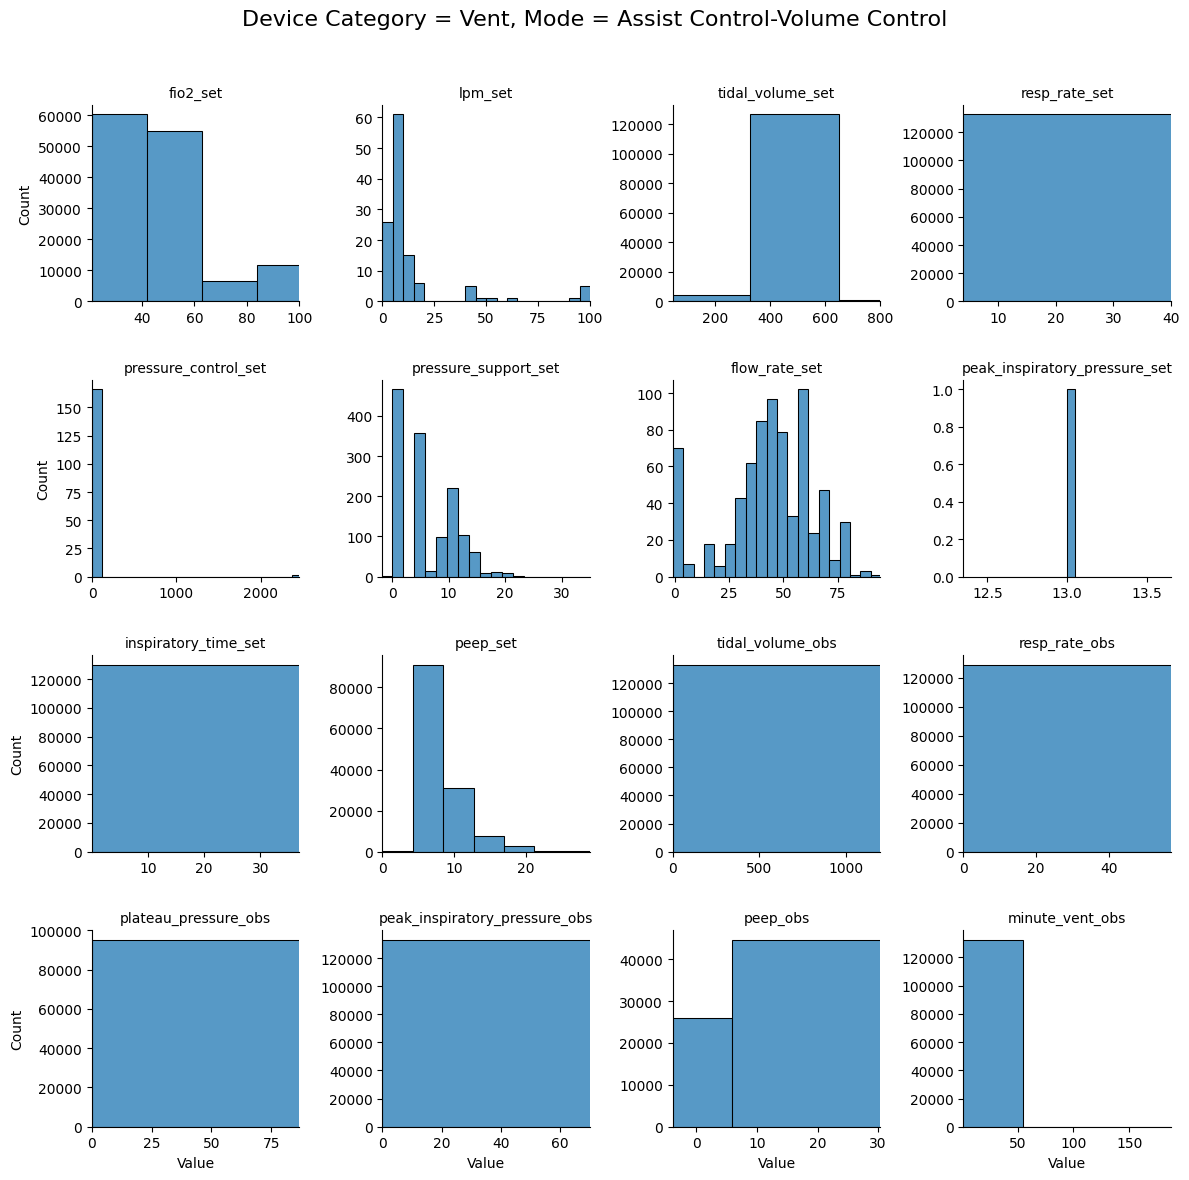

In [ ]:
plot_histograms_by_device_category(resp_final, "Vent", "Assist Control-Volume Control")

## EDA

#### check duplicates

In [ ]:
resp_duplicates.query("itemid == 224696") 

NameError: name 'resp_duplicates' is not defined

In [ ]:
# 2166-07-19 23:50:00	2166-07-20 01:20:08
resp_events.query("stay_id == 39214730").sort_values("time")

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
297729518,19529415,26871621,39214730,2166-07-20 00:00:00,223848,Drager,None,device_name
297729520,19529415,26871621,39214730,2166-07-20 00:00:00,224700,8,cmH2O,peep_obs
297729523,19529415,26871621,39214730,2166-07-20 00:00:00,226732,Tracheostomy tube,None,device_name
297729519,19529415,26871621,39214730,2166-07-20 00:00:00,224696,35,cmH2O,plateau_pressure_obs
297729546,19529415,26871621,39214730,2166-07-20 00:17:00,224738,0.6,sec,inspiratory_time_set
297729542,19529415,26871621,39214730,2166-07-20 00:17:00,224690,28,insp/min,resp_rate_obs
297729544,19529415,26871621,39214730,2166-07-20 00:17:00,224695,45,cmH2O,peak_inspiratory_pressure_obs
297729537,19529415,26871621,39214730,2166-07-20 00:17:00,224684,400,mL,tidal_volume_set
297729539,19529415,26871621,39214730,2166-07-20 00:17:00,224687,14.8,L/min,minute_vent_obs
297729538,19529415,26871621,39214730,2166-07-20 00:17:00,224685,421,mL,tidal_volume_obs


In [ ]:
# 2166-07-20 04:34:07 -> 2166-07-21 18:06:26
resp_events.query("stay_id == 36123037").sort_values("time").head(30)

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
297727600,19529415,26871621,36123037,2166-07-20 01:00:00,226732,Tracheostomy tube,None,device_name
297727606,19529415,26871621,36123037,2166-07-20 01:00:00,224700,12,cmH2O,peep_obs
297727605,19529415,26871621,36123037,2166-07-20 01:00:00,224696,26,cmH2O,plateau_pressure_obs
297727595,19529415,26871621,36123037,2166-07-20 01:00:00,223848,Drager,None,device_name
297727694,19529415,26871621,36123037,2166-07-20 01:21:00,220210,36,insp/min,resp_rate_obs
297727627,19529415,26871621,36123037,2166-07-20 01:21:00,223835,60,None,fio2_set
297727626,19529415,26871621,36123037,2166-07-20 01:21:00,220339,10,cmH2O,peep_set
297727632,19529415,26871621,36123037,2166-07-20 01:21:00,224685,366,mL,tidal_volume_obs
297727633,19529415,26871621,36123037,2166-07-20 01:21:00,224687,11,L/min,minute_vent_obs
297727637,19529415,26871621,36123037,2166-07-20 01:21:00,224695,31,cmH2O,peak_inspiratory_pressure_obs


In [ ]:
icustays.query("hadm_id == 26871621") 

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
69624,19529415,26871621,36123037,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2166-07-20 04:34:07,2166-07-21 18:06:26,1.564109
69625,19529415,26871621,39214730,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2166-07-19 23:50:00,2166-07-20 01:20:08,0.062593


In [ ]:
# find the time ranges for the two stays, and see which stay should the 1 am measurement fall into
# so should be stay_id == 39214730
transfers.query("hadm_id == 26871621").sort_values("intime")

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
1801138,19529415,26871621.0,31849044,ED,Emergency Department,2166-07-19 21:05:00,2166-07-19 23:50:00
1801142,19529415,26871621.0,39214730,admit,Cardiac Vascular Intensive Care Unit (CVICU),2166-07-19 23:50:00,2166-07-20 01:20:08
1801141,19529415,26871621.0,38963722,transfer,Discharge Lounge,2166-07-20 01:20:08,2166-07-20 04:34:07
1801140,19529415,26871621.0,36123037,transfer,Cardiac Vascular Intensive Care Unit (CVICU),2166-07-20 04:34:07,2166-07-21 18:06:26
1801139,19529415,26871621.0,34433983,discharge,NaN,2166-07-21 18:06:26,NaN


# `position` table

In [ ]:
ItemFinder("position").make_candidate_table()

2024-10-22 10:13:57,333:INFO:33 matching item(s) found.


2024-10-22 10:14:01,332:INFO:type is <class 'pandas.core.series.Series'>
2024-10-22 10:14:01,338:INFO:the label for item 224093 is Position
2024-10-22 10:14:01,341:INFO:the param_type for item 224093 (Position) is Text
2024-10-22 10:14:02,141:INFO:the label for item 227952 is Position Change
2024-10-22 10:14:02,144:INFO:the param_type for item 227952 (Position Change) is Text


item label: Position; value instances: {'Supine': 673483, 'Right Side': 659692, 'Left Side': 649350, 'Rotating': 188390, 'Sitting': 98982, 'Prone': 2457, 'Reverse T-berg': 2224, 'Swimmers Position - L ': 1068, 'Swimmers Position - R': 828}


2024-10-22 10:14:02,590:INFO:the label for item 225988 is IABP Position on leg
2024-10-22 10:14:02,593:INFO:the param_type for item 225988 (IABP Position on leg) is Text


item label: Position Change; value instances: {'Done': 742661, 'Not Done': 12548}


2024-10-22 10:14:02,864:INFO:the label for item 227809 is ETT Position Change
2024-10-22 10:14:02,867:INFO:the param_type for item 227809 (ETT Position Change) is Checkbox
2024-10-22 10:14:02,870:INFO:the label for item 224066 is Position Change
2024-10-22 10:14:02,872:INFO:the param_type for item 224066 (Position Change) is Text


item label: IABP Position on leg; value instances: {'Sutured': 7191, 'Marked': 6825, 'Aligned': 5839}


2024-10-22 10:14:03,152:INFO:the label for item 229273 is Flow Sensor repositioned (ECMO)
2024-10-22 10:14:03,155:INFO:the param_type for item 229273 (Flow Sensor repositioned (ECMO)) is Text


item label: Position Change; value instances: {'Done': 14913, 'Not Done': 258}


2024-10-22 10:14:03,439:INFO:the label for item 228173 is Impella Position
2024-10-22 10:14:03,442:INFO:the param_type for item 228173 (Impella Position) is Text


item label: Flow Sensor repositioned (ECMO); value instances: {'No': 4723, 'Yes': 1951}


2024-10-22 10:14:03,706:INFO:the label for item 229560 is Cardiac Assist Cannula Position
2024-10-22 10:14:03,709:INFO:the param_type for item 229560 (Cardiac Assist Cannula Position) is Text


item label: Impella Position; value instances: {'Sutured': 1629, 'Marked': 1149, 'Aligned': 1096}


2024-10-22 10:14:03,971:INFO:the label for item 228162 is Impella Catheter Position
2024-10-22 10:14:03,974:INFO:the param_type for item 228162 (Impella Catheter Position) is Numeric


item label: Cardiac Assist Cannula Position; value instances: {'Sutured': 1310, 'Marked': 534, 'Aligned': 455}


2024-10-22 10:14:04,249:INFO:the label for item 229261 is Flow Sensor repositioned (RVAD)
2024-10-22 10:14:04,253:INFO:the param_type for item 229261 (Flow Sensor repositioned (RVAD)) is Text


item label: Impella Catheter Position; value instances: Max: 107.0, Min: 33.0, Mean: 75.02


2024-10-22 10:14:04,530:INFO:the label for item 229416 is Disposition
2024-10-22 10:14:04,533:INFO:the param_type for item 229416 (Disposition) is Text


item label: Flow Sensor repositioned (RVAD); value instances: {'No': 925, 'Yes': 428}


2024-10-22 10:14:04,808:INFO:the label for item 228210 is Tandem Heart Access Line Position
2024-10-22 10:14:04,812:INFO:the param_type for item 228210 (Tandem Heart Access Line Position) is Text


item label: Disposition; value instances: {'Remain in ICU': 793, 'Discharge to floor': 107, 'Discharge to stepdown unit': 17, 'Discharge to other facility': 12, 'Discharge to home': 1}


2024-10-22 10:14:05,093:INFO:the label for item 229260 is Flow Sensor repositioned (LVAD)
2024-10-22 10:14:05,096:INFO:the param_type for item 229260 (Flow Sensor repositioned (LVAD)) is Text


item label: Tandem Heart Access Line Position; value instances: {'Sutured': 385, 'Marked': 253, 'Aligned': 201}


2024-10-22 10:14:05,361:INFO:the label for item 228223 is Tandem Heart Return Cannula Position
2024-10-22 10:14:05,364:INFO:the param_type for item 228223 (Tandem Heart Return Cannula Position) is Text


item label: Flow Sensor repositioned (LVAD); value instances: {'No': 630, 'Yes': 174}


2024-10-22 10:14:05,628:INFO:the label for item 228163 is Impella Catheter Repositioned
2024-10-22 10:14:05,631:INFO:the param_type for item 228163 (Impella Catheter Repositioned) is Checkbox
2024-10-22 10:14:05,634:INFO:the label for item 224392 is ETT Position Change
2024-10-22 10:14:05,637:INFO:the param_type for item 224392 (ETT Position Change) is Text


item label: Tandem Heart Return Cannula Position; value instances: {'Sutured': 360, 'Marked': 234, 'Aligned': 181}


2024-10-22 10:14:05,900:INFO:the label for item 228213 is Tandem Heart Access Line Repositioned
2024-10-22 10:14:05,903:INFO:the param_type for item 228213 (Tandem Heart Access Line Repositioned) is Checkbox
2024-10-22 10:14:05,906:INFO:the label for item 228224 is Tandem Heart Return Cannula Repositioned
2024-10-22 10:14:05,909:INFO:the param_type for item 228224 (Tandem Heart Return Cannula Repositioned) is Checkbox
2024-10-22 10:14:05,911:INFO:the label for item 229554 is Avalon Position
2024-10-22 10:14:05,914:INFO:the param_type for item 229554 (Avalon Position) is Text


item label: ETT Position Change; value instances: {'Done': 392, 'Not Done': 67}


2024-10-22 10:14:06,178:INFO:the label for item 227915 is Position - Rest - Aerobic Activity Response
2024-10-22 10:14:06,181:INFO:the param_type for item 227915 (Position - Rest - Aerobic Activity Response) is Text


item label: Avalon Position; value instances: {'Sutured': 136, 'Marked': 33, 'Aligned': 32}


2024-10-22 10:14:06,448:INFO:the label for item 229548 is EKOS Position
2024-10-22 10:14:06,452:INFO:the param_type for item 229548 (EKOS Position) is Text


item label: Position - Rest - Aerobic Activity Response; value instances: {'Supine': 137, 'Sit': 22, 'Stand': 1}


2024-10-22 10:14:06,721:INFO:the label for item 227922 is Position - Activity - Aerobic Activity Response
2024-10-22 10:14:06,724:INFO:the param_type for item 227922 (Position - Activity - Aerobic Activity Response) is Text


item label: EKOS Position; value instances: {'Sutured': 80, 'Aligned': 30, 'Marked': 28}


2024-10-22 10:14:06,985:INFO:the label for item 227929 is Position - Recovery - Aerobic Activity Response
2024-10-22 10:14:06,988:INFO:the param_type for item 227929 (Position - Recovery - Aerobic Activity Response) is Text


item label: Position - Activity - Aerobic Activity Response; value instances: {'Sit ': 83, 'Stand': 14, 'Supine ': 12}


2024-10-22 10:14:07,256:INFO:the label for item 229874 is Flow Sensor repositioned (CH)
2024-10-22 10:14:07,259:INFO:the param_type for item 229874 (Flow Sensor repositioned (CH)) is Text


item label: Position - Recovery - Aerobic Activity Response; value instances: {'Sit': 55, 'Supine': 43, 'Stand': 2}


2024-10-22 10:14:07,526:INFO:the label for item 229863 is Forehead Sensor Position Changed
2024-10-22 10:14:07,529:INFO:the param_type for item 229863 (Forehead Sensor Position Changed) is Checkbox
2024-10-22 10:14:07,532:INFO:the label for item 224495 is Patient position (LP)
2024-10-22 10:14:07,535:INFO:the param_type for item 224495 (Patient position (LP)) is Text


item label: Flow Sensor repositioned (CH); value instances: {'No': 59}


2024-10-22 10:14:07,777:INFO:the label for item 225245 is Patient position (THCEN)
2024-10-22 10:14:07,780:INFO:the param_type for item 225245 (Patient position (THCEN)) is Text


item label: Patient position (LP); value instances: {}


2024-10-22 10:14:08,006:INFO:the label for item 225277 is ETT Position (cm at teeth)
2024-10-22 10:14:08,009:INFO:the param_type for item 225277 (ETT Position (cm at teeth)) is Numeric


item label: Patient position (THCEN); value instances: {}


2024-10-22 10:14:08,229:INFO:the label for item 225285 is Catheter repositioned (PICC)
2024-10-22 10:14:08,232:INFO:the param_type for item 225285 (Catheter repositioned (PICC)) is Text


item label: ETT Position (cm at teeth); value instances: Max: nan, Min: nan, Mean: nan


2024-10-22 10:14:08,453:INFO:the label for item 228474 is Patient Position (Gen Proc)
2024-10-22 10:14:08,456:INFO:the param_type for item 228474 (Patient Position (Gen Proc)) is Text


item label: Catheter repositioned (PICC); value instances: {}


2024-10-22 10:14:08,680:INFO:the label for item 229497 is Final Position confirmed (SBNET)
2024-10-22 10:14:08,683:INFO:the param_type for item 229497 (Final Position confirmed (SBNET)) is Text


item label: Patient Position (Gen Proc); value instances: {}


2024-10-22 10:14:08,904:INFO:the label for item 229503 is Trendelenburg position during insertion (CVL)
2024-10-22 10:14:08,907:INFO:the param_type for item 229503 (Trendelenburg position during insertion (CVL)) is Text


item label: Final Position confirmed (SBNET); value instances: {}


2024-10-22 10:14:09,133:INFO:the label for item 230032 is Flow Sensor repositioned (Tandem)
2024-10-22 10:14:09,136:INFO:the param_type for item 230032 (Flow Sensor repositioned (Tandem)) is Text


item label: Trendelenburg position during insertion (CVL); value instances: {}
item label: Flow Sensor repositioned (Tandem); value instances: {}


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
550,224093,Position,Position,chartevents,Treatments,NaN,Text,2276474.0,"{'Supine': 673483, 'Right Side': 659692, 'Left..."
2520,227952,Position Change,Position Change,chartevents,Restraint/Support Systems,NaN,Text,755209.0,"{'Done': 742661, 'Not Done': 12548}"
1683,225988,IABP Position on leg,IABP Position on leg,chartevents,Access Lines - Invasive,NaN,Text,19855.0,"{'Sutured': 7191, 'Marked': 6825, 'Aligned': 5..."
2460,227809,ETT Position Change,ETT Position Change,chartevents,Respiratory,NaN,Checkbox,19393.0,Checkbox
527,224066,Position Change,Position Change,chartevents,Restraint/Support Systems,NaN,Text,15171.0,"{'Done': 14913, 'Not Done': 258}"
3500,229273,Flow Sensor repositioned (ECMO),Flow Sensor repositioned (ECMO),chartevents,ECMO,NaN,Text,6674.0,"{'No': 4723, 'Yes': 1951}"
2713,228173,Impella Position,Impella Position,chartevents,Access Lines - Invasive,NaN,Text,3874.0,"{'Sutured': 1629, 'Marked': 1149, 'Aligned': 1..."
3693,229560,Cardiac Assist Cannula Position,Cardiac Assist Cannula Position,chartevents,Access Lines - Invasive,NaN,Text,2299.0,"{'Sutured': 1310, 'Marked': 534, 'Aligned': 455}"
2702,228162,Impella Catheter Position,Impella Catheter Position,chartevents,Access Lines - Invasive,cm,Numeric,1800.0,"Max: 107.0, Min: 33.0, Mean: 75.02"
3488,229261,Flow Sensor repositioned (RVAD),Flow Sensor repositioned (RVAD),chartevents,Centrimag,NaN,Text,1353.0,"{'No': 925, 'Yes': 428}"


# `labs` table

## utils

In [ ]:
labs_col_names = [
    "hospitalization_id", "lab_order_dttm", "lab_collect_dttm", "lab_result_dttm", "lab_order_name",
    "lab_order_category", "lab_name", "lab_category", "lab_value", "lab_value_numeric",
    "reference_unit", "lab_specimen_name", "lab_specimen_category", "lab_loinc_code"
]

labs_col_rename_mapper_dict = {
    "label": "lab_name", "charttime": "lab_collect_dttm", "storetime": "lab_result_dttm", 
    "value": "lab_value", "valuenum": "lab_value_numeric", "valueuom": "reference_unit"
}

In [ ]:
# labs
labs_mapping = load_mapping_csv("labs")
labs_mapping.dropna(subset = ["itemid"], inplace = True)
labs_mapping["itemid"] = labs_mapping["itemid"].astype(int)
labs_id_to_category_mapper = construct_mapper_dict(labs_mapping, "itemid", "lab_category")

In [ ]:
nona = labs_mapping["itemid"].dropna()
nona

0      50862
1      51069
2      51070
3      50835
4      51046
       ...  
116    52623
117    50976
118    51003
119    52642
120    51300
Name: itemid, Length: 120, dtype: int64

In [ ]:
import molmass, pint

In [ ]:
def item_id_to_uom_instances_categorical(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Return all the unique categories
    '''
    print(f"checking lab item {item_id}")
    assoc_events = events.loc[events["itemid"] == item_id, :]
    categories = assoc_events.value_counts("valueuom").to_dict()
    return str(categories)

In [ ]:
def gen_lab_item_candidate_table(kw, blood_only = True, 
                                 case = False):  
    lab_items_select = d_labitems[d_labitems["label"].str.contains(kw,case=case, na=False)]
    if blood_only:
        lab_items_select = lab_items_select[(d_labitems["fluid"] == "Blood")]
    
    lab_counts = labevents.value_counts("itemid")
    lab_counts.name = "count"
    
    lab_items_cand = (
        lab_items_select
        .join(lab_counts, on = "itemid")
        .loc[lambda df: df["count"].notna(), :]
        .sort_values("count", ascending=False)
    )
    
    # add values instances
    lab_items_cand["value_instances"] = lab_items_cand["itemid"].apply(
        lambda x: item_id_to_value_instances_numeric(x, labevents)
        )

    # add valueuom instances
    lab_items_cand["uom_instances"] = lab_items_cand["itemid"].apply(
        lambda x: item_id_to_uom_instances_categorical(x, labevents)
        )
    
    return lab_items_cand

In [ ]:
labs_mapping.head()

,lab_category,decision,itemid,label,abbreviation,fluid,category,count,value_instances,uom_instances,target_uom,status,note
0,albumin,"TO MAP, AS IS",50862,Albumin,NaN,Blood,Chemistry,749944.0,"Max: 36.0, Min: 0.2, Mean: 3.78",{'g/dL': 749944},g/dL,existing mapping validated by K. Smith,NaN
1,albumin,NO MAPPING,51069,"Albumin, Urine",NaN,Urine,Chemistry,56977.0,"Max: 2634.0, Min: 0.0, Mean: 24.43",{'mg/dL': 56977},NaN,existing mapping validated by K. Smith,All urine samples are excluded.
2,albumin,NO MAPPING,51070,"Albumin/Creatinine, Urine",NaN,Urine,Chemistry,54939.0,"Max: 46518.8, Min: 0.0, Mean: 282.24",{'mg/g': 54931},NaN,existing mapping validated by K. Smith,NaN
3,albumin,NO MAPPING,50835,"Albumin, Ascites",NaN,Ascites,Chemistry,6012.0,"Max: 48.0, Min: 0.1, Mean: 1.38",{'g/dL': 6012},NaN,existing mapping validated by K. Smith,NaN
4,albumin,NO MAPPING,51046,"Albumin, Pleural",NaN,Pleural,Chemistry,4593.0,"Max: 3800.0, Min: 0.2, Mean: 2.86",{'g/dL': 4593},NaN,existing mapping validated by K. Smith,NaN


In [ ]:
labs_items = labs_mapping.loc[
    labs_mapping["decision"].isin(["TO MAP, CONVERT UOM", "TO MAP, AS IS", "UNSURE"]),
    ["lab_category", "itemid", "label", "count"]
].copy()
labs_items

,lab_category,itemid,label,count
0,albumin,50862,Albumin,749944.0
10,alkaline_phosphatase,50863,Alkaline Phosphatase,1171421.0
12,alt,50861,Alanine Aminotransferase (ALT),1348729.0
13,ast,50878,Asparate Aminotransferase (AST),1321132.0
14,basophils_percent,51146,Basophils,1241587.0
...,...,...,...,...
116,sodium,52623,Sodium,402.0
117,total_protein,50976,"Protein, Total",159912.0
118,troponin_t,51003,Troponin T,359000.0
119,troponin_i,52642,Troponin I,163.0


In [ ]:
labs_id_to_name_mapper = dict(zip(labs_items['itemid'], labs_items['label']))
labs_id_to_name_mapper

{50862: 'Albumin',
 50863: 'Alkaline Phosphatase',
 50861: 'Alanine Aminotransferase (ALT)',
 50878: 'Asparate Aminotransferase (AST)',
 51146: 'Basophils',
 52069: 'Absolute Basophil Count',
 50885: 'Bilirubin, Total',
 50883: 'Bilirubin, Direct',
 50884: 'Bilirubin, Indirect',
 51006: 'Urea Nitrogen',
 52647: 'Urea Nitrogen',
 50893: 'Calcium, Total',
 50808: 'Free Calcium',
 51624: 'Free Calcium',
 51739: 'Total CO2',
 50882: 'Bicarbonate',
 50902: 'Chloride',
 50806: 'Chloride, Whole Blood',
 52535: 'Chloride',
 50912: 'Creatinine',
 52024: 'Creatinine, Whole Blood',
 52546: 'Creatinine',
 51652: 'High-Sensitivity CRP',
 50889: 'C-Reactive Protein',
 51200: 'Eosinophils',
 51288: 'Sedimentation Rate',
 50924: 'Ferritin',
 50931: 'Glucose',
 50809: 'Glucose',
 52569: 'Glucose',
 51222: 'Hemoglobin',
 50811: 'Hemoglobin',
 51645: 'Hemoglobin, Calculated',
 50970: 'Phosphate',
 51237: 'INR(PT)',
 51675: 'INR(PT)',
 50813: 'Lactate',
 53154: 'Lactate',
 50954: 'Lactate Dehydrogenase (L

### unit conversion

In [ ]:
# lab items that need unit conversion -- which are all from labevents, not chartevents
labs_items_to_convert = labs_mapping.loc[
    labs_mapping["decision"].isin(["TO MAP, CONVERT UOM"]),
].copy()
labs_items_to_convert.drop(columns = ["decision", "fluid", # "category", 
                                      "value_instances", "abbreviation", "status", "note"], inplace = True)
labs_items_to_convert["original_uom"] = labs_items_to_convert["uom_instances"].apply(
    lambda x: list(eval(x).keys())[0] if pd.notna(x) else None
    )
labs_items_to_convert

,lab_category,itemid,label,category,count,uom_instances,target_uom,original_uom
38,calcium_ionized,50808,Free Calcium,Blood Gas,281355.0,{'mmol/L': 281355},mg/dL,mmol/L
41,calcium_ionized,51624,Free Calcium,Chemistry,368.0,{'mmol/L': 368},mg/dL,mmol/L
44,bicarbonate,51739,Total CO2,Chemistry,367.0,{'mEq/L': 367},mmol/L,mEq/L
50,bicarbonate,50882,Bicarbonate,Chemistry,3934240.0,{'mEq/L': 3934239},mmol/L,mEq/L
52,chloride,50902,Chloride,Chemistry,3083705.0,{'mEq/L': 3083705},mmol/L,mEq/L
53,chloride,50806,"Chloride, Whole Blood",Blood Gas,84527.0,{'mEq/L': 84527},mmol/L,mEq/L
55,chloride,52535,Chloride,Chemistry,369.0,{'mEq/L': 369},mmol/L,mEq/L
101,potassium,50971,Potassium,Chemistry,3150261.0,{'mEq/L': 3150261},mmol/L,mEq/L
102,potassium,50822,"Potassium, Whole Blood",Blood Gas,247306.0,{'mEq/L': 247306},mmol/L,mEq/L
103,potassium,52610,Potassium,Chemistry,402.0,{'mEq/L': 402},mmol/L,mEq/L


## ETL

### from `labevents`

In [ ]:
labs_items_le = labs_items[labs_items['itemid'].astype(str).str.len() == 5]
labs_items_le.head()

,lab_category,itemid,label,count
0,albumin,50862,Albumin,749944.0
10,alkaline_phosphatase,50863,Alkaline Phosphatase,1171421.0
12,alt,50861,Alanine Aminotransferase (ALT),1348729.0
13,ast,50878,Asparate Aminotransferase (AST),1321132.0
14,basophils_percent,51146,Basophils,1241587.0


In [ ]:
labs_items_le.dtypes

lab_category     object
itemid            int64
label            object
count           float64
dtype: object

In [ ]:
labs_events_le = labevents.loc[
    labevents['itemid'].isin(labs_items_le['itemid']),
].copy()
labs_events_le.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,2704548,50931,P69FQC,2180-03-23 11:51:00,2180-03-23 15:56:00,___,95.0,mg/dL,70.0,100.0,None,ROUTINE,"IF FASTING, 70-100 NORMAL, >125 PROVISIONAL DI..."
10,11,10000032,NaN,83925500,50861,P69FQC,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102.0,IU/L,0.0,40.0,abnormal,ROUTINE,None
11,12,10000032,NaN,83925500,50862,P69FQC,2180-03-23 11:51:00,2180-03-23 16:40:00,3.3,3.3,g/dL,3.5,5.2,abnormal,ROUTINE,None
12,13,10000032,NaN,83925500,50863,P69FQC,2180-03-23 11:51:00,2180-03-23 16:40:00,109,109.0,IU/L,35.0,105.0,abnormal,ROUTINE,None
15,16,10000032,NaN,83925500,50878,P69FQC,2180-03-23 11:51:00,2180-03-23 16:40:00,143,143.0,IU/L,0.0,40.0,abnormal,ROUTINE,None


In [ ]:
labs_events_le["lab_name"] = labs_events_le["itemid"].map(labs_id_to_name_mapper)
labs_events_le["lab_category"] = labs_events_le["itemid"].map(labs_id_to_category_mapper)
labs_events_le_c = rename_and_reorder_cols(labs_events_le, labs_col_rename_mapper_dict, labs_col_names + ["itemid"])
labs_events_le_c.head()

,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code,itemid
0,NaN,NaN,2180-03-23 11:51:00,2180-03-23 15:56:00,NaN,NaN,Glucose,glucose_serum,___,95.0,mg/dL,NaN,NaN,NaN,50931
10,NaN,NaN,2180-03-23 11:51:00,2180-03-23 16:40:00,NaN,NaN,Alanine Aminotransferase (ALT),alt,102,102.0,IU/L,NaN,NaN,NaN,50861
11,NaN,NaN,2180-03-23 11:51:00,2180-03-23 16:40:00,NaN,NaN,Albumin,albumin,3.3,3.3,g/dL,NaN,NaN,NaN,50862
12,NaN,NaN,2180-03-23 11:51:00,2180-03-23 16:40:00,NaN,NaN,Alkaline Phosphatase,alkaline_phosphatase,109,109.0,IU/L,NaN,NaN,NaN,50863
15,NaN,NaN,2180-03-23 11:51:00,2180-03-23 16:40:00,NaN,NaN,Asparate Aminotransferase (AST),ast,143,143.0,IU/L,NaN,NaN,NaN,50878


In [ ]:
# very high missing rate of hospitalization_id -- had to drop them
print(labs_events_le_c['hospitalization_id'].isna().mean())
print(labevents['hadm_id'].isna().mean())

0.4009407957031852
0.46578694191455905


In [ ]:
labs_events_le_c.dropna(subset = "hospitalization_id", inplace = True)
labs_events_le_c.head()

,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code,itemid
130,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:22:00,NaN,NaN,Hemoglobin,hemoglobin,12.7,12.7,g/dL,NaN,NaN,NaN,51222
134,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:22:00,NaN,NaN,Platelet Count,platelet_count,71,71.0,K/uL,NaN,NaN,NaN,51265
138,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:43:00,NaN,NaN,INR(PT),inr,1.5,1.5,None,NaN,NaN,NaN,51237
139,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:43:00,NaN,NaN,PT,pt,16.6,16.6,sec,NaN,NaN,NaN,51274
140,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:43:00,NaN,NaN,PTT,ptt,32.3,32.3,sec,NaN,NaN,NaN,51275


In [ ]:
# convert unit -- 
# for ionized (free) calcium, to convert a result from mmol/L to mg/dL, multiply the mmol/L value by 4.  
# https://www.abaxis.com/sites/default/files/resource-packages/Ionized%20Calcium%20CTI%20Sheete%20714179-00P.pdf
labs_events_le_c["lab_value_numeric"] = np.where(
    labs_events_le_c["itemid"].isin([50808, 51624]),
    labs_events_le_c["lab_value_numeric"]*4,
    labs_events_le_c["lab_value_numeric"]
)

labs_events_le_c["reference_unit"] = np.where(
    labs_events_le_c["itemid"].isin([50808, 51624]),
    "mg/dL",
    labs_events_le_c["reference_unit"]
)

labs_events_le_c["lab_value"] = np.where(
    labs_events_le_c["itemid"].isin([50808, 51624]),
    labs_events_le_c["lab_value_numeric"].astype(str),
    labs_events_le_c["lab_value"]
)

In [ ]:
# convert troponin_t and troponin_i from ng/mL to ng/L, which is to multiply by 1000
labs_events_le_c["lab_value_numeric"] = np.where(
    labs_events_le_c["itemid"].isin([51003, 52642]),
    labs_events_le_c["lab_value_numeric"]*1000,
    labs_events_le_c["lab_value_numeric"]
)

labs_events_le_c["reference_unit"] = np.where(
    labs_events_le_c["itemid"].isin([51003, 52642]),
    "ng/L",
    labs_events_le_c["reference_unit"]
)

labs_events_le_c["lab_value"] = np.where(
    labs_events_le_c["itemid"].isin([51003, 52642]),
    labs_events_le_c["lab_value_numeric"].astype(str),
    labs_events_le_c["lab_value"]
)

In [ ]:
labs_events_le_c.dtypes

hospitalization_id       float64
lab_order_dttm           float64
lab_collect_dttm          object
lab_result_dttm           object
lab_order_name           float64
lab_order_category       float64
lab_name                  object
lab_category              object
lab_value                 object
lab_value_numeric        float64
reference_unit            object
lab_specimen_name        float64
lab_specimen_category    float64
lab_loinc_code           float64
itemid                     int64
dtype: object

In [ ]:
# convert dtype

### from `chartevents`

In [ ]:
labs_items.dtypes

lab_category     object
itemid            int64
label            object
count           float64
dtype: object

In [ ]:
labs_items_ce = labs_items[labs_items['itemid'].astype(str).str.len() == 6]
labs_items_ce

,lab_category,itemid,label,count
90,pco2_arterial,220235,Arterial CO2 Pressure,305443.0
92,po2_arterial,220224,Arterial O2 pressure,305443.0
93,pco2_venous,226062,Venous CO2 Pressure,47319.0
95,ph_arterial,223830,PH (Arterial),316903.0
96,ph_venous,220274,PH (Venous),62600.0
108,so2_arterial,220227,Arterial O2 Saturation,87394.0
109,so2_mixed_venous,223772,SvO2,159559.0
110,so2_mixed_venous,225674,Mixed Venous O2% Sat,34044.0
111,so2_central_venous,227686,Central Venous O2% Sat,4083.0
112,so2_central_venous,227549,ScvO2 (Presep),2356.0


In [ ]:
labs_events_ce = item_ids_list_to_events_df(labs_items_ce['itemid'], original = True)
labs_events_ce.head()

2024-11-03 17:00:34,837:INFO:the linksto for item 220235 (Arterial CO2 Pressure) is chartevents
2024-11-03 17:00:35,362:INFO:the linksto for item 220224 (Arterial O2 pressure) is chartevents
2024-11-03 17:00:35,888:INFO:the linksto for item 226062 (Venous CO2 Pressure) is chartevents
2024-11-03 17:00:36,360:INFO:the linksto for item 223830 (PH (Arterial)) is chartevents
2024-11-03 17:00:36,888:INFO:the linksto for item 220274 (PH (Venous)) is chartevents


2024-11-03 17:00:37,362:INFO:the linksto for item 220227 (Arterial O2 Saturation) is chartevents
2024-11-03 17:00:37,843:INFO:the linksto for item 223772 (SvO2) is chartevents
2024-11-03 17:00:38,341:INFO:the linksto for item 225674 (Mixed Venous O2% Sat) is chartevents
2024-11-03 17:00:38,809:INFO:the linksto for item 227686 (Central Venous O2% Sat) is chartevents
2024-11-03 17:00:39,269:INFO:the linksto for item 227549 (ScvO2 (Presep)) is chartevents
2024-11-03 17:00:39,728:INFO:the linksto for item 226541 (ScvO2 Central Venous O2% Sat) is chartevents


,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
4238,10000690,25860671,37081114,NaN,2150-11-02 19:05:00,2150-11-02 19:07:00,220235,54,54.0,mmHg,1.0
23433,10001884,26184834,37510196,NaN,2131-01-12 21:04:00,2131-01-12 21:11:00,220235,60,60.0,mmHg,1.0
23440,10001884,26184834,37510196,NaN,2131-01-13 02:28:00,2131-01-13 02:31:00,220235,53,53.0,mmHg,1.0
23520,10001884,26184834,37510196,NaN,2131-01-14 07:05:00,2131-01-14 07:09:00,220235,49,49.0,mmHg,1.0
25343,10002013,23581541,39060235,NaN,2160-05-18 10:26:00,2160-05-18 10:29:00,220235,45,45.0,mmHg,0.0


In [ ]:
labs_events_ce["lab_name"] = labs_events_ce["itemid"].map(labs_id_to_name_mapper)
labs_events_ce["lab_category"] = labs_events_ce["itemid"].map(labs_id_to_category_mapper)
labs_events_ce_c = rename_and_reorder_cols(labs_events_ce, labs_col_rename_mapper_dict, labs_col_names)
labs_events_ce_c.head()

,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code
4238,25860671,NaN,2150-11-02 19:05:00,2150-11-02 19:07:00,NaN,NaN,Arterial CO2 Pressure,pco2_arterial,54,54.0,mmHg,NaN,NaN,NaN
23433,26184834,NaN,2131-01-12 21:04:00,2131-01-12 21:11:00,NaN,NaN,Arterial CO2 Pressure,pco2_arterial,60,60.0,mmHg,NaN,NaN,NaN
23440,26184834,NaN,2131-01-13 02:28:00,2131-01-13 02:31:00,NaN,NaN,Arterial CO2 Pressure,pco2_arterial,53,53.0,mmHg,NaN,NaN,NaN
23520,26184834,NaN,2131-01-14 07:05:00,2131-01-14 07:09:00,NaN,NaN,Arterial CO2 Pressure,pco2_arterial,49,49.0,mmHg,NaN,NaN,NaN
25343,23581541,NaN,2160-05-18 10:26:00,2160-05-18 10:29:00,NaN,NaN,Arterial CO2 Pressure,pco2_arterial,45,45.0,mmHg,NaN,NaN,NaN


### merge

In [ ]:
labs_events_f = pd.concat([labs_events_le_c, labs_events_ce_c])
labs_events_f.head()

,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code,itemid
130,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:22:00,NaN,NaN,Hemoglobin,hemoglobin,12.7,12.7,g/dL,NaN,NaN,NaN,51222.0
134,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:22:00,NaN,NaN,Platelet Count,platelet_count,71,71.0,K/uL,NaN,NaN,NaN,51265.0
138,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:43:00,NaN,NaN,INR(PT),inr,1.5,1.5,None,NaN,NaN,NaN,51237.0
139,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:43:00,NaN,NaN,PT,pt,16.6,16.6,sec,NaN,NaN,NaN,51274.0
140,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 06:43:00,NaN,NaN,PTT,ptt,32.3,32.3,sec,NaN,NaN,NaN,51275.0


In [ ]:
labs_events_f.dtypes

hospitalization_id       float64
lab_order_dttm           float64
lab_collect_dttm          object
lab_result_dttm           object
lab_order_name           float64
lab_order_category       float64
lab_name                  object
lab_category              object
lab_value                 object
lab_value_numeric        float64
reference_unit            object
lab_specimen_name        float64
lab_specimen_category    float64
lab_loinc_code           float64
itemid                   float64
dtype: object

In [ ]:
labs_events_f['hospitalization_id'].isna().mean()

0.0

In [ ]:
labs_events_f.drop(columns="itemid", inplace = True)
for col in labs_events_f.columns:
    print(f"processing column {col}")
    if "dttm" in col:
        labs_events_f[col] = pd.to_datetime(labs_events_f[col])
    elif ("order" in col) or ("specimen" in col) or ("loinc" in col):
        labs_events_f[col] = ""
    elif col == "hospitalization_id":
        labs_events_f[col] = labs_events_f[col].astype(int).astype(str)
    else:
        continue
labs_events_f.head()

processing column hospitalization_id
processing column lab_order_dttm
processing column lab_collect_dttm
processing column lab_result_dttm
processing column lab_order_name
processing column lab_order_category
processing column lab_name
processing column lab_category
processing column lab_value
processing column lab_value_numeric
processing column reference_unit
processing column lab_specimen_name
processing column lab_specimen_category
processing column lab_loinc_code


,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code
130,22595853,NaT,2180-05-07 05:05:00,2180-05-07 06:22:00,,,Hemoglobin,hemoglobin,12.7,12.7,g/dL,,,
134,22595853,NaT,2180-05-07 05:05:00,2180-05-07 06:22:00,,,Platelet Count,platelet_count,71,71.0,K/uL,,,
138,22595853,NaT,2180-05-07 05:05:00,2180-05-07 06:43:00,,,INR(PT),inr,1.5,1.5,None,,,
139,22595853,NaT,2180-05-07 05:05:00,2180-05-07 06:43:00,,,PT,pt,16.6,16.6,sec,,,
140,22595853,NaT,2180-05-07 05:05:00,2180-05-07 06:43:00,,,PTT,ptt,32.3,32.3,sec,,,


In [ ]:
labs_events_f.dtypes

hospitalization_id               object
lab_order_dttm           datetime64[ns]
lab_collect_dttm         datetime64[ns]
lab_result_dttm          datetime64[ns]
lab_order_name                   object
lab_order_category               object
lab_name                         object
lab_category                     object
lab_value                        object
lab_value_numeric               float64
reference_unit                   object
lab_specimen_name                object
lab_specimen_category            object
lab_loinc_code                   object
dtype: object

### validation

In [ ]:
labs_events_f.drop_duplicates(
    subset = ["hospitalization_id", "lab_collect_dttm", "lab_category", "lab_value_numeric"],
    inplace = True)

In [ ]:
labs_dups = labs_events_f[
    labs_events_f.duplicated(
        subset = ["hospitalization_id", "lab_collect_dttm", "lab_result_dttm", "lab_category"], 
        keep = False)
]

In [ ]:
labs_dups_sorted = labs_dups.sort_values(["hospitalization_id", "lab_collect_dttm", "lab_category"])
labs_dups_sorted

,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code
22092139,20012928,NaT,2123-03-02 04:45:00,2123-03-02 05:48:00,,,Hemoglobin,hemoglobin,7.7,7.7,g/dL,,,
22092159,20012928,NaT,2123-03-02 04:45:00,2123-03-02 05:48:00,,,Hemoglobin,hemoglobin,7.6,7.6,g/dL,,,
22092143,20012928,NaT,2123-03-02 04:45:00,2123-03-02 05:48:00,,,Platelet Count,platelet_count,148,148.0,K/uL,,,
22092163,20012928,NaT,2123-03-02 04:45:00,2123-03-02 05:48:00,,,Platelet Count,platelet_count,139,139.0,K/uL,,,
57039465,20025172,NaT,2139-12-01 08:38:00,2139-12-01 10:31:00,,,Hemoglobin,hemoglobin,7.7,7.7,g/dL,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94941040,29983564,NaT,2128-06-07 06:47:00,2128-06-07 08:42:00,,,PT,pt,12.3,12.3,sec,,,
94941014,29983564,NaT,2128-06-07 06:47:00,2128-06-07 08:42:00,,,PTT,ptt,28.4,28.4,sec,,,
94941041,29983564,NaT,2128-06-07 06:47:00,2128-06-07 08:42:00,,,PTT,ptt,28.7,28.7,sec,,,
280744598,29984509,NaT,2158-10-22 12:00:00,2158-10-22 12:04:00,,,SvO2,so2_mixed_venous,46,46.0,%,,,


In [ ]:
labs_dups_sorted.value_counts(["lab_category"])

lab_category        
so2_arterial            589
hemoglobin              580
po2_arterial            356
ph_arterial             342
pco2_arterial           342
platelet_count          340
ptt                     290
pt                      132
bun                     108
glucose_serum           103
potassium                98
sodium                   82
calcium_total            70
chloride                 66
bicarbonate              60
phosphate                53
creatinine               52
ldh                      44
inr                      40
alt                      26
magnesium                26
troponin_t               22
so2_mixed_venous         20
alkaline_phosphatase     18
bilirubin_total          18
ast                      16
crp                      16
ferritin                 12
albumin                  12
lactate                   8
monocytes_percent         6
basophils_percent         6
lymphocytes_percent       6
neutrophils_percent       6
total_protein             6

In [ ]:
save_to_rclif(labs_events_f, "labs")

## EDA

In [ ]:
gen_lab_item_candidate_table("Troponin")

/tmp/ipykernel_28295/2762077509.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lab_items_select = lab_items_select[(d_labitems["fluid"] == "Blood")]


checking lab item 51003
checking lab item 52642


,itemid,label,fluid,category,count,value_instances,uom_instances
199,51003,Troponin T,Blood,Chemistry,459872.0,"Max: 52.4, Min: 0.0, Mean: 0.47",{'ng/mL': 459872}
1528,52642,Troponin I,Blood,Chemistry,670.0,"Max: 5.51, Min: 0.0, Mean: 0.05",{'ng/mL': 670}


In [ ]:
ItemFinder("Troponin", for_labs = True).candidate_table

2024-11-02 12:20:06,368:INFO:1 matching item(s) found for Troponin.
2024-11-02 12:20:08,242:INFO:the label for item 227429 is Troponin-T
2024-11-02 12:20:08,245:INFO:the param_type for item 227429 (Troponin-T) is Numeric with tag


,itemid,label,abbreviation,linksto,category,count,value_instances,unitname
2198,227429,Troponin-T,Troponin-T,chartevents,Labs,69340,Numeric with tag,None


In [ ]:
gen_lab_item_candidate_table("bicarbonate")

/tmp/ipykernel_28295/2762077509.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lab_items_select = lab_items_select[(d_labitems["fluid"] == "Blood")]


checking lab item 50882
checking lab item 50803


,itemid,label,fluid,category,count,value_instances,uom_instances
80,50882,Bicarbonate,Blood,Chemistry,3934240,"Max: 132.0, Min: 2.0, Mean: 25.27",{'mEq/L': 3934239}
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas,32994,"Max: 220.0, Min: 2.0, Mean: 23.58",{'mEq/L': 32994}


In [ ]:
ItemFinder("bicarbonate", for_labs=True).candidate_table

2024-11-02 12:33:26,767:INFO:5 matching item(s) found for bicarbonate.


,itemid,label,abbreviation,linksto,category,count,value_instances,unitname
214,220995,Sodium Bicarbonate 8.4%,Sodium Bicarbonate 8.4%,inputevents,Medications,10203.0,Solution,mEq
2263,227533,Sodium Bicarbonate 8.4% (Amp),Sodium Bicarbonate 8.4% (Amp),inputevents,Fluids/Intake,6646.0,Solution,mL
213,220994,Bicarbonate (ingr),ZHCO3,ingredientevents,Ingredients - general (Not In Use),NaN,Ingredient,mg
269,221211,"Sodium Bicarbonate 1,4%","NaBic 1,4%",inputevents,Fluids - Other (Not In Use),NaN,Solution,mL
1120,225165,Bicarbonate Base,Bicarbonate Base,inputevents,Fluids/Intake,NaN,Solution,mL


In [ ]:
ItemFinder("PH", case_sensitive=True, for_labs=True).candidate_table

2024-08-13 23:35:58,203:INFO:8 matching item(s) found.


2024-08-13 23:36:01,141:INFO:type is <class 'pandas.core.series.Series'>
2024-08-13 23:36:01,148:INFO:the label for item 223830 is PH (Arterial)
2024-08-13 23:36:01,150:INFO:the param_type for item 223830 (PH (Arterial)) is Numeric
2024-08-13 23:36:01,493:INFO:the label for item 220274 is PH (Venous)
2024-08-13 23:36:01,496:INFO:the param_type for item 220274 (PH (Venous)) is Numeric


item label: PH (Arterial); value instances: Max: 999999.0, Min: 0.0, Mean: 139.91


2024-08-13 23:36:01,798:INFO:the label for item 220734 is PH (dipstick)
2024-08-13 23:36:01,801:INFO:the param_type for item 220734 (PH (dipstick)) is Numeric


item label: PH (Venous); value instances: Max: 999999.0, Min: 0.0, Mean: 246.98


2024-08-13 23:36:02,096:INFO:the label for item 223259 is Insulin - NPH
2024-08-13 23:36:02,099:INFO:the param_type for item 223259 (Insulin - NPH) is Solution
2024-08-13 23:36:02,101:INFO:the label for item 226769 is PHApacheIIValue
2024-08-13 23:36:02,104:INFO:the param_type for item 226769 (PHApacheIIValue) is Numeric


item label: PH (dipstick); value instances: Max: 9.0, Min: 5.0, Mean: 5.97


2024-08-13 23:36:02,389:INFO:the label for item 227038 is PHPaCO2Score_ApacheIV
2024-08-13 23:36:02,392:INFO:the param_type for item 227038 (PHPaCO2Score_ApacheIV) is Numeric


item label: PHApacheIIValue; value instances: Max: 7.43, Min: 7.08, Mean: 7.23


2024-08-13 23:36:02,678:INFO:the label for item 227037 is PH_ApacheIV
2024-08-13 23:36:02,681:INFO:the param_type for item 227037 (PH_ApacheIV) is Numeric


item label: PHPaCO2Score_ApacheIV; value instances: Max: 9.0, Min: 0.0, Mean: 3.12


2024-08-13 23:36:02,966:INFO:the label for item 228243 is PH (SOFT)
2024-08-13 23:36:02,969:INFO:the param_type for item 228243 (PH (SOFT)) is Numeric


item label: PH_ApacheIV; value instances: Max: 7.52, Min: 7.24, Mean: 7.36
item label: PH (SOFT); value instances: Max: nan, Min: nan, Mean: nan


,itemid,label,abbreviation,linksto,category,count,value_instances,unitname
382,223830,PH (Arterial),PH (Arterial),chartevents,Labs,316903.0,"Max: 999999.0, Min: 0.0, Mean: 139.91",None
35,220274,PH (Venous),PH (Venous),chartevents,Labs,62600.0,"Max: 999999.0, Min: 0.0, Mean: 246.98",None
158,220734,PH (dipstick),PH (dipstick),chartevents,Labs,40988.0,"Max: 9.0, Min: 5.0, Mean: 5.97",None
325,223259,Insulin - NPH,Insulin - NPH,inputevents,Medications,7080.0,Solution,units
1979,226769,PHApacheIIValue,PHApacheIIValue,chartevents,Scores - APACHE II,14.0,"Max: 7.43, Min: 7.08, Mean: 7.23",None
2081,227038,PHPaCO2Score_ApacheIV,PHPaCO2Score_ApacheIV,chartevents,Scores - APACHE IV (2),8.0,"Max: 9.0, Min: 0.0, Mean: 3.12",None
2080,227037,PH_ApacheIV,PH_ApacheIV,chartevents,Scores - APACHE IV (2),5.0,"Max: 7.52, Min: 7.24, Mean: 7.36",None
2777,228243,PH (SOFT),PH (SOFT),chartevents,Labs,NaN,"Max: nan, Min: nan, Mean: nan",None


In [ ]:
item_id_to_events_df(223830)

2024-08-13 17:03:42,570:INFO:the linksto for item 223830 (PH (Arterial)) is chartevents


,subject_id,hadm_id,stay_id,time,itemid,value,valueuom
18842,10001884,26184834,37510196,2131-01-12 21:04:00,223830,7.38,units
18849,10001884,26184834,37510196,2131-01-13 02:28:00,223830,7.42,units
18929,10001884,26184834,37510196,2131-01-14 07:05:00,223830,7.46,units
20752,10002013,23581541,39060235,2160-05-18 10:26:00,223830,7.35,units
20765,10002013,23581541,39060235,2160-05-18 11:23:00,223830,7.4,units
...,...,...,...,...,...,...,...
313642192,19999840,21033226,38978960,2164-09-15 16:30:00,223830,7.4,units
313642265,19999840,21033226,38978960,2164-09-17 08:11:00,223830,7.42,units
313642307,19999840,21033226,38978960,2164-09-17 13:34:00,223830,7.27,units
313645025,19999987,23865745,36195440,2145-11-03 05:28:00,223830,7.39,units


In [ ]:
labevents[labevents["itemid"] == 50828].value_counts("value")

value
CONTROLLED.     42556
SPONTANEOUS.    13534
IMV.              567
dtype: int64

In [ ]:
o2_items = ItemFinder("O2", for_labs = True).candidate_table

2024-08-14 00:14:03,886:INFO:63 matching item(s) found.


2024-08-14 00:14:09,081:INFO:type is <class 'pandas.core.series.Series'>


,itemid,label,abbreviation,linksto,category,count,value_instances,unitname
36,220277,O2 saturation pulseoxymetry,SpO2,chartevents,Respiratory,6324341.0,"Max: 9900000.0, Min: -272.0, Mean: 104.83",%
1946,226732,O2 Delivery Device(s),O2 Delivery Device(s),chartevents,Respiratory,1536870.0,"{'Endotracheal tube': 467931, 'Nasal cannula':...",NaN
384,223835,Inspired O2 Fraction,FiO2,chartevents,Respiratory,849875.0,"Max: 10050.0, Min: 0.0, Mean: 48.95",None
346,223770,O2 Saturation Pulseoxymetry Alarm - Low,SpO2 Alarm - Low,chartevents,Alarms,622764.0,"Max: 9210080.0, Min: -92.0, Mean: 108.74",%
345,223769,O2 Saturation Pulseoxymetry Alarm - High,SpO2 Alarm - High,chartevents,Alarms,619601.0,"Max: 100185.0, Min: 0.0, Mean: 102.25",%
...,...,...,...,...,...,...,...,...
2007,226863,PVR %O2 Saturation (PA Line),PVR %O2 Saturation (PA Line),chartevents,PA Line Insertion,NaN,"Max: nan, Min: nan, Mean: nan",dynes*sec/cm5
2008,226865,SVR %O2 Saturation (PA Line),SVR %O2 Saturation (PA Line),chartevents,PA Line Insertion,NaN,"Max: nan, Min: nan, Mean: nan",dynes*sec/cm5
2052,227009,FiO2_ApacheIV_old,FiO2_ApacheIV_old,chartevents,Scores - APACHE IV (2),NaN,"Max: nan, Min: nan, Mean: nan",None
2376,227685,ZCentral Venous O2% Sat,ZCentral Venous O2% Sat,chartevents,Labs,NaN,"Max: nan, Min: nan, Mean: nan",None


# `medication_admin_continuous` table

## utils

In [446]:
from fuzzywuzzy import process

In [447]:
# emar = load_mimic_table("hosp", "emar")
# emar_detail = load_mimic_table("hosp", "emar_detail")

In [448]:
mac_col_names = [
    "hospitalization_id", "med_order_id", "admin_dttm", "med_name", "med_category", "med_group", 
    "med_route_name", "med_route_category", "med_dose", "med_dose_unit", "mar_action_name", "mar_action_category"
]

mac_col_rename_mapper = {
    "dose": "med_dose",
    # "rateuom": "med_dose_unit",
    "amountuom": "med_dose_unit",
    "new_mar": "mar_action_name", 
    "linkorderid": "med_order_id",
    "recorded_dttm": "admin_dttm"
}

In [449]:
def map_name_to_category(name, categories):
    match, score = process.extractOne(name, categories)
    return match if score >= 80 else None

In [450]:
mac_mcide_url = "https://raw.githubusercontent.com/clif-consortium/CLIF/main/mCIDE/clif_medication_admin_continuous_med_categories.csv"
mac_mcide_mapping = pd.read_csv(mac_mcide_url)
mac_category_to_group_mapper = dict(zip(
    mac_mcide_mapping['med_category'], mac_mcide_mapping['med_group']
))

In [451]:
ats_meds_1 = [
    # all the vasoactives
    "norepinephrine", "epinephrine", "phenylephrine", "angiotensin",
    "vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol", "isoprenaline",
    # additional
    "nicardipine", "clevidipine", "cisatracurium"
]

ats_meds = ['fentanyl', 'propofol', 'lorazepam', 'midazolam','hydromorphone','morphine']

# ats_meds = ats_meds_1 + ats_meds_2

# find all the items that has these strings in their names, and return the ids:
ats_meds_items = pd.concat([
    ItemFinder(med_name, report_na=False).candidate_table for med_name in ats_meds
    ])
ats_meds_items.dropna(subset = "count", inplace = True)

2024-11-05 10:35:28,875:INFO:3 matching item(s) found for fentanyl.


2024-11-05 10:35:29,144:INFO:3 matching item(s) found for propofol.
2024-11-05 10:36:11,949:INFO:1 matching item(s) found for lorazepam.
2024-11-05 10:36:12,010:INFO:1 matching item(s) found for midazolam.
2024-11-05 10:36:12,099:INFO:1 matching item(s) found for hydromorphone.
2024-11-05 10:36:12,187:INFO:1 matching item(s) found for morphine.


In [452]:
ats_meds_items

,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
298,221744,Fentanyl,Fentanyl,inputevents,Medications,mg,Solution,236221.0,Solution
1646,225942,Fentanyl (Concentrate),Fentanyl (Concentrate),inputevents,Medications,mg,Solution,138861.0,Solution
316,222168,Propofol,Propofol,inputevents,Medications,mg,Solution,498811.0,Solution
285,221385,Lorazepam (Ativan),Lorazepam (Ativan),inputevents,Medications,mg,Solution,42268.0,Solution
294,221668,Midazolam (Versed),Midazolam (Versed),inputevents,Medications,mg,Solution,126814.0,Solution
303,221833,Hydromorphone (Dilaudid),Hydromorphone (Dilaudid),inputevents,Medications,mg,Solution,125424.0,Solution
1110,225154,Morphine Sulfate,Morphine Sulfate,inputevents,Medications,mg,Solution,80659.0,Solution


In [453]:
ats_meds_items["med_category"] = ats_meds_items["label"].apply(lambda x: map_name_to_category(x, ats_meds))
ats_meds_items

,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances,med_category
298,221744,Fentanyl,Fentanyl,inputevents,Medications,mg,Solution,236221.0,Solution,fentanyl
1646,225942,Fentanyl (Concentrate),Fentanyl (Concentrate),inputevents,Medications,mg,Solution,138861.0,Solution,fentanyl
316,222168,Propofol,Propofol,inputevents,Medications,mg,Solution,498811.0,Solution,propofol
285,221385,Lorazepam (Ativan),Lorazepam (Ativan),inputevents,Medications,mg,Solution,42268.0,Solution,lorazepam
294,221668,Midazolam (Versed),Midazolam (Versed),inputevents,Medications,mg,Solution,126814.0,Solution,midazolam
303,221833,Hydromorphone (Dilaudid),Hydromorphone (Dilaudid),inputevents,Medications,mg,Solution,125424.0,Solution,hydromorphone
1110,225154,Morphine Sulfate,Morphine Sulfate,inputevents,Medications,mg,Solution,80659.0,Solution,morphine


In [454]:
mac_id_to_name_mapper = dict(zip(ats_meds_items["itemid"], ats_meds_items["label"]))
mac_id_to_category_mapper = dict(zip(ats_meds_items["itemid"], ats_meds_items["med_category"]))

In [455]:
ats_meds_ids = ats_meds_items["itemid"].tolist()

ats_meds_events = item_ids_list_to_events_df(ats_meds_ids, original=True)
ats_meds_events

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,...,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
150,10001884,26184834,37510196,3178,2131-01-11 05:50:00,2131-01-11 05:51:00,2131-01-11 06:50:00,221744,24.999999,mcg,...,Main order parameter,Drug Push,65.0,NaN,None,0,0,FinishedRunning,25.0,25.0
155,10001884,26184834,37510196,3178,2131-01-11 06:50:00,2131-01-11 06:51:00,2131-01-11 06:50:00,221744,24.999999,mcg,...,Main order parameter,Drug Push,65.0,NaN,None,0,0,FinishedRunning,25.0,25.0
234,10001884,26184834,37510196,10437,2131-01-14 18:39:00,2131-01-14 18:40:00,2131-01-14 18:39:00,221744,24.999999,mcg,...,Main order parameter,Drug Push,65.0,NaN,None,0,0,FinishedRunning,25.0,25.0
536,10002114,27793700,34672098,54229,2162-02-18 07:59:00,2162-02-18 08:00:00,2162-02-18 07:59:00,221744,99.999998,mcg,...,Main order parameter,Drug Push,64.1,NaN,None,0,0,FinishedRunning,100.0,100.0
1472,10002428,28662225,38875437,48861,2156-04-19 20:33:00,2156-04-19 20:34:00,2156-04-19 20:33:00,221744,24.999999,mcg,...,Main order parameter,Drug Push,43.0,NaN,None,0,0,FinishedRunning,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10952751,19999287,20175828,35165301,55473,2197-08-04 14:20:00,2197-08-04 14:21:00,2197-08-04 17:27:00,225154,2.000000,mg,...,Main order parameter,Drug Push,86.2,NaN,None,0,0,FinishedRunning,2.0,2.0
10952762,19999287,20175828,35165301,68744,2197-08-05 13:57:00,2197-08-05 13:58:00,2197-08-05 13:57:00,225154,2.000000,mg,...,Main order parameter,Drug Push,86.2,NaN,None,0,0,FinishedRunning,2.0,2.0
10952768,19999287,20175828,35165301,68744,2197-08-05 18:00:00,2197-08-05 18:01:00,2197-08-05 18:13:00,225154,2.000000,mg,...,Main order parameter,Drug Push,86.2,NaN,None,0,0,FinishedRunning,2.0,2.0
10952792,19999287,20175828,35165301,99527,2197-08-05 05:05:00,2197-08-05 05:06:00,2197-08-05 05:15:00,225154,2.000000,mg,...,Main order parameter,Drug Push,86.2,NaN,None,0,0,FinishedRunning,2.0,2.0


In [456]:
item_id_to_label(221744)

'Fentanyl'

## ETL

In [457]:
ats_meds_events_sim = ats_meds_events[[
    'subject_id', 'hadm_id', 'starttime',
       'endtime', 'storetime', 'statusdescription', 'itemid', 'amount', 'amountuom', 'rate',
       'rateuom', # 'orderid', 
       'linkorderid', # 'ordercategoryname',
       'totalamount', 'totalamountuom', 'originalamount', 'originalrate'
    ]].reset_index(drop = True)
ats_meds_events_sim = convert_and_sort_datetime(ats_meds_events_sim)
ats_meds_events_sim

,index,subject_id,hadm_id,starttime,endtime,storetime,statusdescription,itemid,amount,amountuom,rate,rateuom,linkorderid,totalamount,totalamountuom,originalamount,originalrate
0,0,14046553,20000094,2150-03-02 18:46:00,2150-03-02 18:47:00,2150-03-02 18:46:00,FinishedRunning,221385,0.250000,mg,NaN,None,4175576,NaN,None,0.250000,0.250000
1,1,14046553,20000094,2150-03-03 05:20:00,2150-03-03 05:21:00,2150-03-03 05:38:00,FinishedRunning,221833,0.250000,mg,NaN,None,1531283,NaN,None,0.250000,0.250000
2,2,14046553,20000094,2150-03-03 05:30:00,2150-03-03 05:31:00,2150-03-03 05:38:00,FinishedRunning,221833,0.750000,mg,NaN,None,1780326,NaN,None,0.750000,0.750000
3,3,14046553,20000094,2150-03-03 08:02:00,2150-03-03 08:03:00,2150-03-03 08:02:00,FinishedRunning,221833,0.500000,mg,NaN,None,7030089,NaN,None,0.500000,0.500000
4,4,14990224,20000147,2121-08-30 22:10:00,2121-08-30 22:16:00,2121-08-30 22:10:00,ChangeDose/Rate,222168,22.641509,mg,40.144522,mcg/kg/min,8823517,100.0,mL,1000.000000,40.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249053,1249053,10355856,29999625,2157-11-16 16:00:00,2157-11-16 17:00:00,2157-11-16 18:18:00,ChangeDose/Rate,222168,681.818170,mg,90.909094,mcg/kg/min,5189796,100.0,mL,1000.000000,90.000008
1249054,1249054,10355856,29999625,2157-11-16 17:00:00,2157-11-16 17:31:00,2157-11-16 18:19:00,FinishedRunning,222168,197.182005,mg,50.885681,mcg/kg/min,5189796,100.0,mL,197.182007,49.977005
1249055,1249055,10355856,29999625,2157-11-16 17:31:00,2157-11-16 18:45:00,2157-11-16 18:19:00,ChangeDose/Rate,222168,470.909102,mg,50.909095,mcg/kg/min,8377410,100.0,mL,1000.000000,50.000000
1249056,1249056,10355856,29999625,2157-11-16 18:45:00,2157-11-16 20:38:00,2157-11-16 19:30:00,Stopped,222168,424.737748,mg,30.069930,mcg/kg/min,8377410,100.0,mL,537.500000,30.000002


In [458]:
find_duplicates(ats_meds_events_sim, ["hadm_id", "starttime", "endtime", "itemid", "rate"]).value_counts("itemid")

itemid
221744    1704
222168    1539
221668     612
221833     273
225154     259
221385     106
225942       5
Name: count, dtype: int64

In [459]:
ats_meds_events_sim.drop_duplicates(subset = ["hadm_id", "itemid", "starttime", "amount"], inplace = True) # FIXME

In [460]:
find_duplicates(ats_meds_events_sim, ["hadm_id", "itemid", "starttime", "endtime"])# .value_counts("itemid")

,index,subject_id,hadm_id,starttime,endtime,storetime,statusdescription,itemid,amount,amountuom,rate,rateuom,linkorderid,totalamount,totalamountuom,originalamount,originalrate
2212,2212,19497721,20018555,2171-06-28 03:44:00,2171-06-28 03:45:00,2171-06-28 03:44:00,FinishedRunning,225154,2.000000,mg,NaN,None,5846920,NaN,None,2.000000,2.000000
2213,2213,19497721,20018555,2171-06-28 03:44:00,2171-06-28 03:45:00,2171-06-28 03:44:00,FinishedRunning,225154,5.000000,mg,NaN,None,5611728,NaN,None,5.000000,5.000000
2604,2604,19305113,20024364,2129-07-15 06:45:00,2129-07-15 06:46:00,2129-07-15 19:58:00,FinishedRunning,221668,0.000000,mg,NaN,None,3115523,NaN,None,0.000000,0.000000
2605,2605,19305113,20024364,2129-07-15 06:45:00,2129-07-15 06:46:00,2129-07-15 19:59:00,FinishedRunning,221668,2.000000,mg,NaN,None,2935113,NaN,None,2.000000,2.000000
4284,4284,14464839,20038242,2138-12-23 10:46:00,2138-12-23 10:47:00,2138-12-23 10:46:00,FinishedRunning,221668,0.500000,mg,NaN,None,189028,NaN,None,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239917,1239917,12815857,29915352,2128-07-27 04:00:00,2128-07-27 04:01:00,2128-07-27 04:21:00,FinishedRunning,221833,30.000000,mg,NaN,None,3065566,NaN,None,30.000000,30.000000
1240808,1240808,11124928,29923808,2177-12-20 12:34:00,2177-12-20 12:35:00,2177-12-20 12:48:00,FinishedRunning,221744,49.999999,mcg,NaN,None,3102147,NaN,None,50.000000,50.000000
1240809,1240809,11124928,29923808,2177-12-20 12:34:00,2177-12-20 12:35:00,2177-12-20 12:49:00,FinishedRunning,221744,24.999999,mcg,NaN,None,2674593,NaN,None,25.000000,25.000000
1248087,1248087,18719169,29991695,2172-07-31 20:35:00,2172-07-31 20:36:00,2172-07-31 20:50:00,FinishedRunning,222168,20.000000,mg,NaN,None,5322682,NaN,None,20.000000,20.000000


In [461]:
ats_meds_l = ats_meds_events_sim.melt(
    id_vars = ["hadm_id", "itemid", "index", # "rate", "rateuom", # 
               "amount", "amountuom", 
               "statusdescription", "linkorderid"],
    value_vars = ["starttime", "endtime"],
    var_name = "time", value_name = "recorded_dttm"
).sort_values(["hadm_id", "itemid", "index", "time"], ascending = [True, True, True, False])

ats_meds_l

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm
0,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,starttime,2150-03-02 18:46:00
1247125,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,endtime,2150-03-02 18:47:00
1,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,starttime,2150-03-03 05:20:00
1247126,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,endtime,2150-03-03 05:21:00
2,20000094,221833,2,0.750000,mg,FinishedRunning,1780326,starttime,2150-03-03 05:30:00
...,...,...,...,...,...,...,...,...,...
2494246,29999625,222168,1249054,197.182005,mg,FinishedRunning,5189796,endtime,2157-11-16 17:31:00
1247122,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,starttime,2157-11-16 17:31:00
2494247,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,endtime,2157-11-16 18:45:00
1247123,29999625,222168,1249056,424.737748,mg,Stopped,8377410,starttime,2157-11-16 18:45:00


In [462]:
ats_meds_l["diff"] = ats_meds_l.groupby(['hadm_id', 'itemid'])[['recorded_dttm']].transform("diff")

ats_meds_l

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm,diff
0,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,starttime,2150-03-02 18:46:00,NaT
1247125,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,endtime,2150-03-02 18:47:00,0 days 00:01:00
1,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,starttime,2150-03-03 05:20:00,NaT
1247126,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,endtime,2150-03-03 05:21:00,0 days 00:01:00
2,20000094,221833,2,0.750000,mg,FinishedRunning,1780326,starttime,2150-03-03 05:30:00,0 days 00:09:00
...,...,...,...,...,...,...,...,...,...,...
2494246,29999625,222168,1249054,197.182005,mg,FinishedRunning,5189796,endtime,2157-11-16 17:31:00,0 days 00:31:00
1247122,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,starttime,2157-11-16 17:31:00,0 days 00:00:00
2494247,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,endtime,2157-11-16 18:45:00,0 days 01:14:00
1247123,29999625,222168,1249056,424.737748,mg,Stopped,8377410,starttime,2157-11-16 18:45:00,0 days 00:00:00


In [463]:
ats_meds_l['mar'] = np.where(ats_meds_l['time'] == 'starttime', 'start', ats_meds_l['statusdescription'])
# ats_meds_l['dose'] = np.where(ats_meds_l['time'] == 'starttime', ats_meds_l['rate'], np.nan)
ats_meds_l['dose'] = np.where(ats_meds_l['time'] == 'starttime', ats_meds_l['amount'], np.nan)
ats_meds_l['last_mar'] = ats_meds_l['mar'].shift(1)

ats_meds_l

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm,diff,mar,dose,last_mar
0,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,starttime,2150-03-02 18:46:00,NaT,start,0.250000,None
1247125,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,endtime,2150-03-02 18:47:00,0 days 00:01:00,FinishedRunning,NaN,start
1,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,starttime,2150-03-03 05:20:00,NaT,start,0.250000,FinishedRunning
1247126,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,endtime,2150-03-03 05:21:00,0 days 00:01:00,FinishedRunning,NaN,start
2,20000094,221833,2,0.750000,mg,FinishedRunning,1780326,starttime,2150-03-03 05:30:00,0 days 00:09:00,start,0.750000,FinishedRunning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494246,29999625,222168,1249054,197.182005,mg,FinishedRunning,5189796,endtime,2157-11-16 17:31:00,0 days 00:31:00,FinishedRunning,NaN,start
1247122,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,starttime,2157-11-16 17:31:00,0 days 00:00:00,start,470.909102,FinishedRunning
2494247,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,endtime,2157-11-16 18:45:00,0 days 01:14:00,ChangeDose/Rate,NaN,start
1247123,29999625,222168,1249056,424.737748,mg,Stopped,8377410,starttime,2157-11-16 18:45:00,0 days 00:00:00,start,424.737748,ChangeDose/Rate


In [464]:
ats_meds_l['new_mar'] = np.where(
    ats_meds_l['diff'] == pd.Timedelta(0),
    ats_meds_l['last_mar'].apply(lambda x: f"continue after {x}"),
    ats_meds_l['mar']
)

ats_meds_l

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm,diff,mar,dose,last_mar,new_mar
0,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,starttime,2150-03-02 18:46:00,NaT,start,0.250000,None,start
1247125,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,endtime,2150-03-02 18:47:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning
1,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,starttime,2150-03-03 05:20:00,NaT,start,0.250000,FinishedRunning,start
1247126,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,endtime,2150-03-03 05:21:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning
2,20000094,221833,2,0.750000,mg,FinishedRunning,1780326,starttime,2150-03-03 05:30:00,0 days 00:09:00,start,0.750000,FinishedRunning,start
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494246,29999625,222168,1249054,197.182005,mg,FinishedRunning,5189796,endtime,2157-11-16 17:31:00,0 days 00:31:00,FinishedRunning,NaN,start,FinishedRunning
1247122,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,starttime,2157-11-16 17:31:00,0 days 00:00:00,start,470.909102,FinishedRunning,continue after FinishedRunning
2494247,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,endtime,2157-11-16 18:45:00,0 days 01:14:00,ChangeDose/Rate,NaN,start,ChangeDose/Rate
1247123,29999625,222168,1249056,424.737748,mg,Stopped,8377410,starttime,2157-11-16 18:45:00,0 days 00:00:00,start,424.737748,ChangeDose/Rate,continue after ChangeDose/Rate


In [465]:
# removing duplicates by filter out rows with NA "dose"
ats_meds_l['time_dup'] = ats_meds_l.duplicated(["hadm_id", "itemid", "recorded_dttm"], keep = False)
ats_meds_l

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm,diff,mar,dose,last_mar,new_mar,time_dup
0,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,starttime,2150-03-02 18:46:00,NaT,start,0.250000,None,start,False
1247125,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,endtime,2150-03-02 18:47:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False
1,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,starttime,2150-03-03 05:20:00,NaT,start,0.250000,FinishedRunning,start,False
1247126,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,endtime,2150-03-03 05:21:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False
2,20000094,221833,2,0.750000,mg,FinishedRunning,1780326,starttime,2150-03-03 05:30:00,0 days 00:09:00,start,0.750000,FinishedRunning,start,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494246,29999625,222168,1249054,197.182005,mg,FinishedRunning,5189796,endtime,2157-11-16 17:31:00,0 days 00:31:00,FinishedRunning,NaN,start,FinishedRunning,True
1247122,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,starttime,2157-11-16 17:31:00,0 days 00:00:00,start,470.909102,FinishedRunning,continue after FinishedRunning,True
2494247,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,endtime,2157-11-16 18:45:00,0 days 01:14:00,ChangeDose/Rate,NaN,start,ChangeDose/Rate,True
1247123,29999625,222168,1249056,424.737748,mg,Stopped,8377410,starttime,2157-11-16 18:45:00,0 days 00:00:00,start,424.737748,ChangeDose/Rate,continue after ChangeDose/Rate,True


In [466]:
ats_meds_l['keep'] = (~ats_meds_l["time_dup"]) | pd.notna(ats_meds_l["dose"])
ats_meds_l

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm,diff,mar,dose,last_mar,new_mar,time_dup,keep
0,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,starttime,2150-03-02 18:46:00,NaT,start,0.250000,None,start,False,True
1247125,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,endtime,2150-03-02 18:47:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False,True
1,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,starttime,2150-03-03 05:20:00,NaT,start,0.250000,FinishedRunning,start,False,True
1247126,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,endtime,2150-03-03 05:21:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False,True
2,20000094,221833,2,0.750000,mg,FinishedRunning,1780326,starttime,2150-03-03 05:30:00,0 days 00:09:00,start,0.750000,FinishedRunning,start,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494246,29999625,222168,1249054,197.182005,mg,FinishedRunning,5189796,endtime,2157-11-16 17:31:00,0 days 00:31:00,FinishedRunning,NaN,start,FinishedRunning,True,False
1247122,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,starttime,2157-11-16 17:31:00,0 days 00:00:00,start,470.909102,FinishedRunning,continue after FinishedRunning,True,True
2494247,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,endtime,2157-11-16 18:45:00,0 days 01:14:00,ChangeDose/Rate,NaN,start,ChangeDose/Rate,True,False
1247123,29999625,222168,1249056,424.737748,mg,Stopped,8377410,starttime,2157-11-16 18:45:00,0 days 00:00:00,start,424.737748,ChangeDose/Rate,continue after ChangeDose/Rate,True,True


In [467]:
ats_meds_ld = ats_meds_l[ats_meds_l['keep']].copy()
ats_meds_ld

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm,diff,mar,dose,last_mar,new_mar,time_dup,keep
0,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,starttime,2150-03-02 18:46:00,NaT,start,0.250000,None,start,False,True
1247125,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,endtime,2150-03-02 18:47:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False,True
1,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,starttime,2150-03-03 05:20:00,NaT,start,0.250000,FinishedRunning,start,False,True
1247126,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,endtime,2150-03-03 05:21:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False,True
2,20000094,221833,2,0.750000,mg,FinishedRunning,1780326,starttime,2150-03-03 05:30:00,0 days 00:09:00,start,0.750000,FinishedRunning,start,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247120,29999625,222168,1249053,681.818170,mg,ChangeDose/Rate,5189796,starttime,2157-11-16 16:00:00,1 days 14:29:00,start,681.818170,Stopped,start,False,True
1247121,29999625,222168,1249054,197.182005,mg,FinishedRunning,5189796,starttime,2157-11-16 17:00:00,0 days 00:00:00,start,197.182005,ChangeDose/Rate,continue after ChangeDose/Rate,True,True
1247122,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,starttime,2157-11-16 17:31:00,0 days 00:00:00,start,470.909102,FinishedRunning,continue after FinishedRunning,True,True
1247123,29999625,222168,1249056,424.737748,mg,Stopped,8377410,starttime,2157-11-16 18:45:00,0 days 00:00:00,start,424.737748,ChangeDose/Rate,continue after ChangeDose/Rate,True,True


In [468]:
ats_meds_ld

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm,diff,mar,dose,last_mar,new_mar,time_dup,keep
0,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,starttime,2150-03-02 18:46:00,NaT,start,0.250000,None,start,False,True
1247125,20000094,221385,0,0.250000,mg,FinishedRunning,4175576,endtime,2150-03-02 18:47:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False,True
1,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,starttime,2150-03-03 05:20:00,NaT,start,0.250000,FinishedRunning,start,False,True
1247126,20000094,221833,1,0.250000,mg,FinishedRunning,1531283,endtime,2150-03-03 05:21:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False,True
2,20000094,221833,2,0.750000,mg,FinishedRunning,1780326,starttime,2150-03-03 05:30:00,0 days 00:09:00,start,0.750000,FinishedRunning,start,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247120,29999625,222168,1249053,681.818170,mg,ChangeDose/Rate,5189796,starttime,2157-11-16 16:00:00,1 days 14:29:00,start,681.818170,Stopped,start,False,True
1247121,29999625,222168,1249054,197.182005,mg,FinishedRunning,5189796,starttime,2157-11-16 17:00:00,0 days 00:00:00,start,197.182005,ChangeDose/Rate,continue after ChangeDose/Rate,True,True
1247122,29999625,222168,1249055,470.909102,mg,ChangeDose/Rate,8377410,starttime,2157-11-16 17:31:00,0 days 00:00:00,start,470.909102,FinishedRunning,continue after FinishedRunning,True,True
1247123,29999625,222168,1249056,424.737748,mg,Stopped,8377410,starttime,2157-11-16 18:45:00,0 days 00:00:00,start,424.737748,ChangeDose/Rate,continue after ChangeDose/Rate,True,True


In [469]:
ats_meds_ld["med_name"] = ats_meds_ld["itemid"].map(mac_id_to_name_mapper)
ats_meds_ld["med_category"] = ats_meds_ld["itemid"].map(mac_id_to_category_mapper)
ats_meds_ld["med_group"] = ats_meds_ld["med_category"].map(mac_category_to_group_mapper)

In [470]:
ats_meds_ldf = rename_and_reorder_cols(ats_meds_ld, mac_col_rename_mapper, mac_col_names)
ats_meds_ldf

,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category
0,20000094,4175576,2150-03-02 18:46:00,Lorazepam (Ativan),lorazepam,sedation,NaN,NaN,0.250000,mg,start,NaN
1247125,20000094,4175576,2150-03-02 18:47:00,Lorazepam (Ativan),lorazepam,sedation,NaN,NaN,NaN,mg,FinishedRunning,NaN
1,20000094,1531283,2150-03-03 05:20:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,0.250000,mg,start,NaN
1247126,20000094,1531283,2150-03-03 05:21:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,NaN,mg,FinishedRunning,NaN
2,20000094,1780326,2150-03-03 05:30:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,0.750000,mg,start,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1247120,29999625,5189796,2157-11-16 16:00:00,Propofol,propofol,sedation,NaN,NaN,681.818170,mg,start,NaN
1247121,29999625,5189796,2157-11-16 17:00:00,Propofol,propofol,sedation,NaN,NaN,197.182005,mg,continue after ChangeDose/Rate,NaN
1247122,29999625,8377410,2157-11-16 17:31:00,Propofol,propofol,sedation,NaN,NaN,470.909102,mg,continue after FinishedRunning,NaN
1247123,29999625,8377410,2157-11-16 18:45:00,Propofol,propofol,sedation,NaN,NaN,424.737748,mg,continue after ChangeDose/Rate,NaN


### dedup

In [471]:
# ats_meds_dups = find_duplicates(ats_meds_ldf, ["hospitalization_id", "admin_dttm", "med_category", "mar_action_name"])
ats_meds_dups = find_duplicates(ats_meds_ldf, ["hospitalization_id", "admin_dttm", "med_category"]).copy()
ats_meds_dups

,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category
42,20001305,2823996,2178-03-25 16:36:00,Fentanyl,fentanyl,sedation,NaN,NaN,24.999999,mcg,start,NaN
43,20001305,2181231,2178-03-25 16:36:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.680000,mg,continue after ChangeDose/Rate,NaN
74,20001361,1022446,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN
75,20001361,6436047,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,999.999960,mg,start,NaN
82,20001976,5159273,2157-06-30 03:30:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1246904,29998399,8789638,2112-05-09 17:58:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.036667,mg,start,NaN
1247004,29999098,6833102,2128-06-11 12:32:00,Propofol,propofol,sedation,NaN,NaN,10.000000,mg,start,NaN
1247005,29999098,5022098,2128-06-11 12:32:00,Propofol,propofol,sedation,NaN,NaN,988.000078,mg,start,NaN
1247098,29999625,2420812,2157-11-09 10:10:00,Propofol,propofol,sedation,NaN,NaN,10.000000,mg,continue after ChangeDose/Rate,NaN


In [472]:
meds_keycols = ["hospitalization_id", "admin_dttm", "med_category"]

In [473]:
print(ats_meds_dups.groupby(["hospitalization_id", "admin_dttm", "med_category"]).size().max())
print("at most 2 duplicates per group")

3
at most 2 duplicates per group


1. we first attempt to remove dups that have a NA dose value.

In [474]:
ats_meds_dups["dose_notna"] = ats_meds_dups["med_dose"].apply(pd.notna)
ats_meds_dups

,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category,dose_notna
42,20001305,2823996,2178-03-25 16:36:00,Fentanyl,fentanyl,sedation,NaN,NaN,24.999999,mcg,start,NaN,True
43,20001305,2181231,2178-03-25 16:36:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.680000,mg,continue after ChangeDose/Rate,NaN,True
74,20001361,1022446,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True
75,20001361,6436047,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,999.999960,mg,start,NaN,True
82,20001976,5159273,2157-06-30 03:30:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246904,29998399,8789638,2112-05-09 17:58:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.036667,mg,start,NaN,True
1247004,29999098,6833102,2128-06-11 12:32:00,Propofol,propofol,sedation,NaN,NaN,10.000000,mg,start,NaN,True
1247005,29999098,5022098,2128-06-11 12:32:00,Propofol,propofol,sedation,NaN,NaN,988.000078,mg,start,NaN,True
1247098,29999625,2420812,2157-11-09 10:10:00,Propofol,propofol,sedation,NaN,NaN,10.000000,mg,continue after ChangeDose/Rate,NaN,True


In [475]:
ats_meds_dups.value_counts(["mar_action_name", "dose_notna"])

mar_action_name                 dose_notna
start                           True          41545
continue after ChangeDose/Rate  True          13436
FinishedRunning                 False          2149
continue after FinishedRunning  True            452
Stopped                         False           111
Paused                          False            92
continue after Bolus            True             30
continue after Paused           True             11
continue after Stopped          True              5
Name: count, dtype: int64

In [476]:
ats_meds_dups.sort_values(meds_keycols+["dose_notna"], ascending = [True, True, True, False], inplace = True)
ats_meds_dups["mar_last"] = ats_meds_dups.groupby(meds_keycols)["mar_action_name"].shift(-1)
ats_meds_dups["mar_new"] = np.where(
    ats_meds_dups["dose_notna"],
    ats_meds_dups["mar_last"] + ", " + ats_meds_dups["mar_action_name"],
    ats_meds_dups["mar_action_name"]
)
ats_meds_dups

,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category,dose_notna,mar_last,mar_new
42,20001305,2823996,2178-03-25 16:36:00,Fentanyl,fentanyl,sedation,NaN,NaN,24.999999,mcg,start,NaN,True,continue after ChangeDose/Rate,"continue after ChangeDose/Rate, start"
43,20001305,2181231,2178-03-25 16:36:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.680000,mg,continue after ChangeDose/Rate,NaN,True,NaN,NaN
74,20001361,1022446,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"
75,20001361,6436047,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,999.999960,mg,start,NaN,True,NaN,NaN
82,20001976,5159273,2157-06-30 03:30:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246922,29998399,1128604,2112-05-10 10:49:00,Propofol,propofol,sedation,NaN,NaN,509.079537,mg,start,NaN,True,NaN,NaN
1247004,29999098,6833102,2128-06-11 12:32:00,Propofol,propofol,sedation,NaN,NaN,10.000000,mg,start,NaN,True,start,"start, start"
1247005,29999098,5022098,2128-06-11 12:32:00,Propofol,propofol,sedation,NaN,NaN,988.000078,mg,start,NaN,True,NaN,NaN
1247098,29999625,2420812,2157-11-09 10:10:00,Propofol,propofol,sedation,NaN,NaN,10.000000,mg,continue after ChangeDose/Rate,NaN,True,start,"start, continue after ChangeDose/Rate"


In [477]:
# didx = duplicates indices, indicating which rows to remove
meds_didx_1 = ats_meds_dups[~ats_meds_dups["dose_notna"]].index
meds_didx_1

Index([1248224, 1248316, 1248527, 1249940, 1250033, 1250105, 1250115, 1250245,
       1251930, 1252133,
       ...
       2488192, 2488211, 2488228, 2488247, 2490335, 2492316, 2492377, 2492405,
       2493042, 2493197],
      dtype='int64', length=2352)

In [478]:
# remaining dups to deal with:
ats_meds_dups_d = ats_meds_dups[ats_meds_dups["dose_notna"]]
ats_meds_dups_d = ats_meds_dups_d[ats_meds_dups_d.duplicated(subset = meds_keycols, keep = False)
]
ats_meds_dups_d.reset_index(inplace=True)
ats_meds_dups_d.head()

,index,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category,dose_notna,mar_last,mar_new
0,42,20001305,2823996,2178-03-25 16:36:00,Fentanyl,fentanyl,sedation,NaN,NaN,24.999999,mcg,start,NaN,True,continue after ChangeDose/Rate,"continue after ChangeDose/Rate, start"
1,43,20001305,2181231,2178-03-25 16:36:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.680000,mg,continue after ChangeDose/Rate,NaN,True,NaN,NaN
2,74,20001361,1022446,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"
3,75,20001361,6436047,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,999.999960,mg,start,NaN,True,NaN,NaN
4,82,20001976,5159273,2157-06-30 03:30:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"


2. we then move on to remove those dups that are very close in value -- so we are fine dropping either one.

In [479]:
# check if two doses are within 5% of each other
def are_doses_close(doses):
    return (abs(doses.iloc[0] - doses.iloc[1]) / max(doses.iloc[0], doses.iloc[1])) <= 0.1

# drop the row with the shorter mar_action_name
def drop_shorter_action_name(group):
    if len(group) == 2 and are_doses_close(group['med_dose']):
        return group.loc[[group['mar_action_name'].str.len().idxmax()]]
    return group

# Group by meds_keycols and apply the function
ats_meds_dups_dd = ats_meds_dups_d.groupby(meds_keycols).apply(drop_shorter_action_name).reset_index(drop = True)
ats_meds_dups_dd

/tmp/ipykernel_15533/1853527104.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ats_meds_dups_dd = ats_meds_dups_d.groupby(meds_keycols).apply(drop_shorter_action_name).reset_index(drop = True)


,index,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category,dose_notna,mar_last,mar_new
0,42,20001305,2823996,2178-03-25 16:36:00,Fentanyl,fentanyl,sedation,NaN,NaN,24.999999,mcg,start,NaN,True,continue after ChangeDose/Rate,"continue after ChangeDose/Rate, start"
1,43,20001305,2181231,2178-03-25 16:36:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.680000,mg,continue after ChangeDose/Rate,NaN,True,NaN,NaN
2,74,20001361,1022446,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"
3,75,20001361,6436047,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,999.999960,mg,start,NaN,True,NaN,NaN
4,82,20001976,5159273,2157-06-30 03:30:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52812,1246922,29998399,1128604,2112-05-10 10:49:00,Propofol,propofol,sedation,NaN,NaN,509.079537,mg,start,NaN,True,NaN,NaN
52813,1247004,29999098,6833102,2128-06-11 12:32:00,Propofol,propofol,sedation,NaN,NaN,10.000000,mg,start,NaN,True,start,"start, start"
52814,1247005,29999098,5022098,2128-06-11 12:32:00,Propofol,propofol,sedation,NaN,NaN,988.000078,mg,start,NaN,True,NaN,NaN
52815,1247098,29999625,2420812,2157-11-09 10:10:00,Propofol,propofol,sedation,NaN,NaN,10.000000,mg,continue after ChangeDose/Rate,NaN,True,start,"start, continue after ChangeDose/Rate"


In [480]:
meds_didx_2 = pd.Index(
    np.setdiff1d(ats_meds_dups_d["index"], ats_meds_dups_dd["index"])
)
meds_didx_2

Index([    402,    4665,   11440,   12981,   14805,   27939,   28104,   29016,
         29287,   30016,
       ...
       1209124, 1211960, 1214118, 1220933, 1223358, 1225507, 1228850, 1230416,
       1243815, 1245061],
      dtype='int64', length=383)

3. this left us with all the "genuine" conflicts we cann't resolve -- so we better just drop them all, unfortunately.

In [481]:
# final dups to drop
ats_meds_dups_ddd = ats_meds_dups_dd[ats_meds_dups_dd.duplicated(subset = meds_keycols, keep = False)]
ats_meds_dups_ddd.head()

,index,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category,dose_notna,mar_last,mar_new
0,42,20001305,2823996,2178-03-25 16:36:00,Fentanyl,fentanyl,sedation,NaN,NaN,24.999999,mcg,start,NaN,True,continue after ChangeDose/Rate,"continue after ChangeDose/Rate, start"
1,43,20001305,2181231,2178-03-25 16:36:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.680000,mg,continue after ChangeDose/Rate,NaN,True,NaN,NaN
2,74,20001361,1022446,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"
3,75,20001361,6436047,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,999.999960,mg,start,NaN,True,NaN,NaN
4,82,20001976,5159273,2157-06-30 03:30:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"


In [482]:
meds_didx_3 = pd.Index(ats_meds_dups_ddd['index'])
meds_didx_3

Index([     42,      43,      74,      75,      82,      83,     232,     235,
           233,     234,
       ...
       1246902, 1246904, 1246903, 1246905, 1246921, 1246922, 1247004, 1247005,
       1247098, 1247099],
      dtype='int64', name='index', length=52434)

In [483]:
def process_med_dups(gr):
    '''
    The helper func to apply after group by.
    '''
    # if dose is one missing, one populated, then remove the dose-missing row while updating mar to include info from the NA row
    # the mar that corresponds to "valid" NAs are "Stopped", "Paused", and "FinishedRunning" 
    # invalid are "start" (if you are starting, how come you have no dose value?)
    pass

In [484]:
# EDA -- what if we drop all the NA doses? still some left
mask = ats_meds_dups.dropna(subset = 'med_dose').duplicated(subset = ["hospitalization_id", "admin_dttm", "med_category"], keep = False)
ats_meds_dups2 = ats_meds_dups.dropna(subset = 'med_dose')[mask].sort_values(["hospitalization_id", "admin_dttm", "med_category"])
ats_meds_dups2.head()

,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category,dose_notna,mar_last,mar_new
42,20001305,2823996,2178-03-25 16:36:00,Fentanyl,fentanyl,sedation,NaN,NaN,24.999999,mcg,start,NaN,True,continue after ChangeDose/Rate,"continue after ChangeDose/Rate, start"
43,20001305,2181231,2178-03-25 16:36:00,Fentanyl (Concentrate),fentanyl,sedation,NaN,NaN,0.680000,mg,continue after ChangeDose/Rate,NaN,True,NaN,NaN
74,20001361,1022446,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"
75,20001361,6436047,2143-05-07 21:00:00,Propofol,propofol,sedation,NaN,NaN,999.999960,mg,start,NaN,True,NaN,NaN
82,20001976,5159273,2157-06-30 03:30:00,Propofol,propofol,sedation,NaN,NaN,20.000000,mg,start,NaN,True,start,"start, start"


so finally, we drop the three sets of indices we identified above which represent genuine irreconcilable duplicates.

In [491]:
# new temp approach
ats_meds_ldfd = ats_meds_ldf.drop(meds_didx_1, axis="index").drop_duplicates(
    subset = meds_keycols, keep = "first"
)

In [ ]:
# ats_meds_ldfd = ats_meds_ldf.drop(meds_didx_1, axis="index")\
#     .drop(meds_didx_2, axis="index")\
#     .drop(meds_didx_3, axis="index")
# ats_meds_ldfd

,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category
0,20000094,4175576,2150-03-02 18:46:00,Lorazepam (Ativan),lorazepam,sedation,NaN,NaN,0.250000,mg,start,NaN
1247125,20000094,4175576,2150-03-02 18:47:00,Lorazepam (Ativan),lorazepam,sedation,NaN,NaN,NaN,mg,FinishedRunning,NaN
1,20000094,1531283,2150-03-03 05:20:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,0.250000,mg,start,NaN
1247126,20000094,1531283,2150-03-03 05:21:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,NaN,mg,FinishedRunning,NaN
2,20000094,1780326,2150-03-03 05:30:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,0.750000,mg,start,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1247120,29999625,5189796,2157-11-16 16:00:00,Propofol,propofol,sedation,NaN,NaN,681.818170,mg,start,NaN
1247121,29999625,5189796,2157-11-16 17:00:00,Propofol,propofol,sedation,NaN,NaN,197.182005,mg,continue after ChangeDose/Rate,NaN
1247122,29999625,8377410,2157-11-16 17:31:00,Propofol,propofol,sedation,NaN,NaN,470.909102,mg,continue after FinishedRunning,NaN
1247123,29999625,8377410,2157-11-16 18:45:00,Propofol,propofol,sedation,NaN,NaN,424.737748,mg,continue after ChangeDose/Rate,NaN


In [492]:
# final check there is no dup for god's sake
ats_meds_ldfd.duplicated(subset=meds_keycols, keep=False).sum()

0

### cast

In [493]:
ats_meds_ldfd.dtypes

hospitalization_id              int64
med_order_id                    int64
admin_dttm             datetime64[ns]
med_name                       object
med_category                   object
med_group                      object
med_route_name                float64
med_route_category            float64
med_dose                      float64
med_dose_unit                  object
mar_action_name                object
mar_action_category           float64
dtype: object

In [494]:
ats_meds_ldfd["hospitalization_id"] = ats_meds_ldfd["hospitalization_id"].astype(str)
ats_meds_ldfd["med_order_id"] = ats_meds_ldfd["med_order_id"].astype(str)

In [497]:
ats_meds_ldfdf = ats_meds_ldfd.copy()

In [498]:
ats_meds_ldfdf['med_dose'] = np.where(
    (ats_meds_ldfdf['mar_action_name'].isin(["Stopped", "FinishedRunning", "Paused"])) & (ats_meds_ldfdf['med_dose'].isna()),
    0,
    ats_meds_ldfdf['med_dose']
)
ats_meds_ldfdf

,hospitalization_id,med_order_id,admin_dttm,med_name,med_category,med_group,med_route_name,med_route_category,med_dose,med_dose_unit,mar_action_name,mar_action_category
0,20000094,4175576,2150-03-02 18:46:00,Lorazepam (Ativan),lorazepam,sedation,NaN,NaN,0.250000,mg,start,NaN
1247125,20000094,4175576,2150-03-02 18:47:00,Lorazepam (Ativan),lorazepam,sedation,NaN,NaN,0.000000,mg,FinishedRunning,NaN
1,20000094,1531283,2150-03-03 05:20:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,0.250000,mg,start,NaN
1247126,20000094,1531283,2150-03-03 05:21:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,0.000000,mg,FinishedRunning,NaN
2,20000094,1780326,2150-03-03 05:30:00,Hydromorphone (Dilaudid),hydromorphone,sedation,NaN,NaN,0.750000,mg,start,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1247120,29999625,5189796,2157-11-16 16:00:00,Propofol,propofol,sedation,NaN,NaN,681.818170,mg,start,NaN
1247121,29999625,5189796,2157-11-16 17:00:00,Propofol,propofol,sedation,NaN,NaN,197.182005,mg,continue after ChangeDose/Rate,NaN
1247122,29999625,8377410,2157-11-16 17:31:00,Propofol,propofol,sedation,NaN,NaN,470.909102,mg,continue after FinishedRunning,NaN
1247123,29999625,8377410,2157-11-16 18:45:00,Propofol,propofol,sedation,NaN,NaN,424.737748,mg,continue after ChangeDose/Rate,NaN


In [499]:
ats_meds_ldfdf["med_dose"].isna().sum()

7

In [490]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [500]:
save_to_rclif(ats_meds_ldfdf, "medication_admin_continuous")

## EDA

In [ ]:
ats_meds_lt = ats_meds_l.query("hadm_id == 20004773")
ats_meds_lt

,hadm_id,itemid,index,amount,amountuom,statusdescription,linkorderid,time,recorded_dttm,diff,mar,dose,last_mar,new_mar,time_dup,keep
237,20004773,221555,340,0.200000,mg,FinishedRunning,4666533,starttime,2135-10-06 01:43:00,NaT,start,0.200000,Stopped,start,True,True
938106,20004773,221555,340,0.200000,mg,FinishedRunning,4666533,endtime,2135-10-06 01:44:00,0 days 00:01:00,FinishedRunning,NaN,start,FinishedRunning,False,True
238,20004773,221555,341,20.876826,mg,ChangeDose/Rate,3518708,starttime,2135-10-06 01:43:00,-1 days +23:59:00,start,20.876826,FinishedRunning,start,True,True
938107,20004773,221555,341,20.876826,mg,ChangeDose/Rate,3518708,endtime,2135-10-06 03:23:00,0 days 01:40:00,ChangeDose/Rate,NaN,start,ChangeDose/Rate,True,False
239,20004773,221555,342,179.123005,mg,FinishedRunning,3518708,starttime,2135-10-06 03:23:00,0 days 00:00:00,start,179.123005,ChangeDose/Rate,continue after ChangeDose/Rate,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938097,20004773,222315,325,20.044231,units,ChangeDose/Rate,5167910,endtime,2135-10-05 15:50:00,0 days 11:08:00,ChangeDose/Rate,NaN,start,ChangeDose/Rate,True,False
229,20004773,222315,326,0.200150,units,ChangeDose/Rate,5167910,starttime,2135-10-05 15:50:00,0 days 00:00:00,start,0.200150,ChangeDose/Rate,continue after ChangeDose/Rate,True,True
938098,20004773,222315,326,0.200150,units,ChangeDose/Rate,5167910,endtime,2135-10-05 16:00:00,0 days 00:10:00,ChangeDose/Rate,NaN,start,ChangeDose/Rate,True,False
231,20004773,222315,329,6.604961,units,Paused,5167910,starttime,2135-10-05 16:00:00,0 days 00:00:00,start,6.604961,ChangeDose/Rate,continue after ChangeDose/Rate,True,True


In [ ]:
ats_meds_l = ats_meds_l.copy()
ats_meds_l['mar'] = np.nan
ats_meds_l['dose'] = np.nan

# Assign values based on conditions
start_mask = ats_meds_l['time'] == 'starttime'
end_mask = ats_meds_l['time'] == 'endtime'

# Set values for 'mar' and 'dose'
ats_meds_l.loc[start_mask, 'mar'] = 'start'
ats_meds_l.loc[start_mask, 'dose'] = ats_meds_l.loc[start_mask, 'amount']
ats_meds_l.loc[end_mask, 'mar'] = ats_meds_l.loc[end_mask, 'statusdescription']

/tmp/ipykernel_20350/3334799002.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'start' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ats_meds_lt.loc[start_mask, 'mar'] = 'start'


In [ ]:
l = ats_meds_l.query("hadm_id == 20000094").copy()

In [ ]:
def helper(row):
    '''
    create two new cols: mar and dose
    '''
    if row['time'] == 'starttime': # FIXME - add "inputed" headsup ?
        return pd.Series(['start', row['amount']]) 
    elif row['time'] == 'endtime':
        return pd.Series([row['statusdescription'], np.nan])
    else:
        return pd.Series([np.nan, np.nan])

l[['mar', 'dose']] = l.apply(helper, axis=1)
l['last_mar'] = l['mar'].shift(1)
l['new_mar'] = l.apply(
    lambda row: f"continue after {row['last_mar']}" if row['diff'] == pd.Timedelta(0) else row['mar'],
    axis = 1
    )

In [ ]:
l.drop(columns = "amountuom")

,hadm_id,itemid,index,amount,statusdescription,time,recorded_dttm,diff,mar,dose,last_mar,new_mar
1,20000094,221653,2,69.565211,ChangeDose/Rate,starttime,2150-03-02 16:34:00,NaT,start,69.565211,None,start
937870,20000094,221653,2,69.565211,ChangeDose/Rate,endtime,2150-03-02 18:42:00,0 days 02:08:00,ChangeDose/Rate,NaN,start,ChangeDose/Rate
4,20000094,221653,7,178.034994,FinishedRunning,starttime,2150-03-02 18:42:00,0 days 00:00:00,start,178.034994,ChangeDose/Rate,continue after ChangeDose/Rate
937873,20000094,221653,7,178.034994,FinishedRunning,endtime,2150-03-02 22:20:00,0 days 03:38:00,FinishedRunning,NaN,start,FinishedRunning
9,20000094,221653,16,215.541988,ChangeDose/Rate,starttime,2150-03-02 22:20:00,0 days 00:00:00,start,215.541988,FinishedRunning,continue after FinishedRunning
937878,20000094,221653,16,215.541988,ChangeDose/Rate,endtime,2150-03-03 02:44:00,0 days 04:24:00,ChangeDose/Rate,NaN,start,ChangeDose/Rate
13,20000094,221653,23,34.458003,FinishedRunning,starttime,2150-03-03 02:44:00,0 days 00:00:00,start,34.458003,ChangeDose/Rate,continue after ChangeDose/Rate
937882,20000094,221653,23,34.458003,FinishedRunning,endtime,2150-03-03 03:11:00,0 days 00:27:00,FinishedRunning,NaN,start,FinishedRunning
14,20000094,221653,24,42.900003,FinishedRunning,starttime,2150-03-03 03:11:00,0 days 00:00:00,start,42.900003,FinishedRunning,continue after FinishedRunning
937883,20000094,221653,24,42.900003,FinishedRunning,endtime,2150-03-03 03:51:00,0 days 00:40:00,FinishedRunning,NaN,start,FinishedRunning


In [ ]:
inputevents.value_counts("ordercategorydescription")

ordercategorydescription
Continuous Med    3725846
Drug Push         2506912
Continuous IV     1495015
Bolus             1232089
Non Iv Meds         19031
Name: count, dtype: int64

In [ ]:
d_items.dtypes

itemid               int64
label               object
abbreviation        object
linksto             object
category            object
unitname            object
param_type          object
lownormalvalue     float64
highnormalvalue    float64
dtype: object

In [ ]:
d_items.set_index("itemid", inplace=True)

In [ ]:
rate_label = inputevents[["itemid", "rate", "rateuom", "ordercategorydescription"]].join(d_items, on = "itemid")
rate_label

,itemid,rate,rateuom,ordercategorydescription,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,226452,NaN,NaN,Bolus,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
1,226452,NaN,NaN,Bolus,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
2,220862,100.000000,mL/hour,Continuous IV,Albumin 25%,Albumin 25%,inputevents,Blood Products/Colloids,mL,Solution,NaN,NaN
3,220862,100.000000,mL/hour,Continuous IV,Albumin 25%,Albumin 25%,inputevents,Blood Products/Colloids,mL,Solution,NaN,NaN
4,226452,NaN,NaN,Bolus,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8978888,225942,75.000008,mcg/hour,Continuous Med,Fentanyl (Concentrate),Fentanyl (Concentrate),inputevents,Medications,mg,Solution,NaN,NaN
8978889,225943,1.500000,mL/hour,Continuous Med,Solution,Solution,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
8978890,225158,75.282310,mL/hour,Continuous IV,NaCl 0.9%,NaCl 0.9%,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
8978891,226452,NaN,NaN,Bolus,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,NaN,NaN


In [ ]:
cont = inputevents.loc[
    inputevents["ordercategorydescription"].isin(["Continuous Med", "Continuous IV"]), :
].join(d_items, on = "itemid")

In [ ]:
cont_label = cont.value_counts(["ordercategorydescription","label"])
cont_label

ordercategorydescription  label                      
Continuous Med            NaCl 0.9%                      779313
                          Dextrose 5%                    565131
                          Solution                       465997
                          Norepinephrine                 336000
                          Propofol                       321426
                                                          ...  
                          NaCl 0.45%                          1
Continuous IV             Enlive (Full)                       1
                          Pulmocare (1/4)                     1
                          Ensure (3/4)                        1
                          Boost Glucose Control (1/4)         1
Name: count, Length: 219, dtype: int64

In [ ]:
item_id_to_label(227523)

searching for the label of item 227523


'Magnesium Sulfate (Bolus)'

In [ ]:
ItemFinder("norepinephrine").candidate_table

,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
305,221906,Norepinephrine,Norepinephrine,inputevents,Medications,mg,Solution,336000,Solution


In [ ]:
ItemFinder("epinephrine").candidate_table

searching for the label of item 221289
searching for the param_type of item 221289
searching for the label of item 229617
searching for the param_type of item 229617


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
305,221906,Norepinephrine,Norepinephrine,inputevents,Medications,mg,Solution,336000,Solution
280,221289,Epinephrine,Epinephrine,inputevents,Medications,mg,Solution,24470,Solution
3737,229617,Epinephrine.,Epinephrine.,inputevents,Medications,mg,Solution,133,Solution


In [ ]:
ItemFinder("nicardipine").candidate_table

searching for the label of item 222042
searching for the param_type of item 222042
searching for the label of item 229624
searching for the param_type of item 229624


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
310,222042,Nicardipine,Nicardipine,inputevents,Medications,mg,Solution,37307,Solution
3741,229624,Nicardipine 40mg/200,Nicardipine 40mg/200,inputevents,Medications,mg,Solution,10376,Solution


In [ ]:
ItemFinder("rocuronium").candidate_table

searching for the label of item 229233
searching for the param_type of item 229233
searching for the label of item 229788
searching for the param_type of item 229788
item label: Rocuronium (Intubation); value instances: Max: nan, Min: nan, Mean: nan


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
3463,229233,Rocuronium,Rocuronium,inputevents,Medications,mg,Solution,2458.0,Solution
3869,229788,Rocuronium (Intubation),Rocuronium (Intubation),chartevents,Intubation,mg,Numeric,NaN,"Max: nan, Min: nan, Mean: nan"


In [ ]:
item_id_to_label(227523)

'Magnesium Sulfate (Bolus)'

In [ ]:
# new
ItemFinder("cisatracurium").make_candidate_table()

2024-10-22 10:47:51,988:INFO:1 matching item(s) found.
2024-10-22 10:47:52,045:INFO:type is <class 'pandas.core.series.Series'>
2024-10-22 10:47:52,051:INFO:the label for item 221555 is Cisatracurium
2024-10-22 10:47:52,054:INFO:the param_type for item 221555 (Cisatracurium) is Solution


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
290,221555,Cisatracurium,Cisatracurium,inputevents,Medications,mg,Solution,15130,Solution


In [ ]:
ItemFinder("isoprenaline").candidate_table

Exception: No matching result found in column label with case sensitive being False

# `assessments` table

## utils

In [89]:
assessments_mcide_url = "https://raw.githubusercontent.com/clif-consortium/CLIF/main/mCIDE/clif_patient_assessment_categories.csv"
assessments_mcide_mapping = pd.read_csv(assessments_mcide_url)
assessment_category_to_group_mapper = dict(
    zip(assessments_mcide_mapping["assessment_category"], assessments_mcide_mapping["assessment_group"]))

In [90]:
assesements_col_names = [
    "hospitalization_id", "recorded_dttm", "assessment_name", "assessment_category",
    "assessment_group", "numerical_value", "categorical_value", "text_value"
    ]

assessment_cols_rename_mapper = {
    "time": "recorded_dttm", "label": "assessment_name"
}

## ETL

### GCS

In [100]:
hadmid_stayid = icustays[["hadm_id", "stay_id"]].drop_duplicates()
hadmid_stayid.head()

,hadm_id,stay_id
0,29079034,39553978
1,25860671,37081114
2,26913865,39765666
3,24597018,37067082
4,27703517,34592300


In [101]:
gcs = pd.read_parquet("../mimic-data/gcs")

In [102]:
gcs_c = pd.merge(
    gcs, hadmid_stayid, on = "stay_id", how = "left"
)
gcs_c

,subject_id,stay_id,charttime,gcs,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,hadm_id
0,11678102,35261952,2152-01-08 08:00:00,15.0,6.0,NaN,4.0,0,21134202.0
1,16237334,30308352,2135-11-06 06:00:00,13.0,NaN,NaN,2.0,0,24342221.0
2,12620262,33258240,2175-04-27 04:10:00,14.0,6.0,NaN,3.0,0,20350913.0
3,17836926,38670593,2167-04-12 16:33:00,15.0,NaN,NaN,4.0,0,28258125.0
4,15331346,31923713,2115-08-25 07:00:00,14.0,NaN,NaN,3.0,0,21138971.0
...,...,...,...,...,...,...,...,...,...
1637758,16232319,32697087,2185-12-10 04:00:00,9.0,4.0,1.0,4.0,0,28658299.0
1637759,16232319,32697087,2185-12-02 04:00:00,11.0,6.0,1.0,4.0,0,28658299.0
1637760,16232319,32697087,2185-12-26 00:00:00,11.0,6.0,1.0,4.0,0,28658299.0
1637761,16232319,32697087,2185-12-12 16:00:00,10.0,6.0,1.0,3.0,0,28658299.0


In [103]:
gcs_mapper = {"gcs": "gcs_total", "gcs_eyes": "gcs_eye"}

In [104]:
gcs_cl = pd.melt(
    gcs_c, id_vars = ["subject_id", "hadm_id", "charttime"], 
    value_vars = ["gcs", "gcs_motor", "gcs_verbal", "gcs_eyes"],
    var_name = "assessment_name", value_name = "numerical_value")
gcs_cl.head()

,subject_id,hadm_id,charttime,assessment_name,numerical_value
0,11678102,21134202.0,2152-01-08 08:00:00,gcs,15.0
1,16237334,24342221.0,2135-11-06 06:00:00,gcs,13.0
2,12620262,20350913.0,2175-04-27 04:10:00,gcs,14.0
3,17836926,28258125.0,2167-04-12 16:33:00,gcs,15.0
4,15331346,21138971.0,2115-08-25 07:00:00,gcs,14.0


In [105]:
gcs_cl["assessment_category"] = np.where(
    gcs_cl["assessment_name"].isin(["gcs", "gcs_eyes"]),
    gcs_cl["assessment_name"].map(gcs_mapper),
    gcs_cl["assessment_name"]
)
gcs_cl.head()

,subject_id,hadm_id,charttime,assessment_name,numerical_value,assessment_category
0,11678102,21134202.0,2152-01-08 08:00:00,gcs,15.0,gcs_total
1,16237334,24342221.0,2135-11-06 06:00:00,gcs,13.0,gcs_total
2,12620262,20350913.0,2175-04-27 04:10:00,gcs,14.0,gcs_total
3,17836926,28258125.0,2167-04-12 16:33:00,gcs,15.0,gcs_total
4,15331346,21138971.0,2115-08-25 07:00:00,gcs,14.0,gcs_total


In [106]:
gcs_cl.dropna(subset = ["hadm_id"], inplace = True)
gcs_cl["hadm_id"] = gcs_cl["hadm_id"].astype(int).astype(str)
gcs_cl.head()

,subject_id,hadm_id,charttime,assessment_name,numerical_value,assessment_category
0,11678102,21134202,2152-01-08 08:00:00,gcs,15.0,gcs_total
1,16237334,24342221,2135-11-06 06:00:00,gcs,13.0,gcs_total
2,12620262,20350913,2175-04-27 04:10:00,gcs,14.0,gcs_total
3,17836926,28258125,2167-04-12 16:33:00,gcs,15.0,gcs_total
4,15331346,21138971,2115-08-25 07:00:00,gcs,14.0,gcs_total


In [107]:
gcs_clf = rename_and_reorder_cols(gcs_cl, {"charttime": "recorded_dttm"}, assesements_col_names)
gcs_clf.head()

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value
0,21134202,2152-01-08 08:00:00,gcs,gcs_total,NaN,15.0,NaN,NaN
1,24342221,2135-11-06 06:00:00,gcs,gcs_total,NaN,13.0,NaN,NaN
2,20350913,2175-04-27 04:10:00,gcs,gcs_total,NaN,14.0,NaN,NaN
3,28258125,2167-04-12 16:33:00,gcs,gcs_total,NaN,15.0,NaN,NaN
4,21138971,2115-08-25 07:00:00,gcs,gcs_total,NaN,14.0,NaN,NaN


In [109]:
gcs_clf["assessment_group"] = gcs_clf["assessment_category"].map(assessment_category_to_group_mapper)
gcs_clf.head()

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value
0,21134202,2152-01-08 08:00:00,gcs,gcs_total,Neurological,15.0,NaN,NaN
1,24342221,2135-11-06 06:00:00,gcs,gcs_total,Neurological,13.0,NaN,NaN
2,20350913,2175-04-27 04:10:00,gcs,gcs_total,Neurological,14.0,NaN,NaN
3,28258125,2167-04-12 16:33:00,gcs,gcs_total,Neurological,15.0,NaN,NaN
4,21138971,2115-08-25 07:00:00,gcs,gcs_total,Neurological,14.0,NaN,NaN


### RASS

In [91]:
rass_items = ItemFinder("RAS Scale").candidate_table
rass_items

2024-11-04 11:14:06,723:INFO:2 matching item(s) found for RAS Scale.
2024-11-04 11:14:09,054:INFO:the label for item 228096 is Richmond-RAS Scale
2024-11-04 11:14:09,057:INFO:the param_type for item 228096 (Richmond-RAS Scale) is Text
2024-11-04 11:14:10,018:INFO:the label for item 228299 is Goal Richmond-RAS Scale
2024-11-04 11:14:10,021:INFO:the param_type for item 228299 (Goal Richmond-RAS Scale) is Text


item label: Richmond-RAS Scale; value instances: {' 0  Alert and calm': 787684, '-1 Awakens to voice (eye opening/contact) > 10 sec': 279320, '-2 Light sedation, briefly awakens to voice (eye opening/contact) < 10 sec': 124113, '+1 Anxious, apprehensive, but not aggressive': 121062, '-3 Moderate sedation, movement or eye opening; No eye contact': 108251, '-4 Deep sedation, no response to voice, but movement or eye opening to physical stimulation': 95658, '-5 Unarousable, no response to voice or physical stimulation': 90411, '+2 Frequent nonpurposeful movement, fights ventilator': 33011, '+3 Pulls or removes tube(s) or catheter(s); aggressive': 14043, '+4 Combative, violent, danger to staff': 2448}
item label: Goal Richmond-RAS Scale; value instances: {' 0  Alert and calm': 993599, '-1 Awakens to voice (eye opening/contact) > 10 sec': 252047, '-5 Unarousable, no response to voice or physical stimulation': 48289, '-2 Light sedation, briefly awakens to voice (eye opening/contact) < 10 sec

,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
2646,228096,Richmond-RAS Scale,Richmond-RAS Scale,chartevents,Pain/Sedation,None,Text,1656001,"{' 0 Alert and calm': 787684, '-1 Awakens to ..."
2806,228299,Goal Richmond-RAS Scale,Goal Richmond-RAS Scale,chartevents,Pain/Sedation,None,Text,1385305,"{' 0 Alert and calm': 993599, '-1 Awakens to ..."


In [92]:
rass_events = item_ids_list_to_events_df([228096])
rass_events = convert_and_sort_datetime(rass_events)
rass_events.value_counts("value")

2024-11-04 11:14:10,963:INFO:the linksto for item 228096 (Richmond-RAS Scale) is chartevents


value
 0  Alert and calm                                                                             787684
-1 Awakens to voice (eye opening/contact) > 10 sec                                             279320
-2 Light sedation, briefly awakens to voice (eye opening/contact) < 10 sec                     124113
+1 Anxious, apprehensive, but not aggressive                                                   121062
-3 Moderate sedation, movement or eye opening; No eye contact                                  108251
-4 Deep sedation, no response to voice, but movement or eye opening to physical stimulation     95658
-5 Unarousable, no response to voice or physical stimulation                                    90411
+2 Frequent nonpurposeful movement, fights ventilator                                           33011
+3 Pulls or removes tube(s) or catheter(s); aggressive                                          14043
+4 Combative, violent, danger to staff                                      

In [93]:
rass_events['numerical_value'] = rass_events['value'].str.slice(0,3).astype(float)
rass_events.value_counts("numerical_value")

numerical_value
 0.0    787684
-1.0    279320
-2.0    124113
 1.0    121062
-3.0    108251
-4.0     95658
-5.0     90411
 2.0     33011
 3.0     14043
 4.0      2448
Name: count, dtype: int64

In [94]:
rass_events

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,numerical_value
174799962,14046553,20000094,35605481,2150-03-02 15:34:00,228096,-1 Awakens to voice (eye opening/contact) > 10...,None,-1.0
174800519,14046553,20000094,35605481,2150-03-02 20:00:00,228096,"+1 Anxious, apprehensive, but not aggressive",None,1.0
174800550,14046553,20000094,35605481,2150-03-02 21:00:00,228096,"-2 Light sedation, briefly awakens to voice (e...",None,-2.0
174800558,14046553,20000094,35605481,2150-03-02 21:45:00,228096,-1 Awakens to voice (eye opening/contact) > 10...,None,-1.0
174800622,14046553,20000094,35605481,2150-03-02 23:00:00,228096,"+1 Anxious, apprehensive, but not aggressive",None,1.0
...,...,...,...,...,...,...,...,...
284194295,16572164,29999828,31355796,2180-10-29 00:00:00,228096,0 Alert and calm,None,0.0
284194383,16572164,29999828,31355796,2180-10-29 04:00:00,228096,0 Alert and calm,None,0.0
284193252,16572164,29999828,31355796,2180-10-29 08:00:00,228096,0 Alert and calm,None,0.0
284193348,16572164,29999828,31355796,2180-10-29 08:24:00,228096,0 Alert and calm,None,0.0


In [95]:
rass_events["assessment_name"] = "Richmond-RAS Scale"
rass_events["assessment_category"] = "RASS"
rass_events["assessment_group"] = rass_events["assessment_category"].map(assessment_category_to_group_mapper)
rass_events_clean = rename_and_reorder_cols(rass_events, assessment_cols_rename_mapper | {"value": "text_value"}, assesements_col_names)
rass_events_clean.head()

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value
174799962,20000094,2150-03-02 15:34:00,Richmond-RAS Scale,RASS,Sedation/Agitation,-1.0,NaN,-1 Awakens to voice (eye opening/contact) > 10...
174800519,20000094,2150-03-02 20:00:00,Richmond-RAS Scale,RASS,Sedation/Agitation,1.0,NaN,"+1 Anxious, apprehensive, but not aggressive"
174800550,20000094,2150-03-02 21:00:00,Richmond-RAS Scale,RASS,Sedation/Agitation,-2.0,NaN,"-2 Light sedation, briefly awakens to voice (e..."
174800558,20000094,2150-03-02 21:45:00,Richmond-RAS Scale,RASS,Sedation/Agitation,-1.0,NaN,-1 Awakens to voice (eye opening/contact) > 10...
174800622,20000094,2150-03-02 23:00:00,Richmond-RAS Scale,RASS,Sedation/Agitation,1.0,NaN,"+1 Anxious, apprehensive, but not aggressive"


In [96]:
check_duplicates(rass_events_clean, ["assessment_category"])

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value


In [97]:
rass_events_clean.drop_duplicates(
    subset=["hospitalization_id", "recorded_dttm", "assessment_category", "numerical_value"], inplace = True)
rass_dups = check_duplicates(rass_events_clean, ["assessment_category"])
rass_dups

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value


In [98]:
goal_only = rass_dups[rass_dups["assessment_name"] == "Richmond-RAS Scale"]
(goal_only["numerical_value"] == 0.0).sum() / len(goal_only)

/tmp/ipykernel_15533/178341979.py:2: RuntimeWarning: invalid value encountered in scalar divide
  (goal_only["numerical_value"] == 0.0).sum() / len(goal_only)


nan

In [99]:
goal_only

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value


### CPOT

In [ ]:
cpot_items = ItemFinder("CPOT").candidate_table.query("itemid != 229689").query("itemid != 229703")
cpot_items = cpot_items.dropna(subset = ["count"])
cpot_items

2024-10-30 07:15:03,726:INFO:12 matching item(s) found for CPOT.


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
3803,229698,CPOT-Facial Expression (CPOTb),Facial Expression,chartevents,Pain/Sedation,None,Text,255966.0,"{'Relaxed, Neutral': 205040, 'Tense': 33119, '..."
3801,229696,CPOT-Body Movements (CPOTb),Body Movements,chartevents,Pain/Sedation,None,Text,255454.0,"{'Absence of movements, or normal position': 2..."
3796,229691,CPOT-Muscle Tension (CPOTb),Muscle Tension,chartevents,Pain/Sedation,None,Text,254573.0,"{'Relaxed': 206492, 'Tense, rigid': 41812, 'Ve..."
3800,229695,CPOT-Vocalization (CPOTb),Vocalization,chartevents,Pain/Sedation,None,Text,254560.0,{'Talking in normal tone/no sound OR Toleratin...
3804,229699,CPOT-Facial Expression (CPOTa),Facial Expression-Post,chartevents,Pain/Sedation,None,Text,86011.0,"{'Relaxed, Neutral': 80507, 'Tense': 4687, 'Gr..."
3802,229697,CPOT-Body Movements (CPOTa),Body Movements-Post,chartevents,Pain/Sedation,None,Text,85741.0,"{'Absence of movements, or normal position': 8..."
3799,229694,CPOT-Vocalization (CPOTa),Vocalization-Post,chartevents,Pain/Sedation,None,Text,85290.0,{'Talking in normal tone/no sound OR Toleratin...
3797,229692,CPOT-Muscle Tension (CPOTa),Muscle Tension-Post,chartevents,Pain/Sedation,None,Text,84987.0,"{'Relaxed': 78617, 'Tense, rigid': 5848, 'Very..."


In [ ]:
cpot_ids = [229698, 229696, 229691, 229695]# cpot_items["itemid"].tolist()
# itemid_to_label_mapper = dict(zip(items["itemid"], items["label"]))
cpot_events = item_ids_list_to_events_df(cpot_ids)
cpot_events["label"] = cpot_events["itemid"].apply(lambda x: item_id_to_feature_value(x, "abbreviation"))
cpot_events

2024-10-30 07:15:05,730:INFO:the linksto for item 229698 (CPOT-Facial Expression (CPOTb)) is chartevents
2024-10-30 07:15:06,334:INFO:the linksto for item 229696 (CPOT-Body Movements (CPOTb)) is chartevents
2024-10-30 07:15:06,939:INFO:the linksto for item 229691 (CPOT-Muscle Tension (CPOTb)) is chartevents
2024-10-30 07:15:07,544:INFO:the linksto for item 229695 (CPOT-Vocalization (CPOTb)) is chartevents
2024-10-30 07:15:08,239:INFO:the abbreviation for item 229698 (CPOT-Facial Expression (CPOTb)) is Facial Expression
2024-10-30 07:15:09,639:INFO:the abbreviation for item 229696 (CPOT-Body Movements (CPOTb)) is Body Movements
2024-10-30 07:15:11,035:INFO:the abbreviation for item 229691 (CPOT-Muscle Tension (CPOTb)) is Muscle Tension
2024-10-30 07:15:12,425:INFO:the abbreviation for item 229695 (CPOT-Vocalization (CPOTb)) is Vocalization


,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,label
26842,10002114,27793700,34672098,2162-02-18 08:00:00,229698,Tense,None,Facial Expression
27050,10002114,27793700,34672098,2162-02-18 12:00:00,229698,Tense,None,Facial Expression
27177,10002114,27793700,34672098,2162-02-18 16:00:00,229698,"Relaxed, Neutral",None,Facial Expression
27463,10002114,27793700,34672098,2162-02-18 21:56:00,229698,"Relaxed, Neutral",None,Facial Expression
27531,10002114,27793700,34672098,2162-02-19 00:00:00,229698,"Relaxed, Neutral",None,Facial Expression
...,...,...,...,...,...,...,...,...
432916684,19997886,20793010,37403074,2186-12-06 16:00:00,229695,"Sighing, moaning OR Intermittent vent alarms, ...",None,Vocalization
432916874,19997886,20793010,37403074,2186-12-06 21:42:00,229695,Talking in normal tone/no sound OR Tolerating ...,None,Vocalization
432917341,19997886,20793010,37403074,2186-12-07 08:38:00,229695,Talking in normal tone/no sound OR Tolerating ...,None,Vocalization
432917568,19997886,20793010,37403074,2186-12-07 12:39:00,229695,Talking in normal tone/no sound OR Tolerating ...,None,Vocalization


In [ ]:
cpot_value_instances = cpot_items[["label", "value_instances"]].sort_values(["label"])
cpot_value_instances

,label,value_instances
3802,CPOT-Body Movements (CPOTa),"{'Absence of movements, or normal position': 8..."
3801,CPOT-Body Movements (CPOTb),"{'Absence of movements, or normal position': 2..."
3804,CPOT-Facial Expression (CPOTa),"{'Relaxed, Neutral': 80507, 'Tense': 4687, 'Gr..."
3803,CPOT-Facial Expression (CPOTb),"{'Relaxed, Neutral': 205040, 'Tense': 33119, '..."
3797,CPOT-Muscle Tension (CPOTa),"{'Relaxed': 78617, 'Tense, rigid': 5848, 'Very..."
3796,CPOT-Muscle Tension (CPOTb),"{'Relaxed': 206492, 'Tense, rigid': 41812, 'Ve..."
3799,CPOT-Vocalization (CPOTa),{'Talking in normal tone/no sound OR Toleratin...
3800,CPOT-Vocalization (CPOTb),{'Talking in normal tone/no sound OR Toleratin...


In [ ]:
@lru_cache()
def map_to_cpot_scores(label, value):
    if "Facial" in label:
        category = "cpot_facial"
        if "Relaxed" in value:
            score = 0.0
        elif "Tense" in value:
            score = 1.0
        elif "Grimacing" in value:
            score = 2.0
    elif "Body" in label:
        category = "cpot_body"
        if "Absence" in value:
            score = 0.0
        elif "Protection" in value:
            score = 1.0
        elif "Restless" in value:
            score = 2.0
    elif "Muscle" in label:
        category = "cpot_muscle"
        if "Relaxed" in value:
            score = 0.0
        elif "Tense" in value:
            score = 1.0
        elif "Very" in value:
            score = 2.0
    elif "Vocal" in label:
        category = "cpot_vocalization"
        if "normal" in value:
            score = 1.0 
        elif "moaning" in value:
            score = 2.0
        elif "sobbing" in value:
            score = 3.0
    return category, score

In [ ]:
cpot_events[["assessment_category", "numerical_value"]] = cpot_events.apply(
    lambda row: map_to_cpot_scores(row["label"], row["value"]), 
    axis = 1, result_type = "expand"
)

cpot_events

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,label,assessment_category,numerical_value
26842,10002114,27793700,34672098,2162-02-18 08:00:00,229698,Tense,None,Facial Expression,cpot_facial,1.0
27050,10002114,27793700,34672098,2162-02-18 12:00:00,229698,Tense,None,Facial Expression,cpot_facial,1.0
27177,10002114,27793700,34672098,2162-02-18 16:00:00,229698,"Relaxed, Neutral",None,Facial Expression,cpot_facial,0.0
27463,10002114,27793700,34672098,2162-02-18 21:56:00,229698,"Relaxed, Neutral",None,Facial Expression,cpot_facial,0.0
27531,10002114,27793700,34672098,2162-02-19 00:00:00,229698,"Relaxed, Neutral",None,Facial Expression,cpot_facial,0.0
...,...,...,...,...,...,...,...,...,...,...
432916684,19997886,20793010,37403074,2186-12-06 16:00:00,229695,"Sighing, moaning OR Intermittent vent alarms, ...",None,Vocalization,cpot_vocalization,2.0
432916874,19997886,20793010,37403074,2186-12-06 21:42:00,229695,Talking in normal tone/no sound OR Tolerating ...,None,Vocalization,cpot_vocalization,1.0
432917341,19997886,20793010,37403074,2186-12-07 08:38:00,229695,Talking in normal tone/no sound OR Tolerating ...,None,Vocalization,cpot_vocalization,1.0
432917568,19997886,20793010,37403074,2186-12-07 12:39:00,229695,Talking in normal tone/no sound OR Tolerating ...,None,Vocalization,cpot_vocalization,1.0


In [ ]:
cpot_events = convert_and_sort_datetime(cpot_events, ["assessment_category"])
cpot_events["assessment_group"] = cpot_events["assessment_category"].map(assessment_category_to_group_mapper)
cpot_events_clean = rename_and_reorder_cols(
    cpot_events, assessment_cols_rename_mapper | {"value": "categorical_value"}, assesements_col_names)
cpot_events_clean

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value
239730688,20000916,2162-08-13 08:00:00,Body Movements,cpot_body,Pain,0.0,"Absence of movements, or normal position",NaN
239730689,20000916,2162-08-13 08:00:00,Facial Expression,cpot_facial,Pain,0.0,"Relaxed, Neutral",NaN
239730686,20000916,2162-08-13 08:00:00,Muscle Tension,cpot_muscle,Pain,0.0,Relaxed,NaN
239730687,20000916,2162-08-13 08:00:00,Vocalization,cpot_vocalization,Pain,1.0,Talking in normal tone/no sound OR Tolerating ...,NaN
239730973,20000916,2162-08-13 12:00:00,Body Movements,cpot_body,Pain,0.0,"Absence of movements, or normal position",NaN
...,...,...,...,...,...,...,...,...
398176702,29999392,2134-06-08 00:00:00,Vocalization,cpot_vocalization,Pain,1.0,Talking in normal tone/no sound OR Tolerating ...,NaN
398176905,29999392,2134-06-08 04:00:00,Body Movements,cpot_body,Pain,0.0,"Absence of movements, or normal position",NaN
398176906,29999392,2134-06-08 04:00:00,Facial Expression,cpot_facial,Pain,0.0,"Relaxed, Neutral",NaN
398176903,29999392,2134-06-08 04:00:00,Muscle Tension,cpot_muscle,Pain,0.0,Relaxed,NaN


In [ ]:
check_duplicates(cpot_events_clean, ["assessment_category"])

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value


In [ ]:
cpot_events_clean.drop_duplicates(
    subset = ["hospitalization_id", "recorded_dttm", "assessment_category", "numerical_value"],
    inplace = True)
cpot_dups = check_duplicates(cpot_events_clean, ["assessment_category"])
cpot_dups

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value


In [ ]:
post_dups = cpot_dups[cpot_dups["assessment_name"].str.contains("Post")]
(post_dups["numerical_value"] == 0).sum() / len(post_dups)
post_dups

/tmp/ipykernel_20350/3376551405.py:2: RuntimeWarning: invalid value encountered in scalar divide
  (post_dups["numerical_value"] == 0).sum() / len(post_dups)


nan

In [ ]:
# TODO -- add them up to find cpot_total
t = pd.pivot(cpot_events_clean, index = ["hospitalization_id", "recorded_dttm"], 
         columns = ["assessment_category"], values = ["numerical_value"]).reset_index(drop=True)

t

numerical_value                                          
assessment_category       cpot_body cpot_facial cpot_muscle cpot_vocalization
0                               0.0         0.0         0.0               1.0
1                               0.0         0.0         0.0               1.0
2                               0.0         0.0         0.0               3.0
3                               0.0         0.0         0.0               1.0
4                               0.0         0.0         0.0               NaN
...                             ...         ...         ...               ...
256110                          0.0         0.0         0.0               1.0
256111                          0.0         0.0         0.0               1.0
256112                          0.0         0.0         0.0               1.0
256113                          0.0         0.0         0.0               1.0
256114                          0.0         0.0         0.0               1.0

[256115 rows x 4 columns]

### SBT

In [ ]:
sbt_items = ItemFinder("sbt").candidate_table
# sbt_mapper_dict = dict(zip(sbt_items["itemid"], sbt_items["label"]))
sbt_items[["itemid", "label"]].drop_duplicates()
sbt_ids = sbt_items["itemid"].tolist()
sbt_events = item_ids_list_to_events_df(sbt_ids)
sbt_events["label"] = sbt_events["itemid"].apply(item_id_to_label)

In [ ]:
cross = sbt_events.value_counts(["value", "label"]).reset_index()
cross

,value,label,count
0,Yes,SBT Started,39729
1,Yes,SBT Successfully Completed,29610
2,No,SBT Started,19145
3,Unable to perform RSBI,SBT Deferred,16936
4,No,SBT Successfully Completed,6085
5,Chronic vent dependent patient,SBT Deferred,3540
6,RR > 35 for > 5 min,SBT Stopped,2872
7,Pending procedure,SBT Deferred,2460
8,Accessory muscle use,SBT Stopped,1660
9,SpO2 < 90% for > 2 min,SBT Stopped,966


In [ ]:
sbt_events = convert_and_sort_datetime(sbt_events, additional_cols = ["itemid"])

In [ ]:
sbt_events = sbt_events.drop(columns = ["stay_id", "itemid", "valueuom"])
sbt_events

,subject_id,hadm_id,time,value,label
258884246,16003661,20001305,2178-03-25 18:00:00,Yes,SBT Started
258884247,16003661,20001305,2178-03-25 18:00:00,Accessory muscle use,SBT Stopped
258884248,16003661,20001305,2178-03-25 18:00:00,RR > 35 for > 5 min,SBT Stopped
258881483,16003661,20001305,2178-03-26 04:00:00,Unable to perform RSBI,SBT Deferred
258884372,16003661,20001305,2178-03-27 04:00:00,No,SBT Started
...,...,...,...,...,...
15312873,10355856,29999625,2157-11-15 03:30:00,No,SBT Successfully Completed
15312994,10355856,29999625,2157-11-16 04:02:00,Yes,SBT Started
15313101,10355856,29999625,2157-11-17 03:53:00,No,SBT Started
15313103,10355856,29999625,2157-11-17 03:53:00,Chronic vent dependent patient,SBT Deferred


In [ ]:
sbt_hosps = sbt_events["hadm_id"].unique()
resp_events_sbt = resp_final[resp_final["hospitalization_id"].astype(int).isin(sbt_hosps)]
resp_events_sbt

itemid,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,...,peak_inspiratory_pressure_set,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs
24,20001305,2178-03-25 05:00:00,Endotracheal tube,IMV,Hamilton,SPONT,Pressure Support/CPAP,NaN,0.5,NaN,...,NaN,0.9,5.0,340.0,21.0,13.0,15.0,5.0,7.3,9.0
25,20001305,2178-03-25 07:00:00,Endotracheal tube,IMV,Hamilton,SPONT,Pressure Support/CPAP,NaN,0.5,NaN,...,NaN,NaN,5.0,277.0,22.0,NaN,16.0,NaN,6.1,8.3
26,20001305,2178-03-25 11:00:00,Endotracheal tube,IMV,Hamilton,SPONT,Pressure Support/CPAP,NaN,0.5,NaN,...,NaN,NaN,5.0,309.0,20.0,NaN,16.0,NaN,6.1,8.2
27,20001305,2178-03-25 15:00:00,Endotracheal tube,IMV,Hamilton,SPONT,Pressure Support/CPAP,NaN,0.4,NaN,...,NaN,NaN,5.0,299.0,18.0,NaN,16.0,NaN,6.1,8.7
28,20001305,2178-03-25 19:30:00,Endotracheal tube,IMV,Hamilton,SPONT,Pressure Support/CPAP,NaN,0.4,NaN,...,NaN,NaN,5.0,372.0,17.0,NaN,15.0,NaN,6.1,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148655,29999625,2157-11-28 21:22:00,Tracheostomy tube,IMV,NaN,NaN,NaN,NaN,0.4,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2148656,29999625,2157-11-29 00:00:00,Trach mask,Trach Collar,NaN,NaN,NaN,NaN,0.4,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2148657,29999625,2157-11-29 05:00:00,Tracheostomy tube,IMV,NaN,NaN,NaN,NaN,0.4,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2148658,29999625,2157-11-29 06:00:00,Trach mask,Trach Collar,NaN,NaN,NaN,NaN,0.5,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### merge

In [111]:
assessment_m = pd.concat([gcs_clf, rass_events_clean])
assessment_m.head()

,hospitalization_id,recorded_dttm,assessment_name,assessment_category,assessment_group,numerical_value,categorical_value,text_value
0,21134202,2152-01-08 08:00:00,gcs,gcs_total,Neurological,15.0,NaN,NaN
1,24342221,2135-11-06 06:00:00,gcs,gcs_total,Neurological,13.0,NaN,NaN
2,20350913,2175-04-27 04:10:00,gcs,gcs_total,Neurological,14.0,NaN,NaN
3,28258125,2167-04-12 16:33:00,gcs,gcs_total,Neurological,15.0,NaN,NaN
4,21138971,2115-08-25 07:00:00,gcs,gcs_total,Neurological,14.0,NaN,NaN


In [112]:
assessment_m.dtypes

hospitalization_id             object
recorded_dttm          datetime64[ns]
assessment_name                object
assessment_category            object
assessment_group               object
numerical_value               float64
categorical_value             float64
text_value                     object
dtype: object

In [117]:
assessment_m["hospitalization_id"] = assessment_m["hospitalization_id"].astype(str)
assessment_m["categorical_value"] = assessment_m["categorical_value"].astype(str)

In [118]:
save_to_rclif(assessment_m, "patient_assessments")

# `dialysis` table

## utils

In [ ]:
pe_col_names = ['index', 'hadm_id', 'starttime', 'endtime', 'storetime', 'value', "valueuom"]
ce_col_names = ['index', 'hadm_id', 'charttime', 'storetime', 'valuenum', "valueuom"]

In [ ]:
crrt_events = item_id_to_events_df(225802)
crrt_events = convert_and_sort_datetime(crrt_events, "pe")

searching for the linksto of item 225802


/tmp/ipykernel_25622/1017478986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["starttime"] = pd.to_datetime(df["starttime"])
/tmp/ipykernel_25622/1017478986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["endtime"] = pd.to_datetime(df["endtime"])


In [ ]:
uf_events = item_id_to_events_df(226457)
uf_events = convert_and_sort_datetime(uf_events, "ce")

searching for the linksto of item 226457


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


In [ ]:
dr_events = item_id_to_events_df(224154)
dr_events = convert_and_sort_datetime(dr_events, "ce")

searching for the linksto of item 224154


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


In [ ]:
dr_events.head(20)

,index,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,17656146,20003587,34504641,48770.0,2146-04-17 16:30:00,2146-04-17 16:45:00,224154,500,500.0,ml/hr,0.0
1,1,17656146,20003587,34504641,92805.0,2146-04-17 18:00:00,2146-04-17 18:17:00,224154,500,500.0,ml/hr,0.0
2,2,11423795,20012928,30003226,32851.0,2123-02-27 08:26:00,2123-02-27 08:27:00,224154,1000,1000.0,ml/hr,0.0
3,3,11423795,20012928,30003226,32851.0,2123-02-27 08:27:00,2123-02-27 08:27:00,224154,1000,1000.0,ml/hr,0.0
4,4,11423795,20012928,30003226,32851.0,2123-02-27 10:00:00,2123-02-27 14:20:00,224154,1000,1000.0,ml/hr,0.0
5,5,11423795,20012928,30003226,32851.0,2123-02-27 12:00:00,2123-02-27 14:20:00,224154,1000,1000.0,ml/hr,0.0
6,6,11423795,20012928,30003226,32851.0,2123-02-27 14:00:00,2123-02-27 14:20:00,224154,1000,1000.0,ml/hr,0.0
7,7,17844820,20014219,38957578,36212.0,2142-10-15 20:35:00,2142-10-15 20:36:00,224154,800,800.0,ml/hr,0.0
8,8,17844820,20014219,38957578,36212.0,2142-10-15 21:00:00,2142-10-15 21:06:00,224154,800,800.0,ml/hr,0.0
9,9,17844820,20014219,38957578,36212.0,2142-10-15 22:00:00,2142-10-15 22:15:00,224154,800,800.0,ml/hr,0.0


### IHD

In [ ]:
hd_events = item_id_to_events_df(225441)
hd_events = convert_and_sort_datetime(hd_events, "pe") # [pe_col_names]
hd_events['value_hr'] = np.where(hd_events['valueuom'] == 'min', round(hd_events['value'] / 60, 2), hd_events['value'])
hd_events.drop(columns = ["value", "valueuom"], inplace=True)
hd_events

searching for the linksto of item 225441


/tmp/ipykernel_25622/1017478986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["starttime"] = pd.to_datetime(df["starttime"])
/tmp/ipykernel_25622/1017478986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["endtime"] = pd.to_datetime(df["endtime"])


,index,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,location,...,linkorderid,ordercategoryname,ordercategorydescription,patientweight,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate,value_hr
0,0,15783916,20009550,34591776,49107.0,2120-11-07 09:10:00,2120-11-07 13:10:00,2120-11-07 14:49:00,225441,NaN,...,5154974,Continuous Procedures,ContinuousProcess,81.4,1,0,FinishedRunning,240.0,1,4.00
1,1,11423795,20012928,30003226,NaN,2123-02-28 09:15:00,2123-02-28 15:33:00,2123-02-28 15:33:53.177,225441,NaN,...,6102757,Continuous Procedures,ContinuousProcess,91.8,1,0,FinishedRunning,378.0,1,6.30
2,2,18549459,20021612,34145253,82783.0,2162-05-07 13:10:00,2162-05-07 16:23:00,2162-05-07 17:07:00,225441,NaN,...,3622293,Continuous Procedures,ContinuousProcess,85.0,1,0,FinishedRunning,193.0,1,3.22
3,3,16512720,20030303,31909884,27726.0,2158-03-15 07:10:00,2158-03-15 10:10:00,2158-03-15 08:17:00,225441,NaN,...,6521528,Continuous Procedures,ContinuousProcess,43.5,0,0,FinishedRunning,3.0,1,3.00
4,4,13158454,20033924,39190238,NaN,2196-05-01 08:16:00,2196-05-01 14:23:00,2196-05-01 14:23:05.65,225441,NaN,...,8238820,Continuous Procedures,ContinuousProcess,68.0,1,0,FinishedRunning,367.0,1,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4355,4355,18069196,29992506,35483229,41588.0,2201-08-29 07:30:00,2201-08-29 11:00:00,2201-08-29 11:27:00,225441,NaN,...,1875851,Continuous Procedures,ContinuousProcess,68.4,1,0,FinishedRunning,210.0,1,3.50
4356,4356,18069196,29992506,35483229,64055.0,2201-09-04 08:30:00,2201-09-04 12:01:00,2201-09-04 14:04:00,225441,NaN,...,9197079,Continuous Procedures,ContinuousProcess,68.4,1,0,FinishedRunning,211.0,1,3.52
4357,4357,18069196,29992506,35812325,82148.0,2201-09-09 13:00:00,2201-09-09 15:53:00,2201-09-09 16:27:00,225441,NaN,...,2813325,Continuous Procedures,ContinuousProcess,68.4,1,0,FinishedRunning,173.0,1,2.88
4358,4358,18069196,29992506,35812325,73189.0,2201-09-11 12:06:00,2201-09-11 15:57:00,2201-09-11 18:05:00,225441,NaN,...,3548426,Continuous Procedures,ContinuousProcess,68.4,1,0,FinishedRunning,231.0,1,3.85


In [ ]:
hdo_events = item_id_to_events_df(226499)
hdo_events = convert_and_sort_datetime(hdo_events, "ce")
hdo_events

searching for the linksto of item 226499


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


,index,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,11423795,20012928,30003226,72136.0,2123-02-28 12:55:00,2123-02-28 12:56:00,226499,1200,1200.0,mL,0.0
1,1,18549459,20021612,34145253,82783.0,2162-05-07 17:07:00,2162-05-07 17:07:00,226499,1800,1800.0,mL,0.0
2,2,16123839,20026358,39945216,55876.0,2145-08-11 19:00:00,2145-08-11 20:24:00,226499,1000,1000.0,mL,0.0
3,3,16512720,20030303,31909884,27726.0,2158-03-15 10:19:00,2158-03-15 10:20:00,226499,4000,4000.0,mL,0.0
4,4,14454179,20050595,33639449,1215.0,2202-12-01 21:37:00,2202-12-02 00:37:00,226499,2000,2000.0,mL,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4849,4849,13746897,29990494,38283802,32221.0,2171-05-27 13:30:00,2171-05-27 13:30:00,226499,500,500.0,mL,0.0
4850,4850,18069196,29992506,35483229,41588.0,2201-08-29 10:00:00,2201-08-29 10:20:00,226499,1400,1400.0,mL,0.0
4851,4851,18069196,29992506,35812325,82148.0,2201-09-09 15:50:00,2201-09-09 16:28:00,226499,750,750.0,mL,1.0
4852,4852,18069196,29992506,35812325,73189.0,2201-09-11 15:52:00,2201-09-11 15:52:00,226499,1400,1400.0,mL,0.0


In [ ]:
# hourly patient fluid removal
hfr_events = item_id_to_events_df(224191)
hfr_events = convert_and_sort_datetime(hfr_events, "ce")
hfr_events

searching for the linksto of item 224191


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


,index,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,17656146,20003587,34504641,48770.0,2146-04-17 16:30:00,2146-04-17 16:45:00,224191,570,570.0,mL,0.0
1,1,17656146,20003587,34504641,48770.0,2146-04-17 17:00:00,2146-04-17 17:05:00,224191,630,630.0,mL,0.0
2,2,17656146,20003587,34504641,92805.0,2146-04-17 18:00:00,2146-04-17 18:23:00,224191,480,480.0,mL,0.0
3,3,11423795,20012928,30003226,32851.0,2123-02-27 08:26:00,2123-02-27 08:27:00,224191,0,0.0,mL,0.0
4,4,11423795,20012928,30003226,32851.0,2123-02-27 10:00:00,2123-02-27 14:20:00,224191,230,230.0,mL,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
209421,209421,18069196,29992506,35483229,40714.0,2201-09-02 14:00:00,2201-09-02 14:10:00,224191,250,250.0,mL,0.0
209422,209422,18069196,29992506,35483229,40714.0,2201-09-02 15:00:00,2201-09-02 16:07:00,224191,250,250.0,mL,0.0
209423,209423,18069196,29992506,35483229,40714.0,2201-09-02 16:00:00,2201-09-02 16:07:00,224191,250,250.0,mL,0.0
209424,209424,18069196,29992506,35483229,40714.0,2201-09-02 17:00:00,2201-09-02 17:29:00,224191,250,250.0,mL,0.0


In [ ]:
rr_events = item_id_to_events_df(224153)
rr_events = convert_and_sort_datetime(rr_events, "ce")
rr_events.head()

searching for the linksto of item 224153


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


,index,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,17656146,20003587,34504641,48770.0,2146-04-17 16:30:00,2146-04-17 16:45:00,224153,2800,2800.0,ml/hr,0.0
1,1,17656146,20003587,34504641,92805.0,2146-04-17 18:00:00,2146-04-17 18:23:00,224153,2800,2800.0,ml/hr,0.0
2,2,11423795,20012928,30003226,32851.0,2123-02-27 08:26:00,2123-02-27 08:27:00,224153,200,200.0,ml/hr,0.0
3,3,11423795,20012928,30003226,32851.0,2123-02-27 08:27:00,2123-02-27 08:27:00,224153,200,200.0,ml/hr,0.0
4,4,11423795,20012928,30003226,32851.0,2123-02-27 10:00:00,2123-02-27 14:20:00,224153,200,200.0,ml/hr,0.0


### mapping between CE and PE

In [ ]:
# REF
# see how many chart events does a super long HD cover
def find_ce_within_pe(pe_df, pe_idx, ce_df, buffer_hours: int = 1):
    '''
    Find the chart events that are covered by a procedure event.
    '''
    pe_row = pe_df[pe_df["index"] == pe_idx]
    hadm_id = pe_row["hadm_id"].values[0]
    starttime = pd.to_datetime(pe_row["starttime"].values[0])
    endtime = pd.to_datetime(pe_row["endtime"].values[0])
    
    ce_select = ce_df.loc[
        (ce_df["hadm_id"] == hadm_id) & 
        (starttime - timedelta(hours = buffer_hours) <= ce_df["charttime"]) &
        (ce_df["charttime"] <= endtime + timedelta(hours = buffer_hours))
    ]
    
    return pd.merge(
        pe_row[pe_col_names], ce_select[ce_col_names],
        how = "outer", on = "hadm_id", indicator = True
    )

## EDA

In [ ]:
# search by category name
dial_items = ItemFinder(kw = "Dialysis", col = "category").candidate_table.loc[
    lambda df: df["count"].isna(), :
]
dial_items

,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
561,224135,Dialysis Access Site,Dialysis Access Site,chartevents,Dialysis,NaN,Text,NaN,{}
562,224139,Dialysis Site Appearance,Dialysis Site Appearance,chartevents,Dialysis,NaN,Text,NaN,{}
1543,225803,Dialysis - CVVHD,Dialysis - CVVHD,procedureevents,Dialysis,NaN,Processes,NaN,Processes
1547,225809,Dialysis - CVVHDF,Dialysis - CVVHDF,procedureevents,Dialysis,NaN,Processes,NaN,Processes
1657,225955,Dialysis - SCUF,Dialysis - SCUF,procedureevents,Dialysis,NaN,Processes,NaN,Processes
2199,227438,Volume not removed,Volume not removed,chartevents,Dialysis,mL,Numeric,NaN,"Max: nan, Min: nan, Mean: nan"
4011,230083,Replacement Fluid (Pre-Filter),Replacement Fluid (Pre-Filter),chartevents,Dialysis,NaN,Text,NaN,{}
4012,230084,Replacement Fluid (Post-Filter),Replacement Fluid (Post-Filter),chartevents,Dialysis,NaN,Text,NaN,{}
4013,230085,Dialysate Fluid,Dialysate Fluid,chartevents,Dialysis,NaN,Text,NaN,{}


In [ ]:
output_items = d_items[d_items["linksto"].str.contains("outputevents", case = False, na = False)]
output_items

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
717,224458,Drain Output_ingr,Drain Output_ingr,outputevents,Drains,mL,Ingredient,NaN,NaN
1875,226557,R Ureteral Stent,R Ureteral Stent,outputevents,Output,mL,Numeric,NaN,NaN
1876,226558,L Ureteral Stent,L Ureteral Stent,outputevents,Output,mL,Numeric,NaN,NaN
1877,226559,Foley,Foley,outputevents,Output,mL,Numeric,NaN,NaN
1878,226560,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2245,227511,TF Residual Output,TF Residual Output,outputevents,Output,mL,Numeric,NaN,NaN
2390,227701,Drainage Bag,Drainage Bag,outputevents,Drains,mL,Numeric,NaN,NaN
2653,228103,Stool containment device placed,Stool containment device placed,outputevents,Output,NaN,Date and time,NaN,NaN
3595,229413,Chest Tube #3,Chest Tube #3,outputevents,Output,mL,Numeric,NaN,NaN


In [ ]:
procedureevents[procedureevents["itemid"]==225804]

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,value,valueuom,...,orderid,linkorderid,ordercategoryname,ordercategorydescription,patientweight,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate


### crrt & uf

In [ ]:
# exp with joining subsets
hadm_id_eg = 20068469 # with a lot of dialysis events

crrt_eg = crrt_events.head(10)[pe_col_names]
uf_eg = uf_events[uf_events["hadm_id"] == hadm_id_eg].head(5)[ce_col_names]
matched = pd.merge(crrt_eg, uf_eg, on = "hadm_id", indicator = True)
matched

,index_x,hadm_id,starttime,endtime,value,index_y,charttime,valuenum,_merge
0,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040092,2131-10-31 19:00:00,282.0,both
1,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040139,2131-10-31 20:00:00,618.0,both
2,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040317,2131-10-31 21:01:00,574.0,both
3,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040512,2131-10-31 22:00:00,641.0,both
4,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040523,2131-10-31 23:00:00,514.0,both
5,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040092,2131-10-31 19:00:00,282.0,both
6,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040139,2131-10-31 20:00:00,618.0,both
7,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040317,2131-10-31 21:01:00,574.0,both
8,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040512,2131-10-31 22:00:00,641.0,both
9,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040523,2131-10-31 23:00:00,514.0,both


In [ ]:
crrt_eg

,index,hadm_id,starttime,endtime,value
0,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,162.0
1,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,523.0
2,545261,20014219,2142-10-15 20:06:00,2142-10-17 03:00:00,1854.0
3,98988,20015730,2116-12-27 00:17:00,2117-01-02 11:01:00,9284.0
4,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,2730.0
5,644082,20032690,2149-04-09 23:44:00,2149-04-17 04:34:00,10370.0
6,448037,20068018,2184-07-22 10:00:00,2184-07-23 10:00:00,1440.0
7,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0
8,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0
9,71988,20068469,2131-11-03 10:30:00,2131-11-03 22:39:00,729.0


In [ ]:
uf_eg

,index,subject_id,hadm_id,stay_id,charttime,valuenum,valueuom
436,32040092,11048381,20068469,32703334,2131-10-31 19:00:00,282.0,mL
437,32040139,11048381,20068469,32703334,2131-10-31 20:00:00,618.0,mL
438,32040317,11048381,20068469,32703334,2131-10-31 21:01:00,574.0,mL
439,32040512,11048381,20068469,32703334,2131-10-31 22:00:00,641.0,mL
440,32040523,11048381,20068469,32703334,2131-10-31 23:00:00,514.0,mL


In [ ]:
# joining the full sample
full_matched = pd.merge(
    crrt_events[['index', 'hadm_id', 'starttime', 'endtime', 'itemid', 'value', 'valueuom']], 
    uf_events[['index', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'valueuom']], 
    on = "hadm_id", indicator = True
    )
full_matched

,index_x,hadm_id,starttime,endtime,itemid_x,value,valueuom_x,index_y,charttime,itemid_y,valuenum,valueuom_y,_merge
0,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240152089,2146-04-17 16:00:00,226457,245.0,mL,both
1,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240152090,2146-04-17 17:00:00,226457,583.0,mL,both
2,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240152139,2146-04-17 18:00:00,226457,455.0,mL,both
3,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466315,2123-02-27 09:00:00,226457,230.0,mL,both
4,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466333,2123-02-27 10:00:00,226457,217.0,mL,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009179,560984,29992506,2201-08-30 22:00:00,2201-09-02 19:10:00,225802,4150.0,min,252734596,2201-09-02 16:00:00,226457,242.0,mL,both
1009180,560984,29992506,2201-08-30 22:00:00,2201-09-02 19:10:00,225802,4150.0,min,252734619,2201-09-02 17:00:00,226457,245.0,mL,both
1009181,560984,29992506,2201-08-30 22:00:00,2201-09-02 19:10:00,225802,4150.0,min,252752322,2201-09-02 18:00:00,226457,270.0,mL,both
1009182,560984,29992506,2201-08-30 22:00:00,2201-09-02 19:10:00,225802,4150.0,min,252752323,2201-09-02 19:00:00,226457,41.0,mL,both


### crrt & dialysate

In [ ]:
# joining the full sample
crrt_dr_matched = pd.merge(
    crrt_events[['index', 'hadm_id', 'starttime', 'endtime', 'itemid', 'value', 'valueuom']], 
    dr_events[['index', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'valueuom']], 
    on = "hadm_id", indicator = True
    )
crrt_dr_matched.head(20)

,index_x,hadm_id,starttime,endtime,itemid_x,value,valueuom_x,index_y,charttime,itemid_y,valuenum,valueuom_y,_merge
0,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240151397,2146-04-17 16:30:00,224154,500.0,ml/hr,both
1,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240152128,2146-04-17 18:00:00,224154,500.0,ml/hr,both
2,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466264,2123-02-27 08:26:00,224154,1000.0,ml/hr,both
3,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466277,2123-02-27 08:27:00,224154,1000.0,ml/hr,both
4,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466343,2123-02-27 10:00:00,224154,1000.0,ml/hr,both
5,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466384,2123-02-27 12:00:00,224154,1000.0,ml/hr,both
6,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466469,2123-02-27 14:00:00,224154,1000.0,ml/hr,both
7,545261,20014219,2142-10-15 20:06:00,2142-10-17 03:00:00,225802,1854.0,min,245423812,2142-10-15 20:35:00,224154,800.0,ml/hr,both
8,545261,20014219,2142-10-15 20:06:00,2142-10-17 03:00:00,225802,1854.0,min,245423870,2142-10-15 21:00:00,224154,800.0,ml/hr,both
9,545261,20014219,2142-10-15 20:06:00,2142-10-17 03:00:00,225802,1854.0,min,245423938,2142-10-15 22:00:00,224154,800.0,ml/hr,both


In [ ]:
# check cases where crrt has a changing dialysate rate
crrt_dr_counts = crrt_dr_matched.groupby("index_x")["valuenum"].nunique()

multi_dr_crrt_indices = crrt_dr_counts[crrt_dr_counts > 1].index

multi_dr_crrt = crrt_dr_matched[crrt_dr_matched["index_x"].isin(multi_dr_crrt_indices)]
multi_dr_crrt.head(30)

,index_x,hadm_id,starttime,endtime,itemid_x,value,valueuom_x,index_y,charttime,itemid_y,valuenum,valueuom_y,_merge
188,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331471,2136-09-26 00:23:00,224154,1200.0,ml/hr,both
189,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331485,2136-09-26 00:32:00,224154,1200.0,ml/hr,both
190,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331515,2136-09-26 01:01:00,224154,1200.0,ml/hr,both
191,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229327677,2136-09-26 02:43:00,224154,1200.0,ml/hr,both
192,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229327715,2136-09-26 03:02:00,224154,1200.0,ml/hr,both
193,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331730,2136-09-26 04:00:00,224154,1200.0,ml/hr,both
194,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331785,2136-09-26 05:00:00,224154,1200.0,ml/hr,both
195,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331856,2136-09-26 06:13:00,224154,1200.0,ml/hr,both
196,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229328048,2136-09-26 07:07:00,224154,1200.0,ml/hr,both
197,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229328223,2136-09-26 08:49:00,224154,1200.0,ml/hr,both


### joining DR and UF

In [ ]:
dr_and_uf = pd.merge(
    dr_events[ce_col_names], 
    uf_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "outer", indicator = True, suffixes=["_dr", "_uf"])

In [ ]:
dr_and_uf.value_counts("_merge")

_merge
both          137380
right_only     80273
left_only      63231
Name: count, dtype: int64

In [ ]:
# check for dup:
dr_and_uf[dr_and_uf.duplicated(subset=["hadm_id", "charttime"])]

,index_dr,hadm_id,charttime,storetime_dr,valuenum_dr,valueuom_dr,index_uf,storetime_uf,valuenum_uf,valueuom_uf,_merge,_source


In [ ]:
dr_and_uf.rename(columns={"_merge":"_source"})

,index_dr,hadm_id,charttime,storetime_dr,valuenum_dr,valueuom_dr,index_uf,storetime_uf,valuenum_uf,valueuom_uf,_source
0,NaN,20003587,2146-04-17 16:00:00,NaN,NaN,NaN,240152089.0,2146-04-17 19:28:00,245.0,mL,right_only
1,240151397.0,20003587,2146-04-17 16:30:00,2146-04-17 16:45:00,500.0,ml/hr,NaN,NaN,NaN,NaN,left_only
2,NaN,20003587,2146-04-17 17:00:00,NaN,NaN,NaN,240152090.0,2146-04-17 18:14:00,583.0,mL,right_only
3,240152128.0,20003587,2146-04-17 18:00:00,2146-04-17 18:17:00,500.0,ml/hr,240152139.0,2146-04-17 19:28:00,455.0,mL,both
4,44466264.0,20012928,2123-02-27 08:26:00,2123-02-27 08:27:00,1000.0,ml/hr,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...
280879,252734460.0,29992506,2201-09-02 16:00:00,2201-09-02 16:07:00,700.0,ml/hr,252734596.0,2201-09-02 17:28:00,242.0,mL,both
280880,NaN,29992506,2201-09-02 17:00:00,NaN,NaN,NaN,252734619.0,2201-09-02 18:09:00,245.0,mL,right_only
280881,252734639.0,29992506,2201-09-02 18:00:00,2201-09-02 18:10:00,700.0,ml/hr,252752322.0,2201-09-02 19:24:00,270.0,mL,both
280882,NaN,29992506,2201-09-02 19:00:00,NaN,NaN,NaN,252752323.0,2201-09-02 19:24:00,41.0,mL,right_only


In [ ]:
# try joining dr_uf and hdo -- this went nowhere, don't think it's helpful -- HDO might come from very different dialysis
dr_uf_hdo = pd.merge(
    dr_and_uf.rename(columns={"_merge":"_source"}), 
    hdo_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "inner", indicator = True, suffixes=["_druf", "_hdo"])

In [ ]:
dr_uf_hdo.value_counts("_merge")

_merge
both          56
left_only      0
right_only     0
Name: count, dtype: int64

### joining UF and HFR (Hourly Fluid Removal)

In [ ]:
uf_and_hfr = pd.merge(
    uf_events[ce_col_names], 
    hfr_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "outer", indicator = True, suffixes=["_uf", "_hfr"])

uf_and_hfr.head()

,index_uf,hadm_id,charttime,storetime_uf,valuenum_uf,valueuom_uf,index_hfr,storetime_hfr,valuenum_hfr,valueuom_hfr,_merge
0,240152089.0,20003587,2146-04-17 16:00:00,2146-04-17 19:28:00,245.0,mL,NaN,NaN,NaN,NaN,left_only
1,NaN,20003587,2146-04-17 16:30:00,NaN,NaN,NaN,240151398.0,2146-04-17 16:45:00,570.0,mL,right_only
2,240152090.0,20003587,2146-04-17 17:00:00,2146-04-17 18:14:00,583.0,mL,240151411.0,2146-04-17 17:05:00,630.0,mL,both
3,240152139.0,20003587,2146-04-17 18:00:00,2146-04-17 19:28:00,455.0,mL,240152132.0,2146-04-17 18:23:00,480.0,mL,both
4,NaN,20012928,2123-02-27 08:26:00,NaN,NaN,NaN,44466265.0,2123-02-27 08:27:00,0.0,mL,right_only


In [ ]:
uf_and_hfr.value_counts("_merge")

_merge
both          163599
left_only      54054
right_only     45827
Name: count, dtype: int64

In [ ]:
item_id_to_value_instances(224146)

"{'Active': 176983, 'Clots Present': 43537, 'New Filter': 5020, 'No Clot Present': 4591, 'Clots Increasing': 3096, 'Reinitiated': 2436, 'Discontinued': 2265, 'Recirculating': 1766, 'Clotted': 1192, 'Line pressure inconsistent': 949}"

### matching HD and HDO

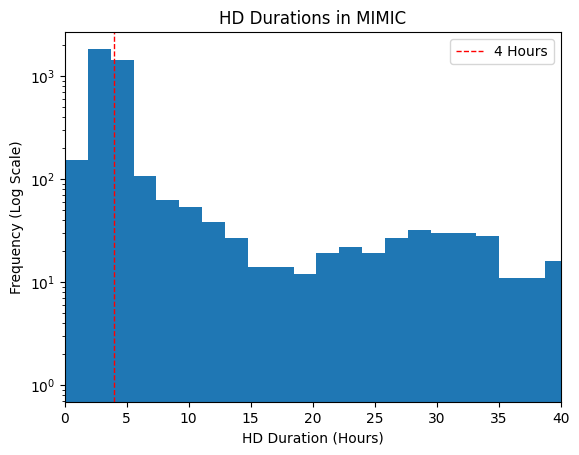

In [ ]:
# --- EDA VIZ on HD DURATIONS
# show the distribution of the HD durations in hours
# sns.histplot(hd_events['value_hr'], bins=200)
plt.hist(hd_events["value_hr"], bins = 200)
plt.xlim((0,40))
plt.yscale("log")
plt.xlabel('HD Duration (Hours)')
plt.axvline(x=4, color='red', linestyle='--', linewidth=1, label='4 Hours')
plt.ylabel('Frequency (Log Scale)')
plt.title('HD Durations in MIMIC')
plt.legend()
plt.show()

In [ ]:
def match_pe_and_ce(pe_df, ce_df, pe_mode: {"crrt", "ihd", "pd"} = "ihd", buffer_hours: int = 1):
    '''
    # TODO - RESUME
    '''
    pe_col_names_ = ['index', 'hadm_id', 'starttime', 'endtime', 'storetime', 'value_hr'] if pe_mode == "ihd" else pe_col_names
    
    joined = pd.merge(
        pe_df[pe_col_names_],
        ce_df[ce_col_names],
        how = "inner", on = "hadm_id", indicator = True
    )
    
    if pe_mode == "ihd":
        joined["o_rate"] = round(joined["valuenum"] / joined["value_hr"], 2)
    
    # "match" is True is charttime falls between start and end time
    joined["match"] = (joined["starttime"] - timedelta(hours = buffer_hours) <= joined["charttime"]) & (joined["charttime"] <= joined["endtime"] + timedelta(hours = buffer_hours))
    
    # find the match rate of PE (% PE that has at least one corresonding CE)
    # i.e. how many HD procedures has at least one charted val in between?
    pe_match_indices = joined.loc[joined["match"] == True, "index_x"].unique()
    pe_match_rate = len(pe_match_indices) / len(pe_df)
    print(f"{len(pe_match_indices)} ({pe_match_rate * 100:.1f}%) procedures have at least one corresponding chart events.")
    
    # how many charted val has at least one corresponding procedures?
    ce_match_indices = joined.loc[joined["match"] == True, "index_y"].unique()
    ce_match_rate = len(ce_match_indices) / len(ce_df)
    print(f"{len(ce_match_indices)} ({ce_match_rate * 100:.1f}%) chart events have at least one corresponding procedures.") 
    
    return joined.loc[joined["match"] == True,:]

hd_and_hdo = match_pe_and_ce(hd_events, hdo_events, "ihd", 0)
hd_and_hdo

1503 (34.5%) procedures have at least one corresponding chart events.
1591 (32.8%) chart events have at least one corresponding procedures.


,index_x,hadm_id,starttime,endtime,storetime_x,value_hr,index_y,charttime,storetime_y,valuenum,valueuom,_merge,o_rate,match
0,1,20012928,2123-02-28 09:15:00,2123-02-28 15:33:00,2123-02-28 15:33:53.177,6.30,0,2123-02-28 12:55:00,2123-02-28 12:56:00,1200.0,mL,both,190.48,True
3,6,20050595,2202-12-01 16:56:00,2202-12-03 10:42:00,2202-12-03 10:42:37.03,41.77,4,2202-12-01 21:37:00,2202-12-02 00:37:00,2000.0,mL,both,47.88,True
4,6,20050595,2202-12-01 16:56:00,2202-12-03 10:42:00,2202-12-03 10:42:37.03,41.77,5,2202-12-02 13:00:00,2202-12-02 23:44:00,2000.0,mL,both,47.88,True
5,10,20070470,2158-01-24 18:20:00,2158-01-25 18:52:00,2158-01-25 18:59:00,24.53,11,2158-01-24 21:23:00,2158-01-24 21:23:00,1000.0,mL,both,40.77,True
12,11,20070470,2158-01-29 13:00:00,2158-01-29 17:00:00,2158-01-29 17:34:00,4.00,14,2158-01-29 17:00:00,2158-01-29 18:02:00,2000.0,mL,both,500.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15383,4352,29990494,2171-05-26 14:30:00,2171-05-26 18:15:00,2171-05-26 18:25:00,3.75,4848,2171-05-26 18:00:00,2171-05-26 18:27:00,500.0,mL,both,133.33,True
15390,4355,29992506,2201-08-29 07:30:00,2201-08-29 11:00:00,2201-08-29 11:27:00,3.50,4850,2201-08-29 10:00:00,2201-08-29 10:20:00,1400.0,mL,both,400.00,True
15397,4357,29992506,2201-09-09 13:00:00,2201-09-09 15:53:00,2201-09-09 16:27:00,2.88,4851,2201-09-09 15:50:00,2201-09-09 16:28:00,750.0,mL,both,260.42,True
15401,4358,29992506,2201-09-11 12:06:00,2201-09-11 15:57:00,2201-09-11 18:05:00,3.85,4852,2201-09-11 15:52:00,2201-09-11 15:52:00,1400.0,mL,both,363.64,True


In [ ]:
match_pe_and_ce(crrt_events, uf_events, "crrt")

4157 (97.8%) procedures have at least one corresponding chart events.
199426 (91.6%) chart events have at least one corresponding procedures.


_merge
both          1009184
left_only           0
right_only          0
dtype: int64

In [ ]:
match_pe_and_ce(hd_events, uf_events, "ihd")

624 (14.3%) procedures have at least one corresponding chart events.
4211 (1.9%) chart events have at least one corresponding procedures.


,index_x,hadm_id,starttime,endtime,storetime_x,value_hr,index_y,charttime,storetime_y,valuenum,valueuom,_merge,o_rate,match
4022,17,20079585,2145-12-03 22:18:00,2145-12-04 02:27:00,2145-12-10 21:43:00,4.15,1255,2145-12-03 22:00:00,2145-12-04 00:08:00,11.0,mL,both,2.65,True
4023,17,20079585,2145-12-03 22:18:00,2145-12-04 02:27:00,2145-12-10 21:43:00,4.15,1256,2145-12-03 23:00:00,2145-12-04 00:07:00,237.0,mL,both,57.11,True
4024,17,20079585,2145-12-03 22:18:00,2145-12-04 02:27:00,2145-12-10 21:43:00,4.15,1257,2145-12-04 00:00:00,2145-12-04 01:08:00,337.0,mL,both,81.20,True
4025,17,20079585,2145-12-03 22:18:00,2145-12-04 02:27:00,2145-12-10 21:43:00,4.15,1258,2145-12-04 01:00:00,2145-12-04 02:11:00,328.0,mL,both,79.04,True
4026,17,20079585,2145-12-03 22:18:00,2145-12-04 02:27:00,2145-12-10 21:43:00,4.15,1259,2145-12-04 02:00:00,2145-12-04 03:11:00,407.0,mL,both,98.07,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347956,4335,29918315,2177-01-10 17:59:00,2177-01-15 13:23:00,2177-01-15 13:23:46.413,115.40,216723,2177-01-15 05:00:00,2177-01-15 06:25:00,341.0,mL,both,2.95,True
347957,4335,29918315,2177-01-10 17:59:00,2177-01-15 13:23:00,2177-01-15 13:23:46.413,115.40,216724,2177-01-15 06:00:00,2177-01-15 07:12:00,328.0,mL,both,2.84,True
347958,4335,29918315,2177-01-10 17:59:00,2177-01-15 13:23:00,2177-01-15 13:23:46.413,115.40,216725,2177-01-15 07:00:00,2177-01-15 08:22:00,351.0,mL,both,3.04,True
348143,4347,29966638,2110-08-27 17:30:00,2110-08-27 19:45:00,2110-08-27 19:27:00,2.25,217074,2110-08-27 19:26:00,2110-08-27 19:26:00,3000.0,mL,both,1333.33,True


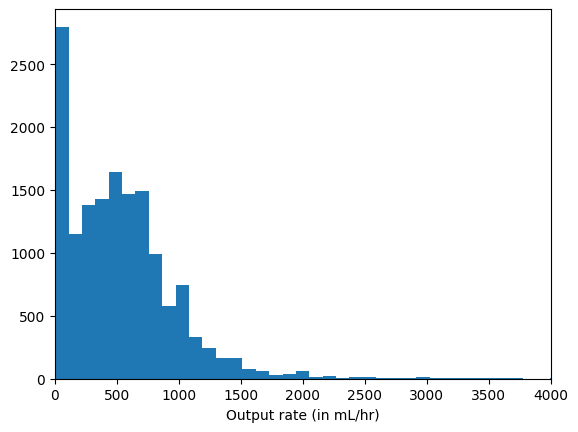

In [ ]:
# plot the rate distribution of the 
plt.hist(hd_and_hdo["o_rate"], bins = 600)
plt.xlim(0,4000)
plt.xlabel("Output rate (in mL/hr)")
plt.show()

In [ ]:
# check dups -- i.e if one chart event is captured by multiple different procedures
hdo_to_hd_dups = hd_and_hdo[hd_and_hdo.duplicated(subset=["index_y"], keep = False)] 
hdo_to_hd_dups

,index_x,hadm_id,starttime,endtime,storetime_x,value_hr,index_y,charttime,storetime_y,valuenum,valueuom
18,14,20079585,2145-11-22 17:30:00,2145-11-24 08:37:00,2145-11-24 08:50:00,39.12,16,2145-11-22 20:00:00,2145-11-23 04:45:00,800.0,mL
22,15,20079585,2145-11-22 17:30:00,2145-11-24 08:44:00,2145-11-24 08:50:00,39.23,16,2145-11-22 20:00:00,2145-11-23 04:45:00,800.0,mL
649,185,20518469,2169-02-06 08:00:00,2169-02-11 18:57:00,2169-02-11 21:10:00,130.95,217,2169-02-06 17:46:00,2169-02-06 17:46:00,476.0,mL
659,186,20518469,2169-02-06 17:46:00,2169-02-11 19:00:00,2169-02-11 21:10:00,121.23,217,2169-02-06 17:46:00,2169-02-06 17:46:00,476.0,mL
811,245,20668073,2127-10-03 09:05:00,2127-10-08 16:29:00,2127-10-08 16:29:15.33,127.40,277,2127-10-03 12:22:00,2127-10-03 12:22:00,2100.0,mL
...,...,...,...,...,...,...,...,...,...,...,...
15252,4275,29742376,2123-03-18 12:00:00,2123-03-18 18:31:00,2123-03-18 18:31:19.363,6.52,4760,2123-03-18 16:54:00,2123-03-18 16:54:00,1500.0,mL
15278,4294,29796943,2161-05-06 08:30:00,2161-05-06 12:30:00,2161-05-06 17:34:00,4.00,4783,2161-05-06 12:15:00,2161-05-06 12:32:00,2000.0,mL
15280,4295,29796943,2161-05-06 09:00:00,2161-05-06 12:30:00,2161-05-06 12:32:00,3.50,4783,2161-05-06 12:15:00,2161-05-06 12:32:00,2000.0,mL
15367,4338,29933107,2179-10-03 08:30:00,2179-10-04 18:28:00,2179-10-04 18:28:05.437,33.97,4824,2179-10-03 12:00:00,2179-10-03 14:15:00,3000.0,mL


In [ ]:
# now, check for CE-PE "congruence"
hd_and_hdo_missed = hd_and_hdo.loc[
    (~hd_and_hdo["index_x"].isin(hd_and_hdo_inrange["index_x"])) & (~hd_and_hdo["index_y"].isin(hd_and_hdo_inrange["index_y"])),
    :
]
hd_and_hdo_missed

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y
1,2,20021612,2162-05-07 13:10:00,2162-05-07 16:23:00,2162-05-07 17:07:00,193.0,min,1,2162-05-07 17:07:00,2162-05-07 17:07:00,1800.0,mL
2,3,20030303,2158-03-15 07:10:00,2158-03-15 10:10:00,2158-03-15 08:17:00,3.0,hour,3,2158-03-15 10:19:00,2158-03-15 10:20:00,4000.0,mL
50,22,20089631,2175-04-08 11:45:00,2175-04-08 15:15:00,2175-04-08 16:41:00,210.0,min,20,2175-04-04 13:25:00,2175-04-04 13:26:00,2000.0,mL
52,22,20089631,2175-04-08 11:45:00,2175-04-08 15:15:00,2175-04-08 16:41:00,210.0,min,22,2175-04-08 15:21:00,2175-04-08 15:21:00,2500.0,mL
56,25,20099155,2177-07-20 18:52:00,2177-07-20 20:52:00,2177-07-20 18:53:00,2.0,hour,26,2177-07-25 17:00:00,2177-07-25 17:59:00,1400.0,mL
...,...,...,...,...,...,...,...,...,...,...,...,...
15376,4345,29955812,2140-04-06 08:52:00,2140-04-06 12:49:00,2140-04-06 16:09:00,237.0,min,4837,2140-04-06 13:09:00,2140-04-06 16:09:00,600.0,mL
15377,4347,29966638,2110-08-27 17:30:00,2110-08-27 19:45:00,2110-08-27 19:27:00,135.0,min,4839,2110-08-30 18:23:00,2110-08-30 18:25:00,1500.0,mL
15378,4348,29966638,2110-08-29 09:45:00,2110-08-29 12:00:00,2110-08-29 12:39:00,135.0,min,4839,2110-08-30 18:23:00,2110-08-30 18:25:00,1500.0,mL
15379,4349,29966638,2110-09-14 09:30:00,2110-09-14 19:05:00,2110-09-15 06:02:00,575.0,min,4839,2110-08-30 18:23:00,2110-08-30 18:25:00,1500.0,mL


In [ ]:
# how many HD procedures has no charted val in between?
hd_wo_hdo = hd_events.loc[
    (~hd_events["index"].isin(hd_and_hdo["index_x"])),
    :
]
hd_wo_hdo_rate = len(hd_wo_hdo) / len(hd_events)
print(f"{len(hd_wo_hdo)} ({hd_wo_hdo_rate * 100:.1f}%) HD procedures have NO corresponding HDO chart events.")

640 (14.7%) HD procedures have NO corresponding HDO chart events.


In [ ]:
# how many charted val has no corresponding procedures?
hdo_wo_hd = hdo_events.loc[
    (~hdo_events["index"].isin(hd_and_hdo["index_y"])),
    :
]
hdo_wo_hd_rate = len(hdo_wo_hd) / len(hdo_events)
print(f"{len(hdo_wo_hd)} ({hdo_wo_hd_rate * 100:.1f}%) HD output chart events have NO corresponding HD procedure.")

3263 (67.2%) HD output chart events have NO corresponding HD procedure.


### EDA of super long HD

In [ ]:
'''
checked: 
- 37 - 22 UF CE
- 33, 63
- 7 no corresonding CE
'''
idx_eg = 63
find_ce_within_pe(hd_events, idx_eg, hdo_events)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,63,20195118,2140-03-14 14:19:00,2140-03-15 14:18:00,2140-03-15 14:18:46.813,1439.0,min,67,2140-03-14 16:02:00,2140-03-14 16:03:00,1800.0,mL,both


In [ ]:
# find if this super long HD has other charted UF output -- there is
find_ce_within_pe(hd_events, idx_eg, uf_events, 1)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,63,20195118,2140-03-14 14:19:00,2140-03-15 14:18:00,2140-03-15 14:18:46.813,1439.0,min,NaN,NaT,NaN,NaN,NaN,left_only


In [ ]:
# find if this super long HD has other charted UF output -- there is
find_ce_within_pe(hd_events, idx_eg, hfr_events)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,9,20068469,2131-11-19 09:22:00,2131-11-19 17:21:00,2131-11-19 17:21:36.83,479.0,min,NaN,NaT,NaN,NaN,NaN,left_only


In [ ]:
find_ce_within_pe(hd_events, idx_eg, dr_events)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,9,20068469,2131-11-19 09:22:00,2131-11-19 17:21:00,2131-11-19 17:21:36.83,479.0,min,NaN,NaT,NaN,NaN,NaN,left_only


In [ ]:
# TODO: write the CE -> PE function

# see how many chart events does a super long HD cover
def find_pe_covering_ce(ce_df, ce_idx, pe_df, buffer_hours: int = 1):
    '''
    Find the procedure event that covers a chart event.
    '''
    ce_row = ce_df[ce_df["index"] == ce_idx]
    hadm_id = ce_row["hadm_id"].values[0]
    charttime = pd.to_datetime(ce_row["charttime"].values[0])
        
    pe_select = pe_df.loc[
        (pe_df["hadm_id"] == hadm_id) & 
        (pe_df["starttime"] <= charttime + timedelta(hours=buffer_hours)) &
        (charttime - timedelta(hours=buffer_hours) <= pe_df["endtime"])
    ]
    # return pe_select
    return pd.merge(
        pe_select[pe_col_names], ce_row[ce_col_names],
        how = "outer", on = "hadm_id", indicator = True
    )

find_pe_covering_ce(hdo_events, 46, hd_events)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,37,20128314,2117-01-04 08:53:00,2117-01-09 16:58:00,2117-01-09 22:46:00,7685.0,min,46,2117-01-04 12:05:00,2117-01-04 12:05:00,0.0,mL,both


### Viz

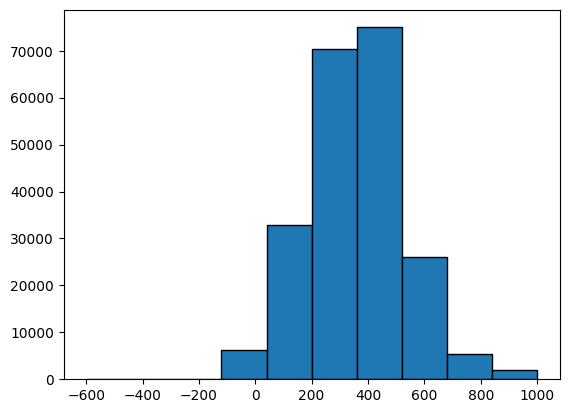

In [ ]:
# UF output
import matplotlib.pyplot as plt
plt.hist(uf_events['valuenum'].clip(upper=1000), bins=10, edgecolor='black')
plt.show()

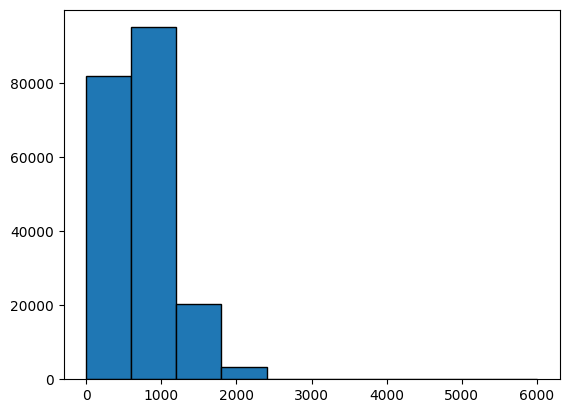

In [ ]:
# DR input
plt.hist(dr_events['valuenum'].clip(upper=6000), bins=10, edgecolor='black')
plt.show()

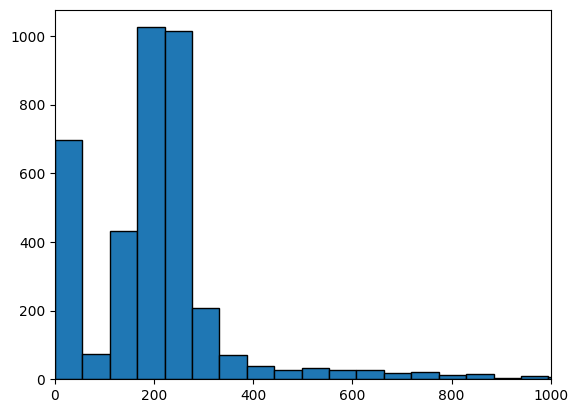

In [ ]:
plt.hist(hd_events['value'], bins = 400, edgecolor='black')
plt.xlim(0,1000)
plt.show()

# `key_icu_orders` table

In [21]:
ItemFinder("consult").candidate_table

2024-12-20 12:17:18,162:INFO:5 matching item(s) found for consult.


2024-12-20 12:17:21,771:INFO:the label for item 225135 is Consults
2024-12-20 12:17:21,774:INFO:the param_type for item 225135 (Consults) is Text
2024-12-20 12:17:22,277:INFO:the label for item 225078 is Social work consult
2024-12-20 12:17:22,280:INFO:the param_type for item 225078 (Social work consult) is Checkbox
2024-12-20 12:17:22,282:INFO:the label for item 229641 is Stroke NCP - Consults
2024-12-20 12:17:22,284:INFO:the param_type for item 229641 (Stroke NCP - Consults) is Text


item label: Consults; value instances: {'PT': 29203, 'Social Work': 25575, 'OT': 11793, 'Nutrition': 7492, 'Respiratory': 3777, 'Swallowing': 2554, 'Interpreter': 2527, 'Skin Care': 2328, 'Pain Services': 2151, 'Addiction Nurse': 2100, 'Speech': 1921, 'Other': 1510, 'Pastoral Services': 1149, 'Palliative Care': 1118, 'Psych Liason Nurse': 1036, 'ET Nurse': 180}


2024-12-20 12:17:22,763:INFO:the label for item 228261 is FM CM Consult
2024-12-20 12:17:22,765:INFO:the param_type for item 228261 (FM CM Consult) is Checkbox
2024-12-20 12:17:22,768:INFO:the label for item 228282 is FM SW consult
2024-12-20 12:17:22,770:INFO:the param_type for item 228282 (FM SW consult) is Checkbox


item label: Stroke NCP - Consults; value instances: {'PT / OT': 5142, 'Case management': 3810, 'Speech and swallow therapist': 3225, 'Social services': 1865, 'Interpreter services': 347, 'Palliative care': 317, 'Wound and skin': 266, 'Pastoral care': 232, '-----': 111}


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
1103,225135,Consults,Consults,chartevents,Adm History/FHPA,None,Text,99929.0,"{'PT': 29203, 'Social Work': 25575, 'OT': 1179..."
1073,225078,Social work consult,Social work consult,chartevents,Adm History/FHPA,None,Checkbox,91277.0,Checkbox
3757,229641,Stroke NCP - Consults,Stroke NCP - Consults,chartevents,Care Plans,None,Text,15315.0,"{'PT / OT': 5142, 'Case management': 3810, 'Sp..."
2779,228261,FM CM Consult,FM CM Consult,chartevents,Family Mtg Note,None,Checkbox,NaN,Checkbox
2793,228282,FM SW consult,FM SW consult,chartevents,Family Mtg Note,None,Checkbox,NaN,Checkbox


In [22]:
consult = ItemFinder("consult").candidate_table

2024-12-20 12:20:13,297:INFO:5 matching item(s) found for consult.


In [ ]:
consult